## Learning objectives
- Focus on probabilistic regression: calibrated threshold probabilities and interval outputs;
- Compare calibrated probabilities with alternative rules using triangular plots;
- Learn how to interpret CPS-derived medians and intervals alongside feature contributions.

## Time to run
~2–10 min depending on CPS settings and dataset size (choose small `num_to_test` for a fast demo).


# Calibrated explanations: probabilistic regression focus

> **Calibrated explanations, from binary and multiclass classification to probabilistic and interval regression.** Deliver trusted decisions with calibrated prediction intervals, dual-uncertainty insights, and interpretation guides that stay in lockstep across docs, notebooks, and runtime defaults.

This companion to the README and [regression quickstart](../docs/get-started/quickstart_regression.md) emphasises probabilistic regression. Work through the cells to:

- calibrate probabilistic thresholds alongside interval regression outputs,
- compare calibrated probabilities against rule-based alternatives, and
- interpret triangular plots exactly as described in the practitioner guides.

Wrap up by revisiting the [interpretation guide](../docs/how-to/interpret_explanations.md) and the [research hub](../docs/research/index.md) for citations. Optional extras, including fast explanations telemetry and CLI tooling, stay disabled in this notebook.


### Quick probabilistic threshold example (synthetic)
A compact synthetic example showing a calibrated probability that the prediction is below a threshold and a factual explanation for that probability.

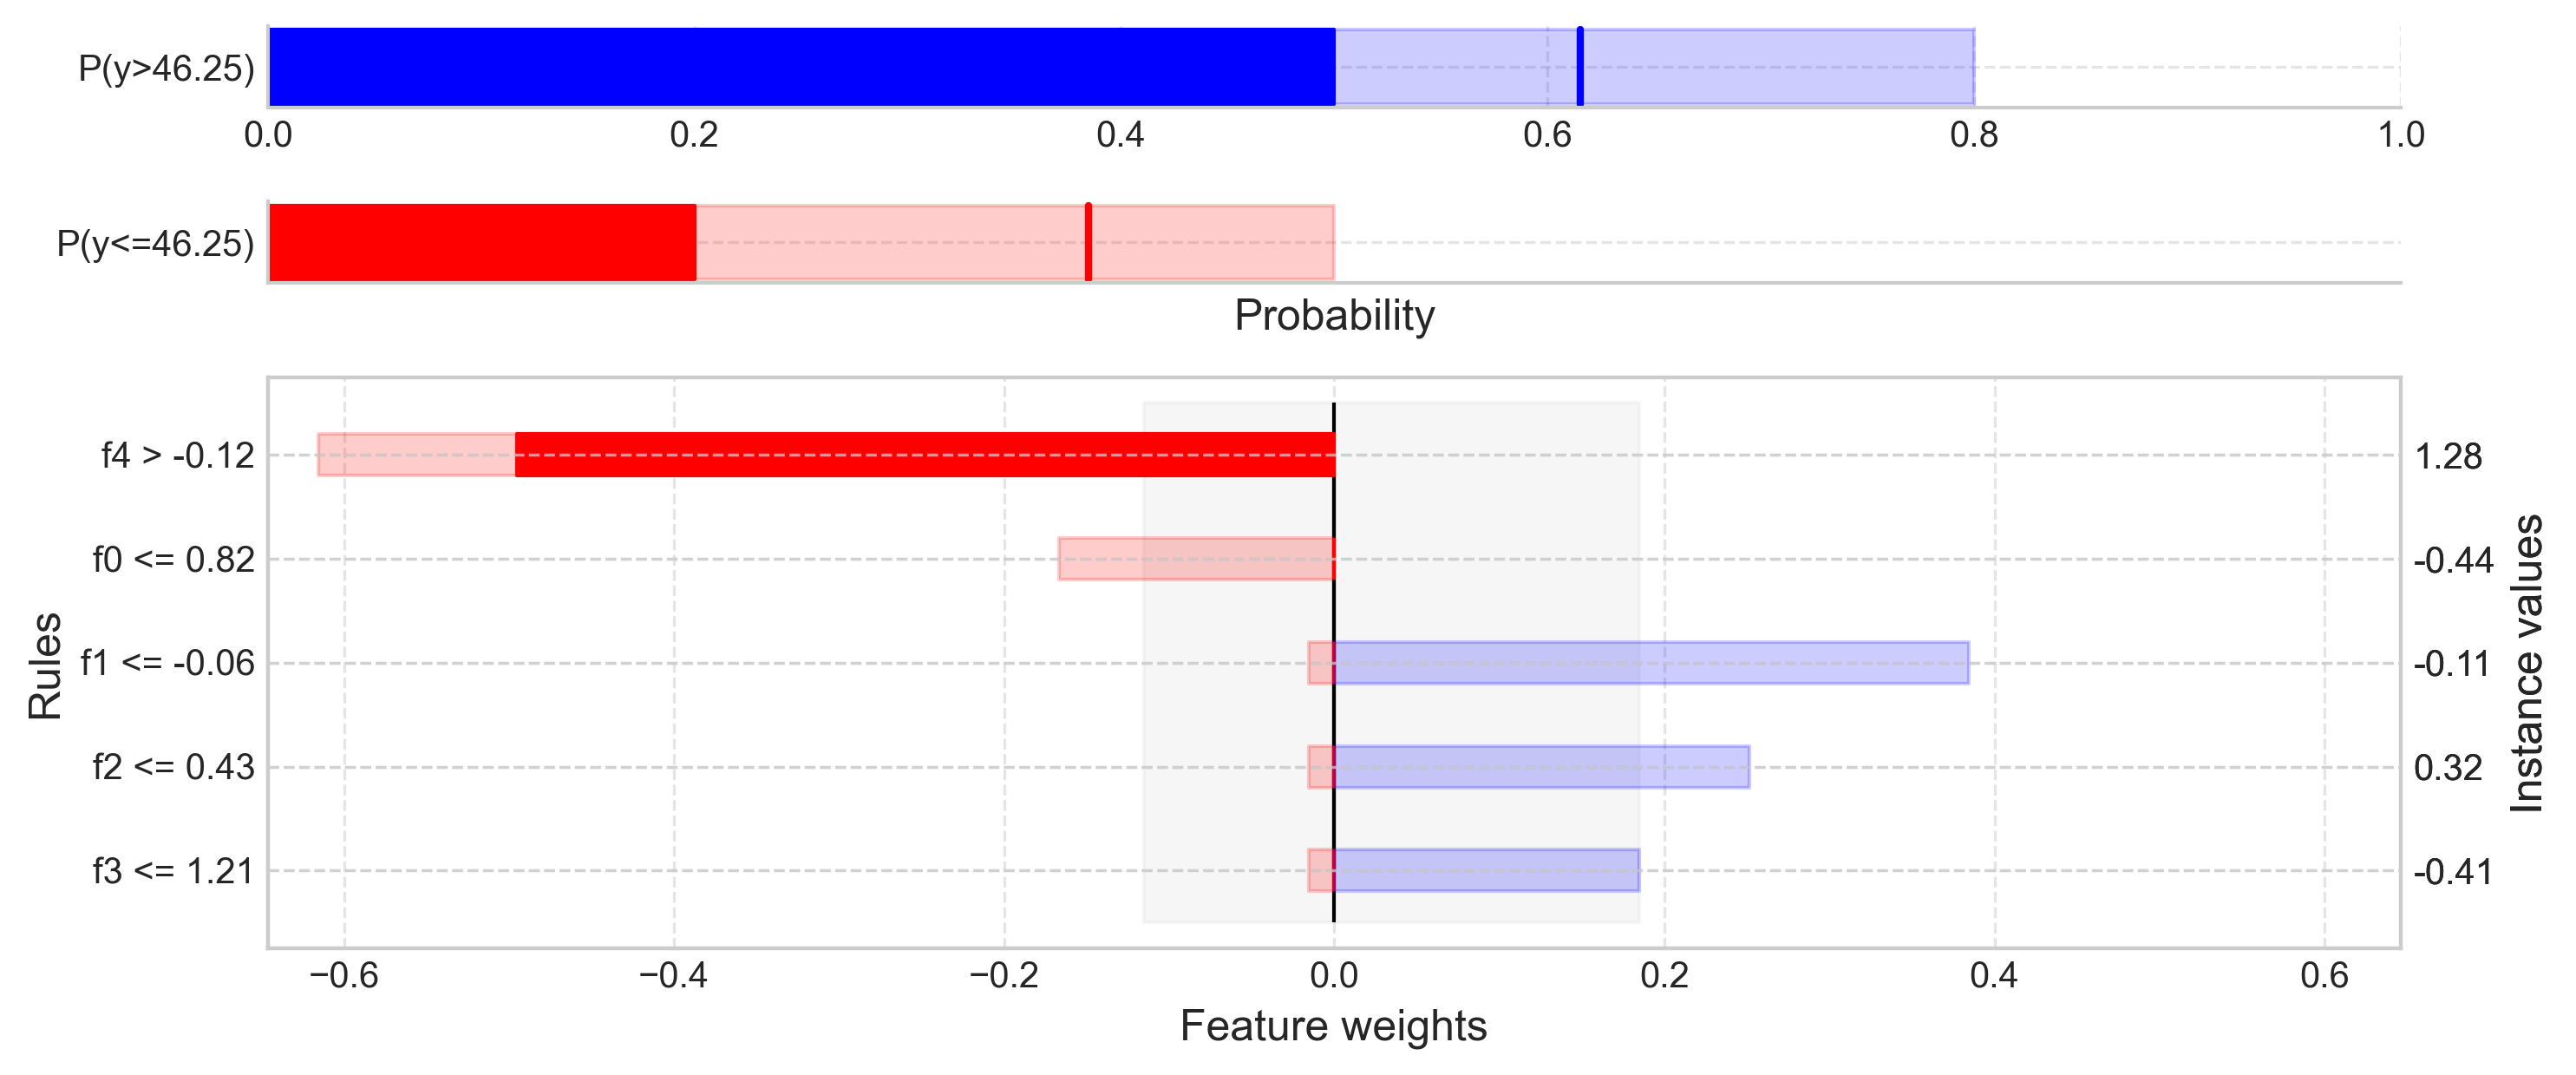

Chosen threshold: 46.2 — plotted calibrated probability and explanation for being <= threshold.


In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from calibrated_explanations import CalibratedExplainer

# synthetic dataset
X, y = make_regression(n_samples=300, n_features=5, noise=30, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1
)

model = RandomForestRegressor(n_estimators=60, random_state=1)
model.fit(X_prop_train, y_prop_train)
ce = CalibratedExplainer(
    model, X_cal, y_cal, mode="regression", feature_names=[f"f{i}" for i in range(X.shape[1])]
)
# choose a practical threshold near the median
threshold = float(np.median(y_train))
prob_factual = ce.explain_factual(X_test[:1], threshold=threshold)
prob_factual.plot(uncertainty=True)
print(
    f"Chosen threshold: {threshold:.1f} — plotted calibrated probability and explanation for being <= threshold."
)

**Calibrated explanations, from binary and multiclass classification to probabilistic and interval regression.** Run this notebook after the README and docs quickstarts to see the same calibrated journey in action.

- [Classification quickstart](../docs/get-started/quickstart_classification.md) · [Binary notebook](demo_binary_classification.ipynb)
- [Regression quickstart](../docs/get-started/quickstart_regression.md) · [Probabilistic notebook](demo_probabilistic_regression.ipynb)

> 🎓 **Backed by research:** consult [docs/citing.md](../docs/citing.md) for the publications covering binary & multiclass classification plus probabilistic and interval regression.
> 
> 🔺 **Triangular alternatives:** when you call `explore_alternatives`, pair the results with `plot(style="triangular")` to interpret uncertainty shifts. Fast explanations ship as an optional external plugin via `pip install "calibrated-explanations[external-plugins]"`.

### 1. Import packages, data and train an underlying model

#### 1.1 Import packages

In the examples below, we will be using `NumPy`, `pandas`, `sklearn`, and `crepes`. From `crepes`, we import `ConformalPredictiveSystem` and some helper functions from `crepes.extras`. `CalibratedExplainer` is imported from `calibrated_explanations`.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
from crepes import ConformalPredictiveSystem
from crepes.extras import DifficultyEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from calibrated_explanations import CalibratedExplainer, __version__

print(f"calibrated_explanations {__version__}")

calibrated_explanations v0.10.2


#### 1.2 Import data and train a model
Let us import the California Housing data set (see sources at the top).

In [4]:
dataset = "housing.csv"
delimiter = ";"
categorical_labels = {8: {0: "INLAND", 1: "NEAR BAY", 2: "<1H OCEAN", 3: "NEAR OCEAN", 4: "ISLAND"}}

filename = "../data/reg/" + dataset
df = pd.read_csv(filename, delimiter=delimiter, dtype=np.float64)
target = "median_house_value"
df.dropna(inplace=True)
X, y = df.drop(target, axis=1), df[target]
feature_names = df.drop(target, axis=1).columns
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  ocean_proximity  
0       322.0       126.0         8.3252            452600.0              1.0  
1      2401.0      1138.0         8.3014            358500.0              1.0  
2       496.0       177.0         7.2574            352100.0              1.0  
3       558.0       219.0         5.6431            341300.0              1.0  
4       565.0       259.0         3.8462            342200.0              1.0

Let us split the data set into a training and a test set, and further split the training set into a proper training set and a calibration set. Let us fit a random forest to the proper training set. We also set a random seed to be able to rerun the notebook and get the same results.

In [5]:
num_to_test = 2

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=num_to_test, random_state=42
)
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(
    X_train, y_train, test_size=1000, random_state=42
)

model = RandomForestRegressor(n_estimators=100, oob_score=True)

model.fit(X_prop_train, y_prop_train)

RandomForestRegressor(oob_score=True)

Before extracting an explanation, lets see what the output from a Conformal Predictive System (cps) is for the test instances. Three use cases are explored:
1. using percentiles to get the lower and upper bounds of an interval.
2. using the 50th percentile(s) to get the median prediction which can be used as a calibrated prediction from the underlying model.
3. getting the probability of the prediction being below a certain threshold. 250 000 is used as threshold, as it is close to the midpoint in the possible range of prices.

In [6]:
y_cal_pred = model.predict(X_cal)
y_test_pred = model.predict(X_test)

cps = ConformalPredictiveSystem()
cps.fit(residuals=y_cal - y_cal_pred)

interval = cps.predict(y_hat=y_test_pred, lower_percentiles=[5, 50], higher_percentiles=[95, 50])

p_values = cps.predict(y_hat=y_test_pred, y=180000)

print(
    "5th percentile, prediction, 50th percentile, 95th percentile, true value, p-value (cpsd<180000)"
)
print(
    *zip(
        np.round(interval[:, 0], decimals=1),
        np.round(y_test_pred, decimals=1),
        np.round((interval[:, 1] + interval[:, 3]) / 2, decimals=1),
        np.round(interval[:, 2], decimals=1),
        np.round(y_test, decimals=1),
        np.round(p_values * 100, decimals=1),
    ),
    sep="\n",
)

5th percentile, prediction, 50th percentile, 95th percentile, true value, p-value (cpsd<180000)
(158425.0, 223726.0, 220326.5, 297070.0, 245800.0, 10.9)
(96638.0, 161939.0, 158539.5, 235283.0, 137900.0, 78.0)


In [7]:
ce = CalibratedExplainer(
    model,
    X_cal,
    y_cal,
    feature_names=feature_names,
    categorical_labels=categorical_labels,
    mode="regression",
)
display(ce)

CalibratedExplainer(mode=regression, learner=RandomForestRegressor(oob_score=True), difficulty_estimator=None)

In [8]:
factual_explanation = ce.explain_factual(X_test, 180000)

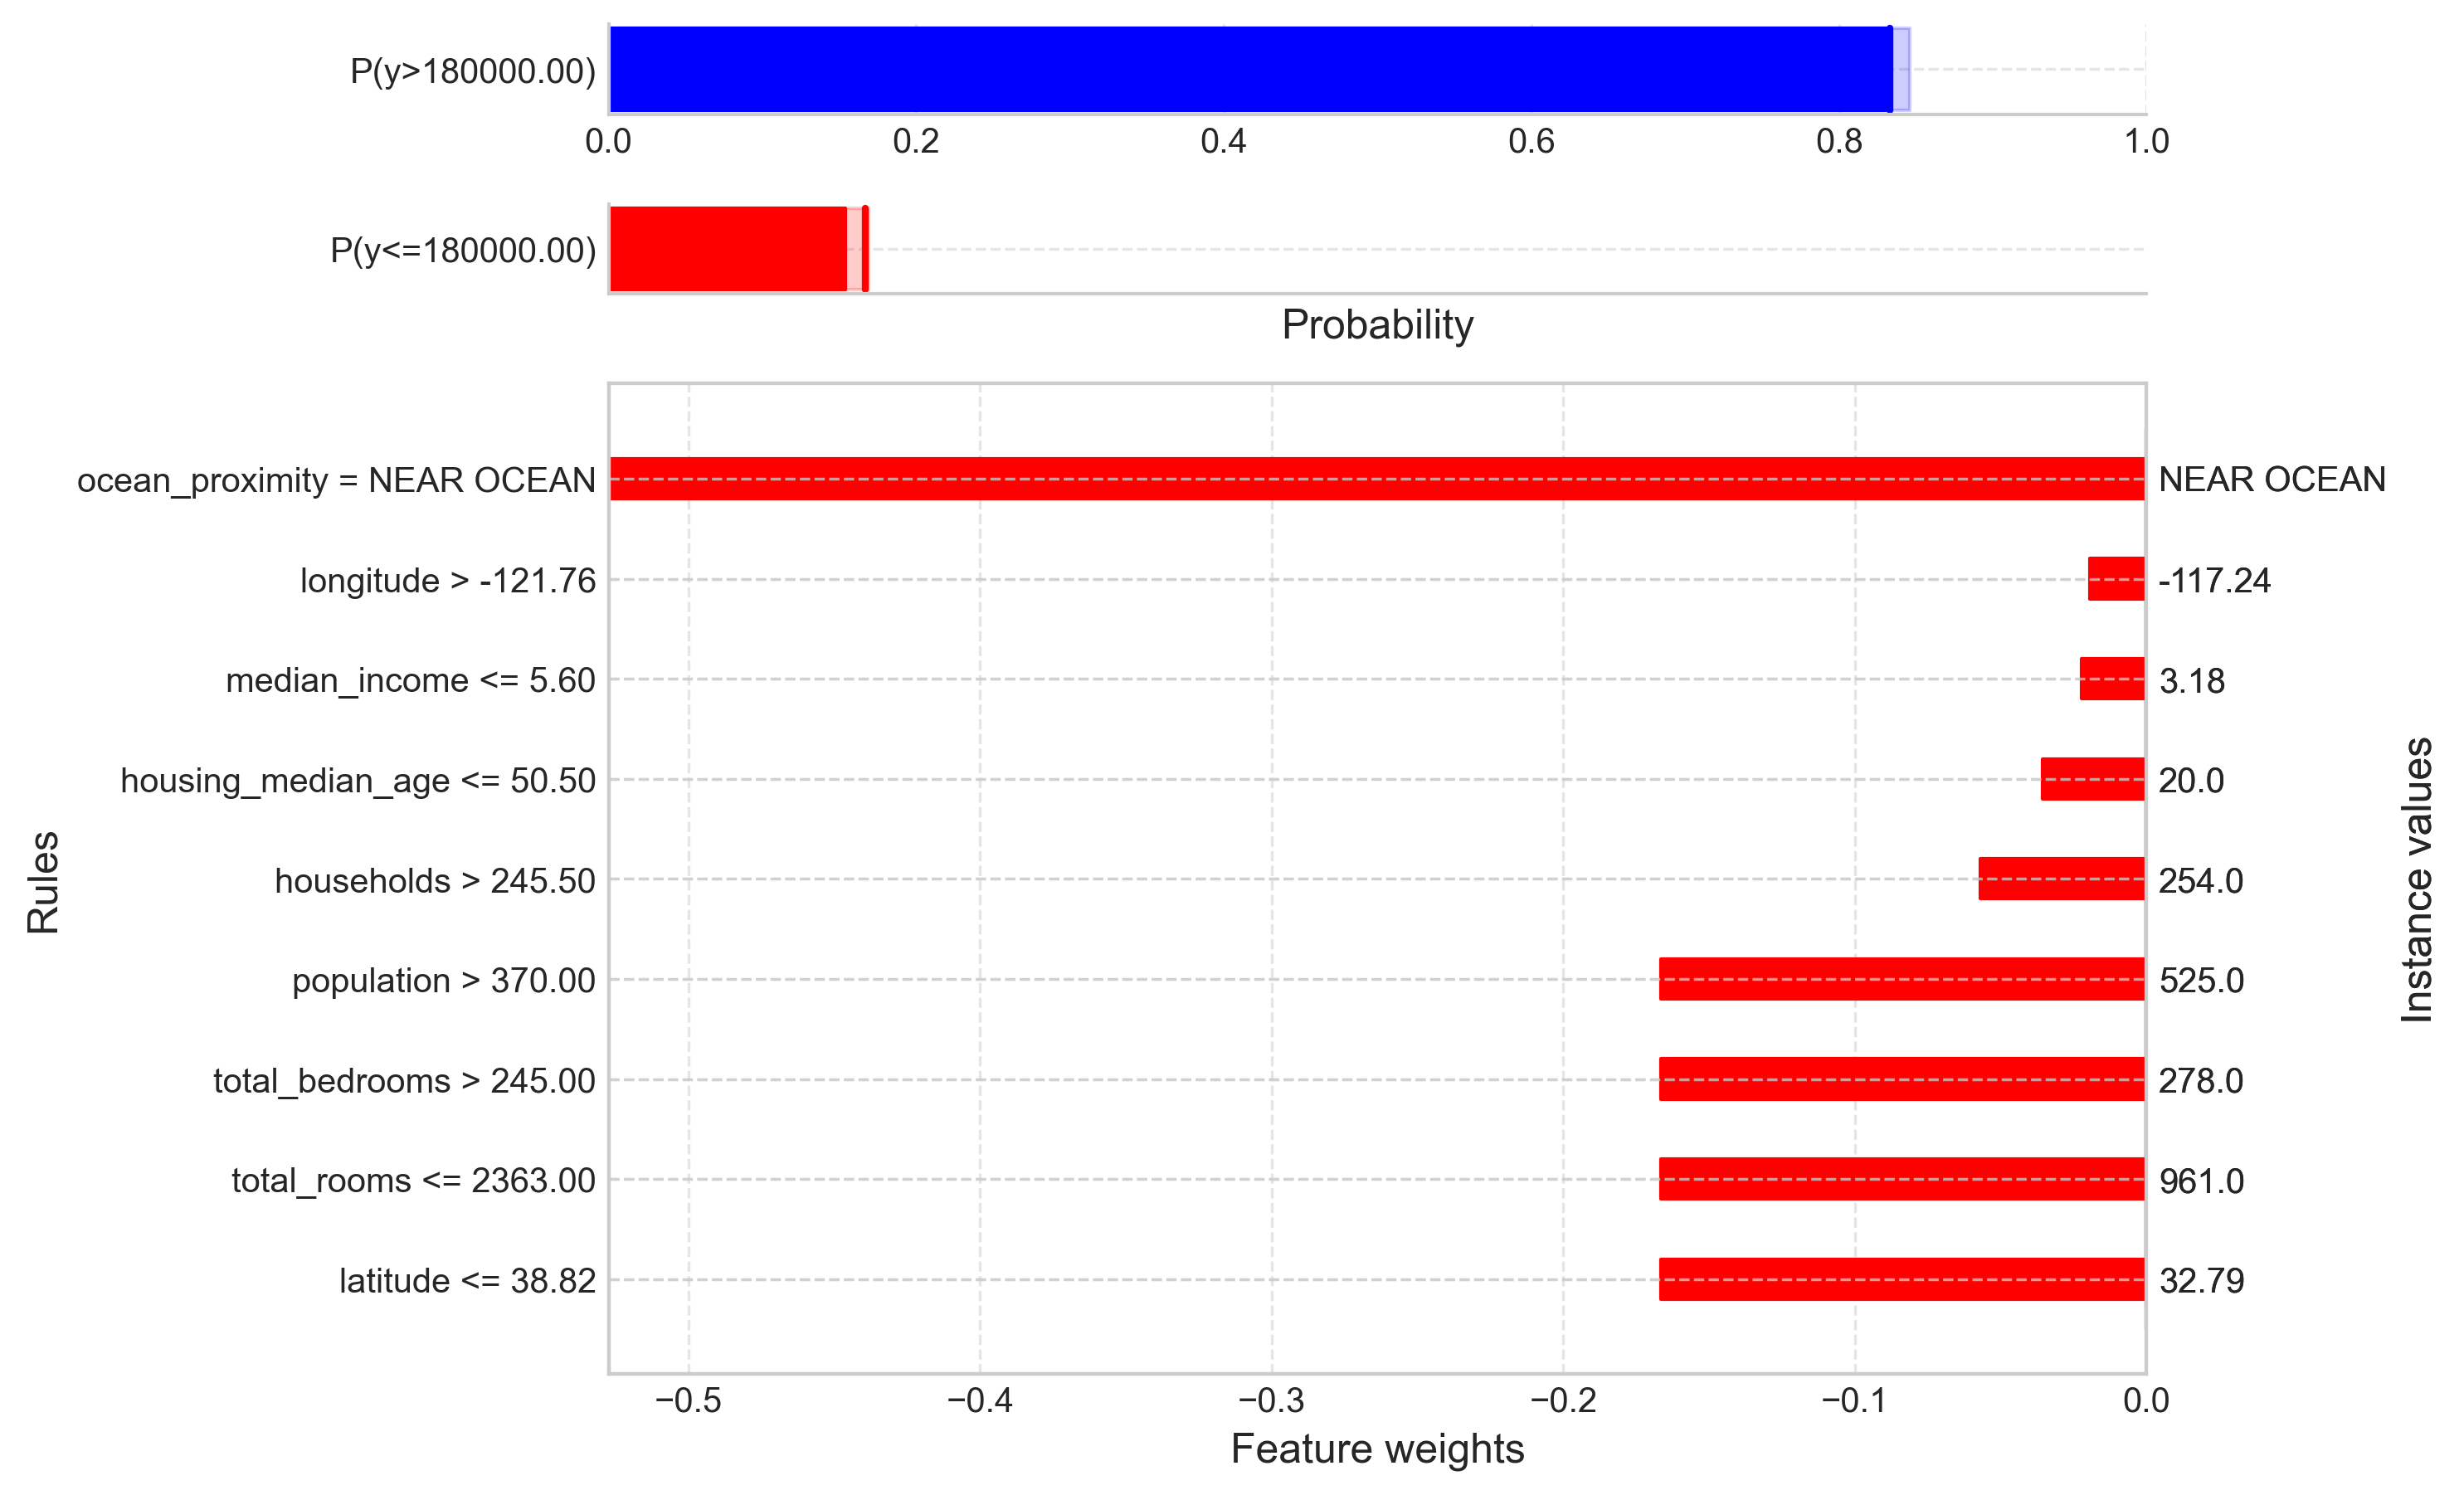

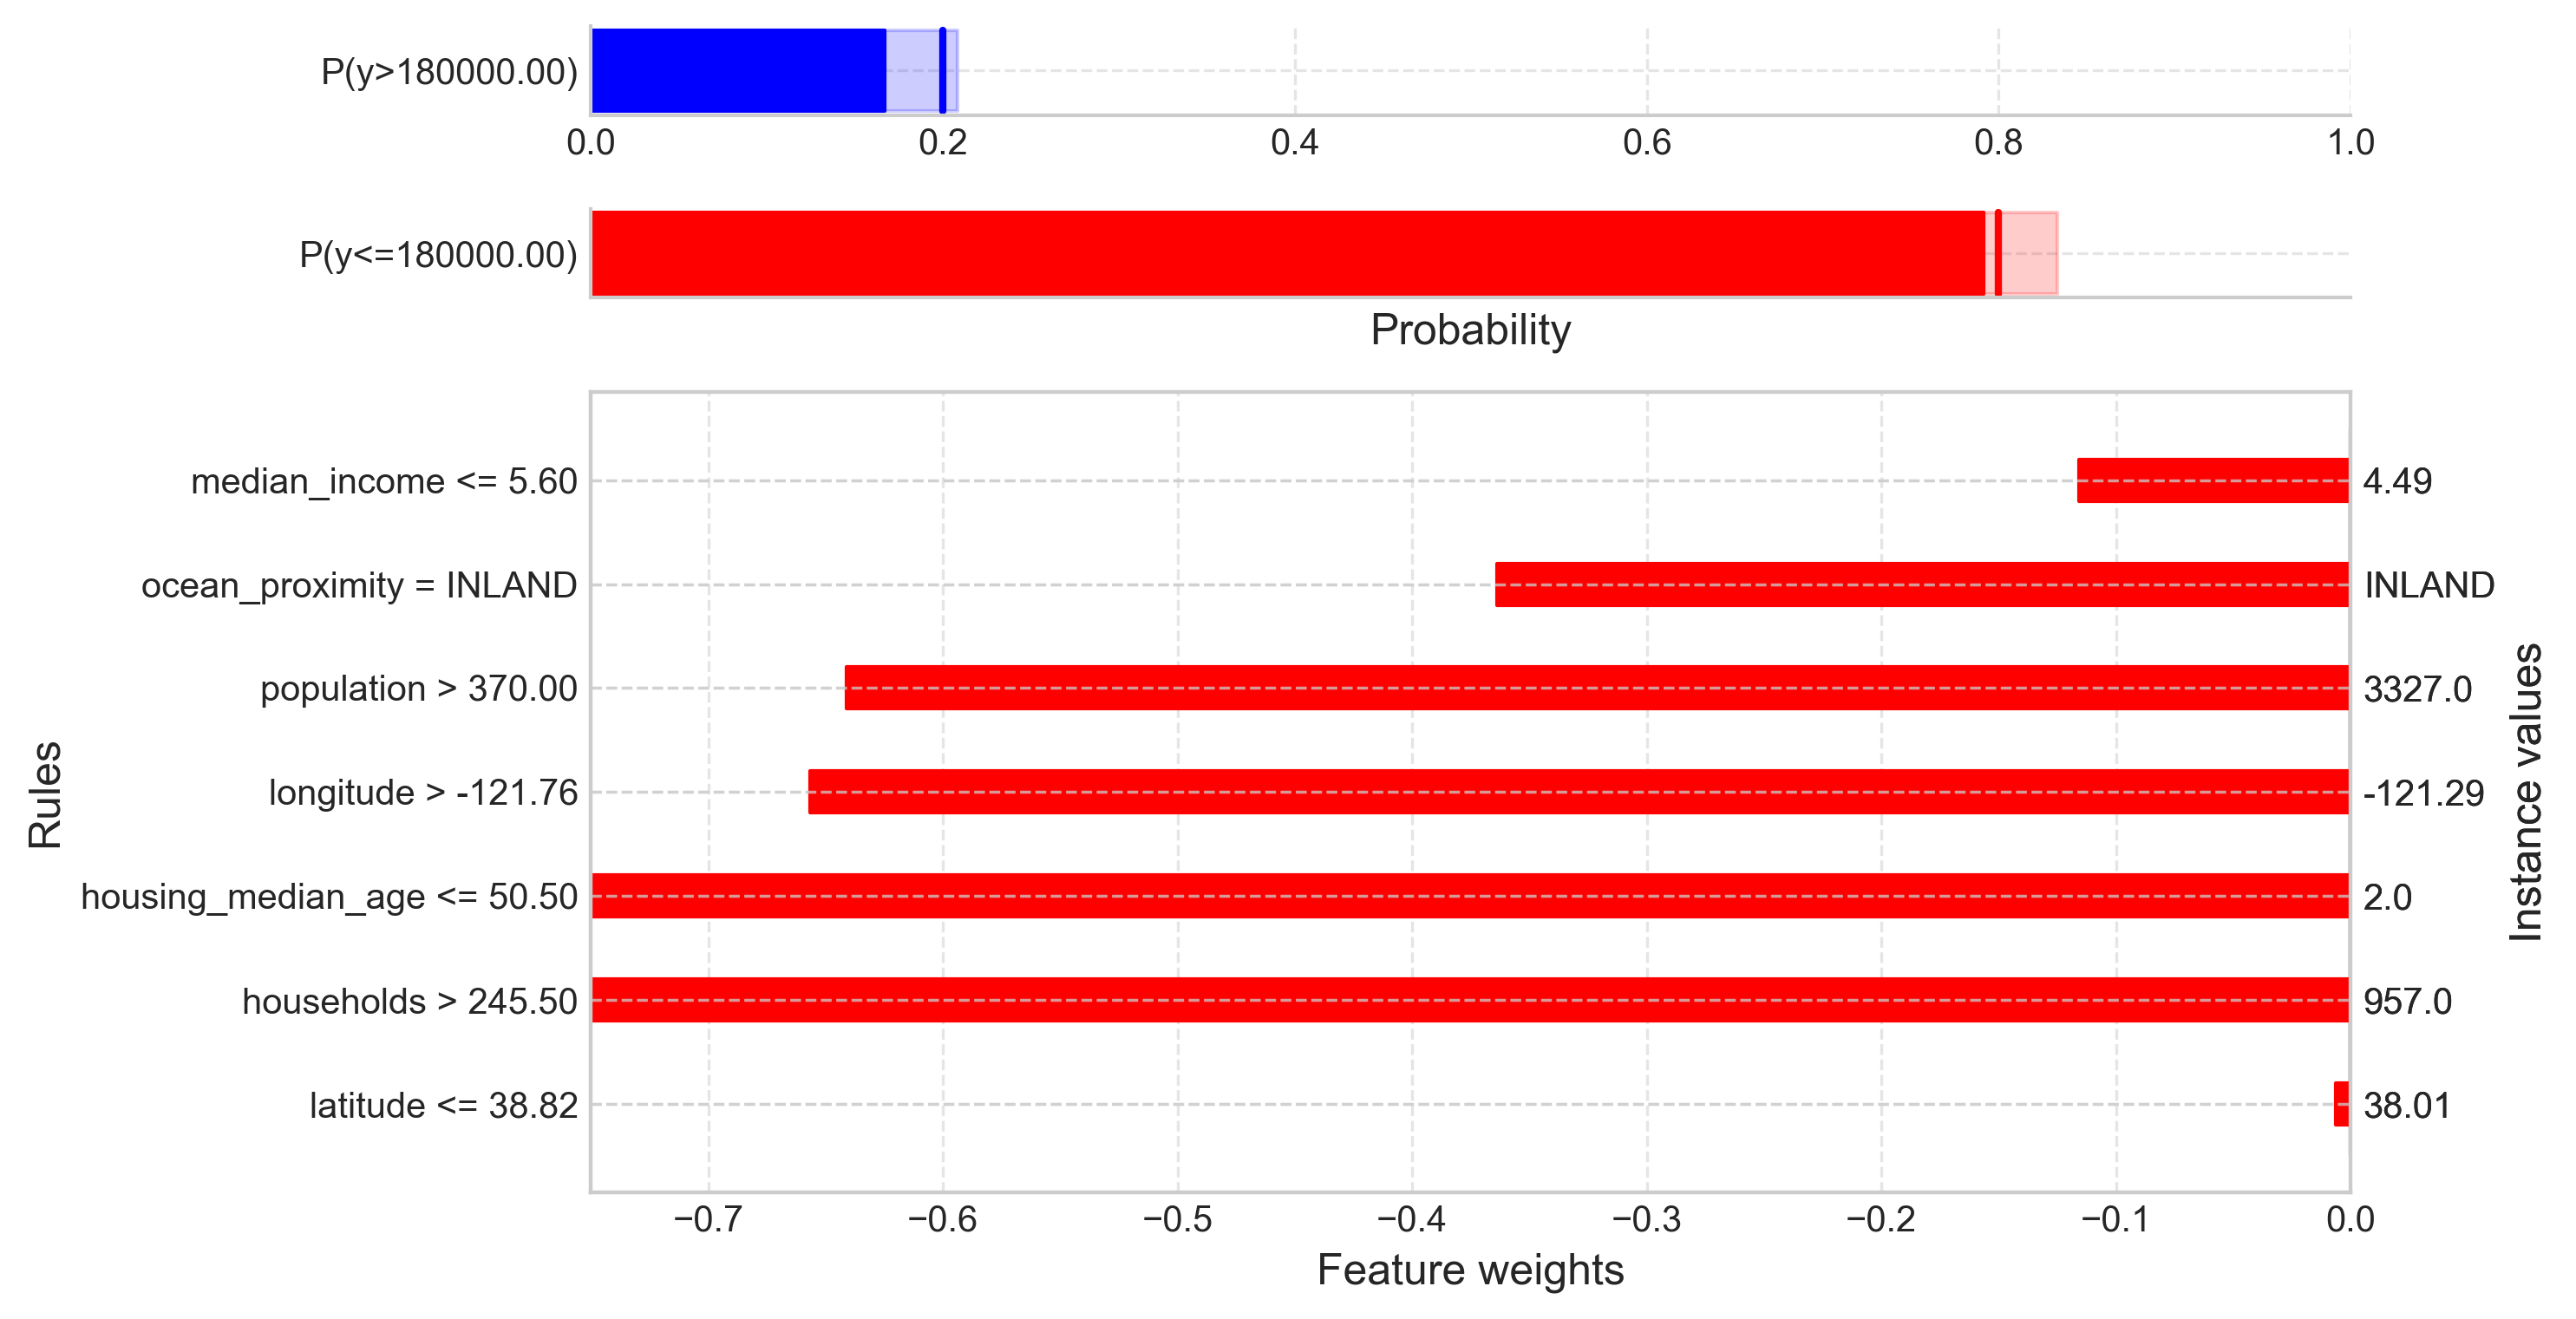

In [9]:
factual_explanation.plot()

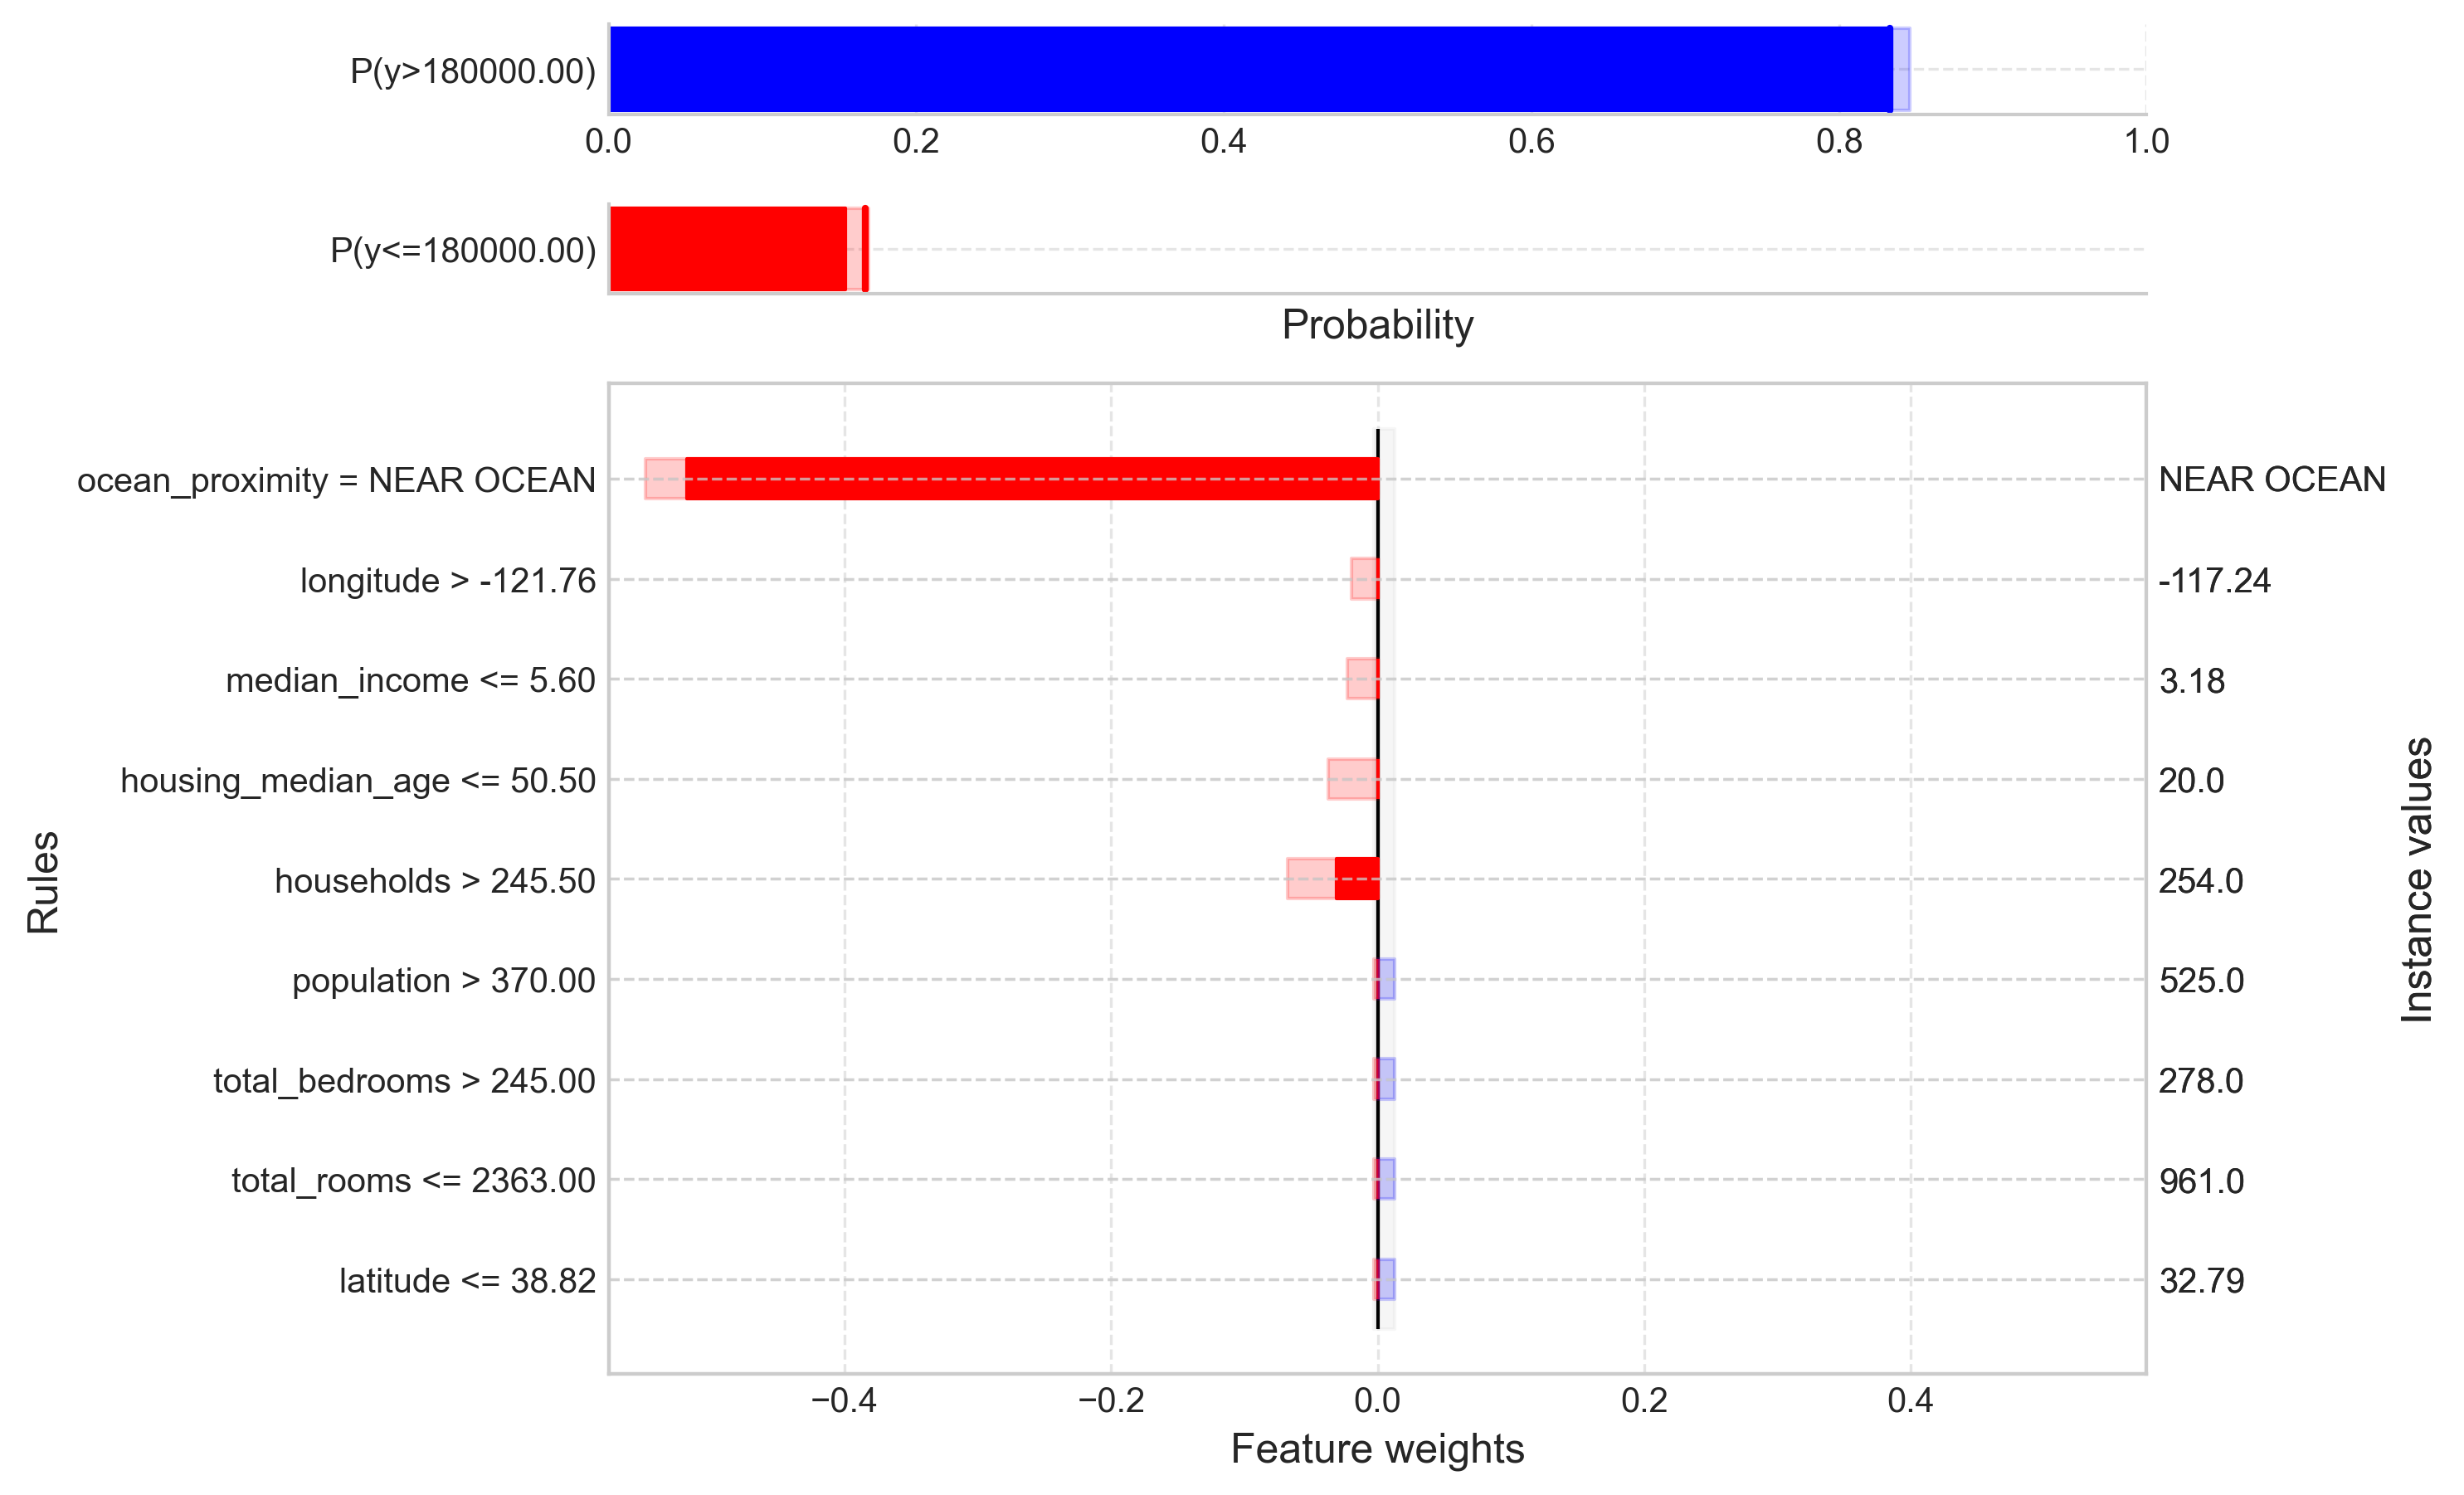

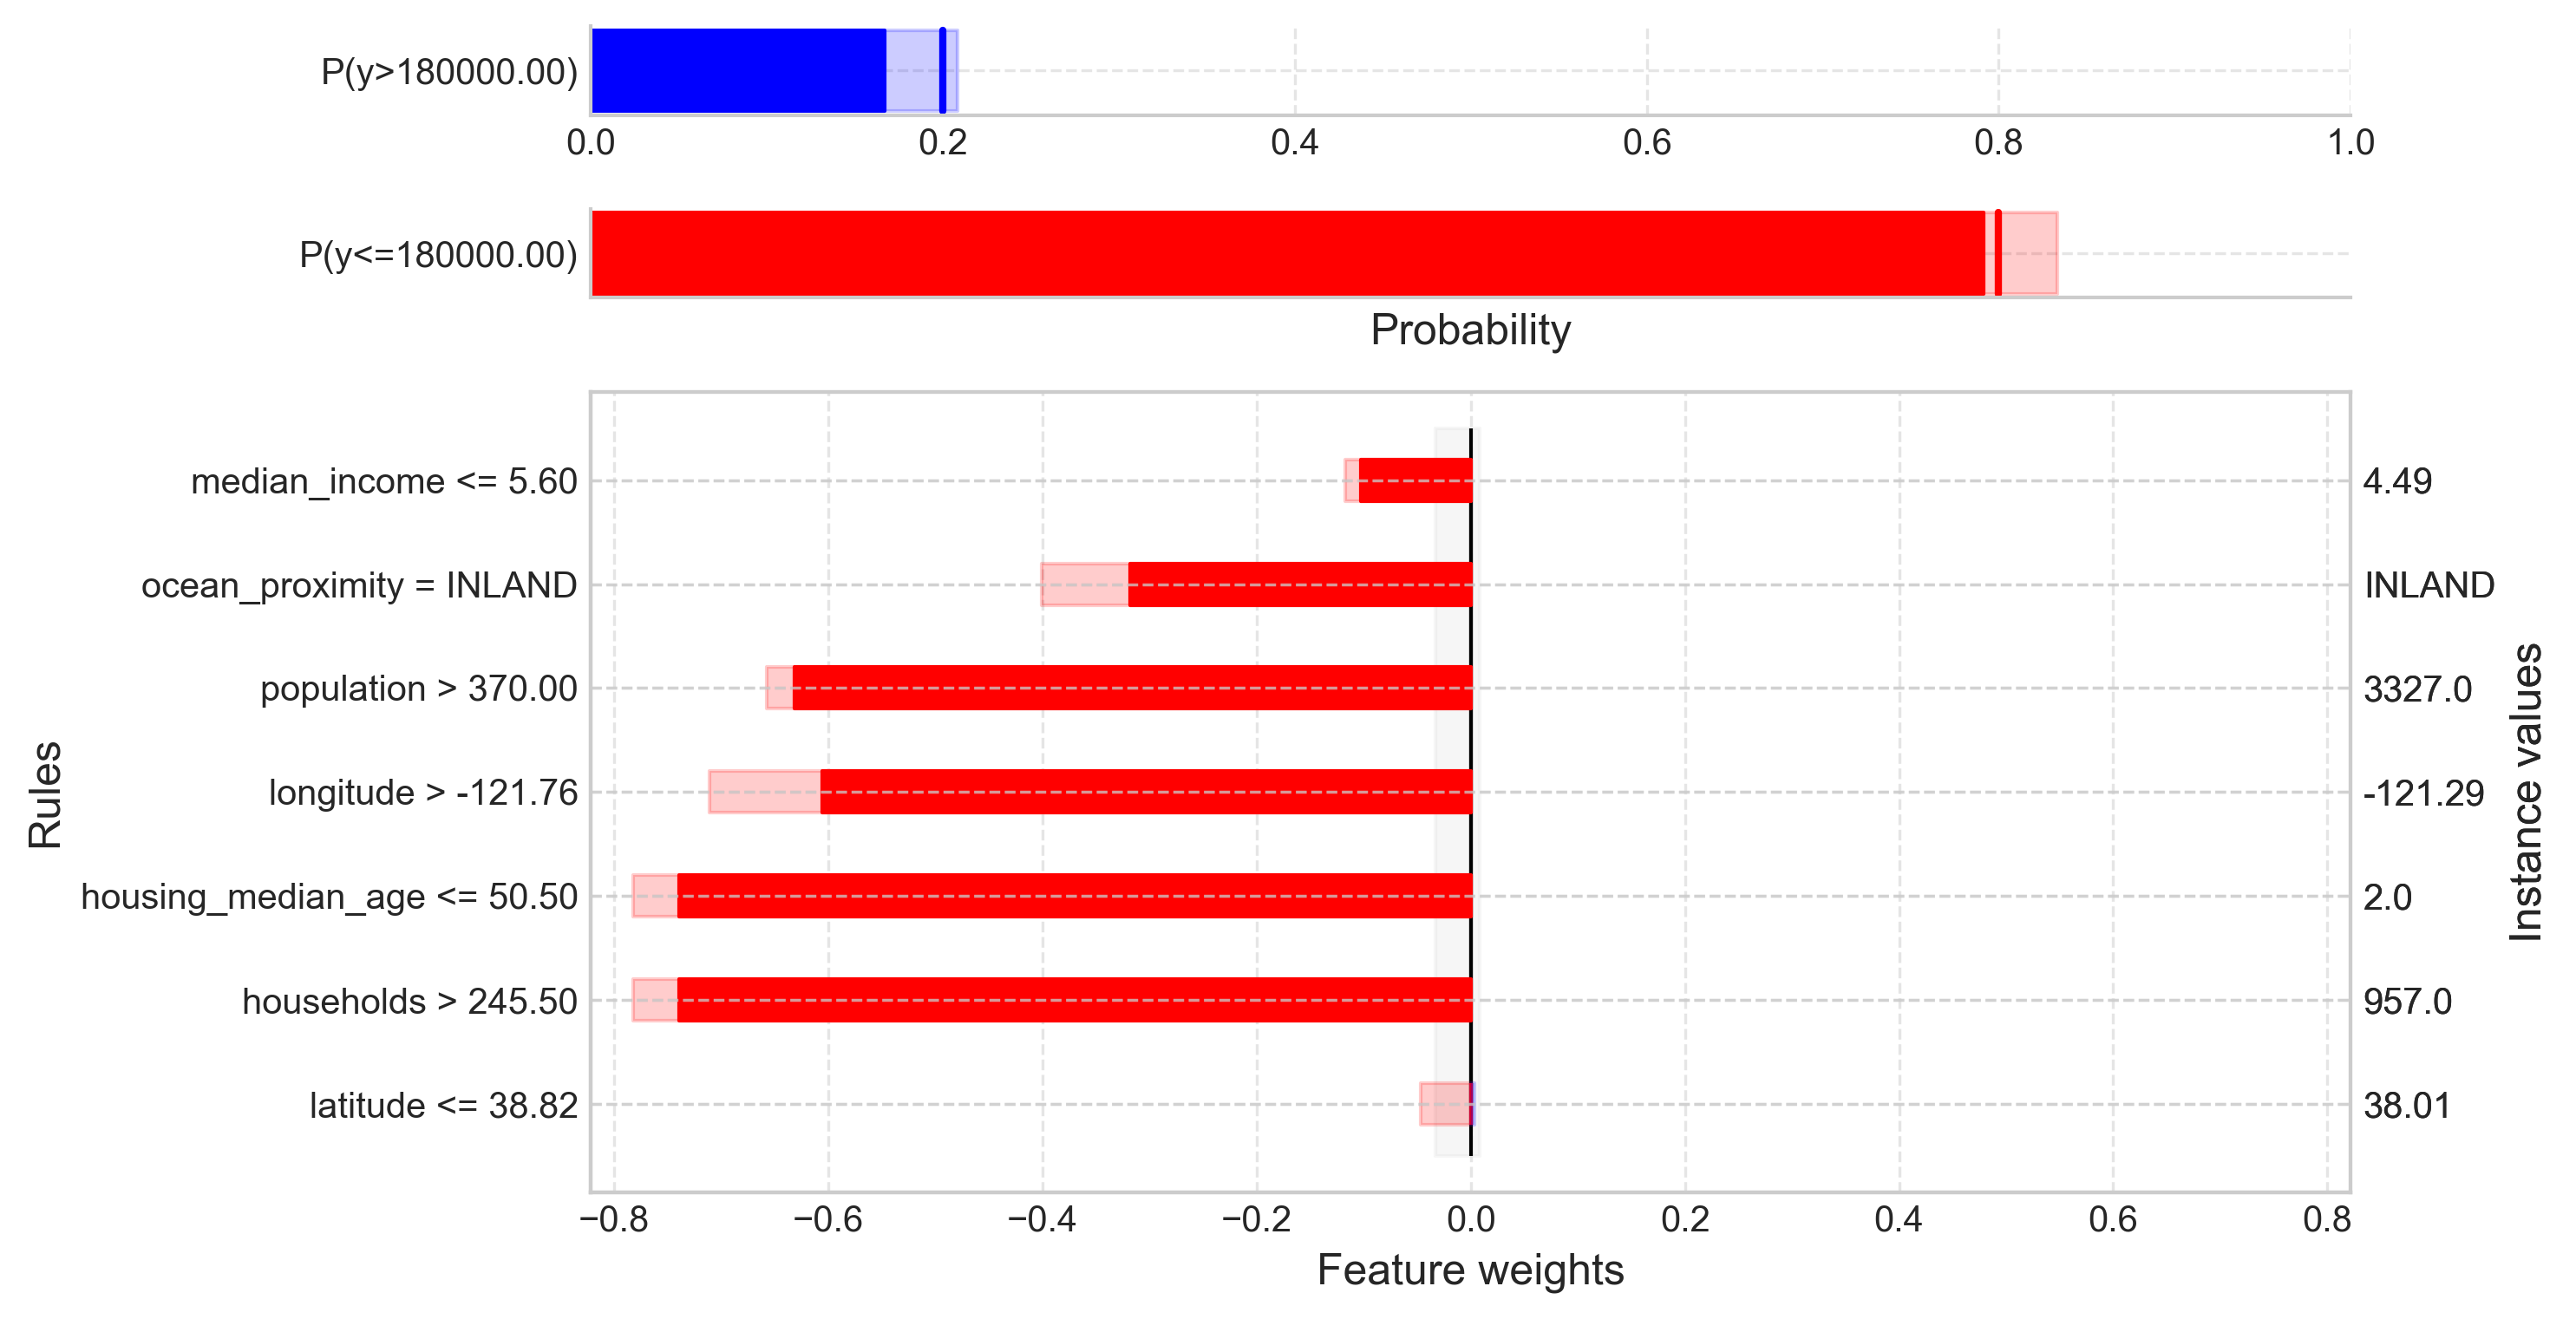

In [10]:
factual_explanation.plot(uncertainty=True)

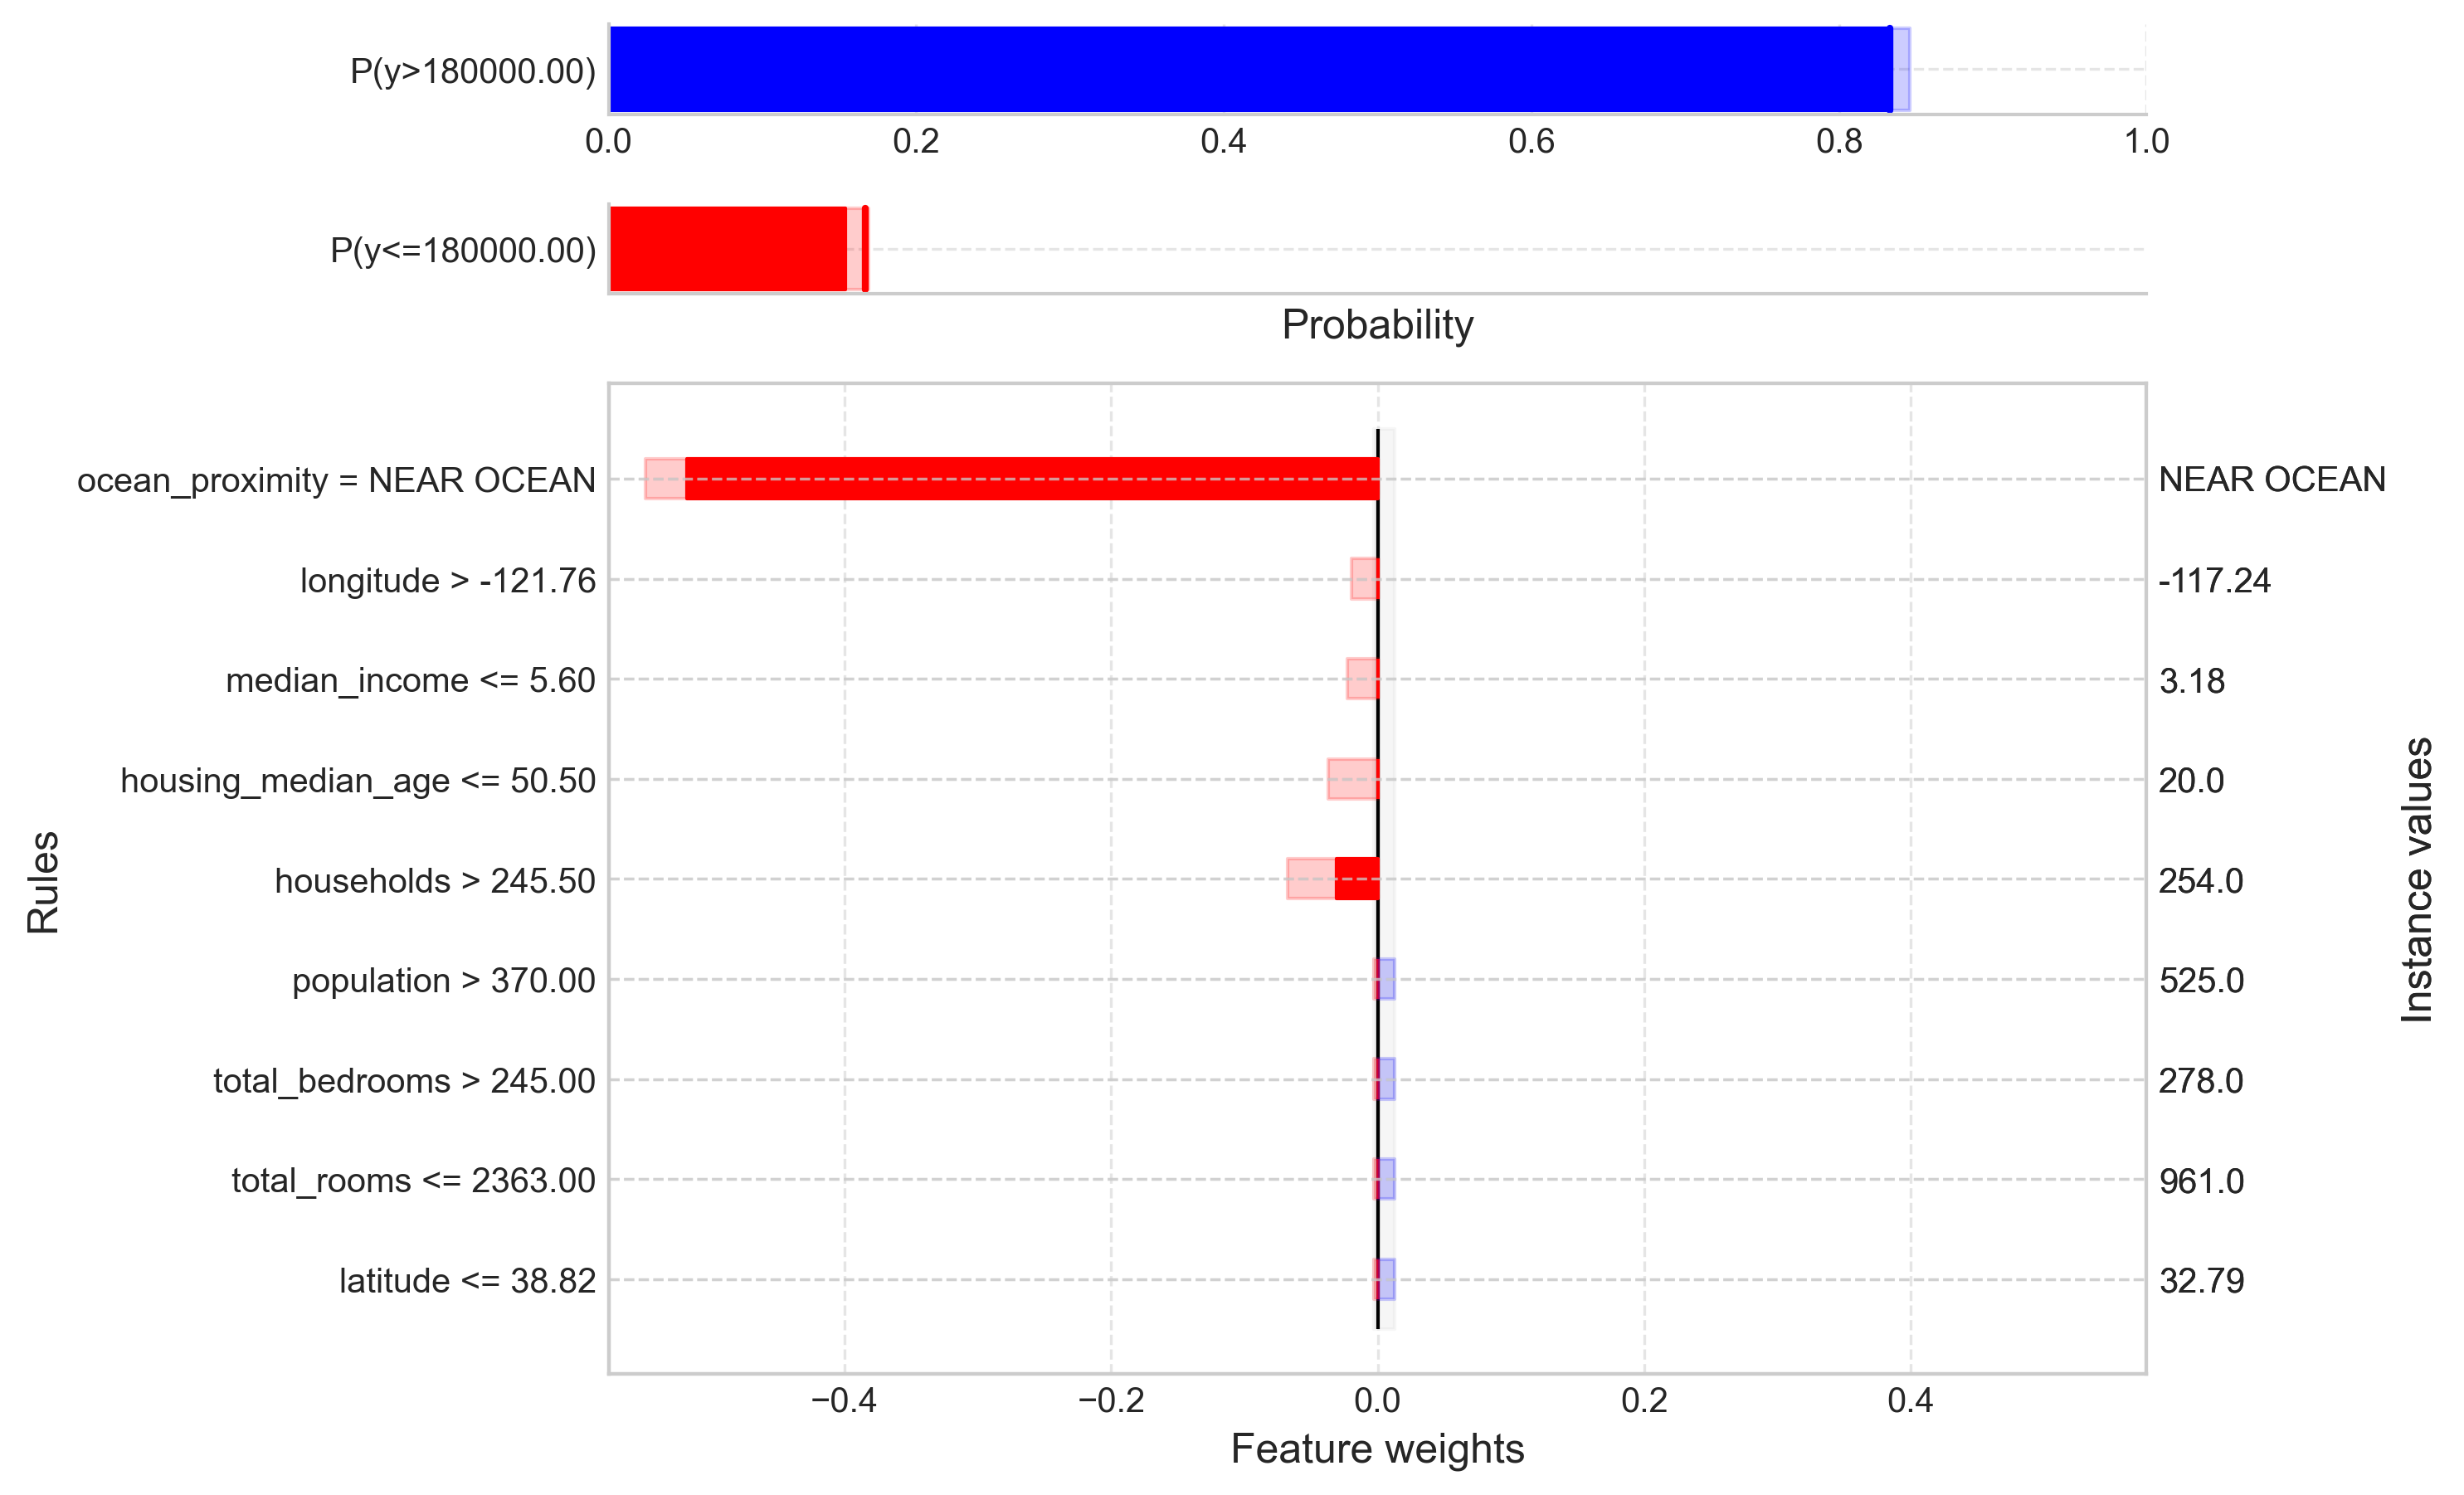

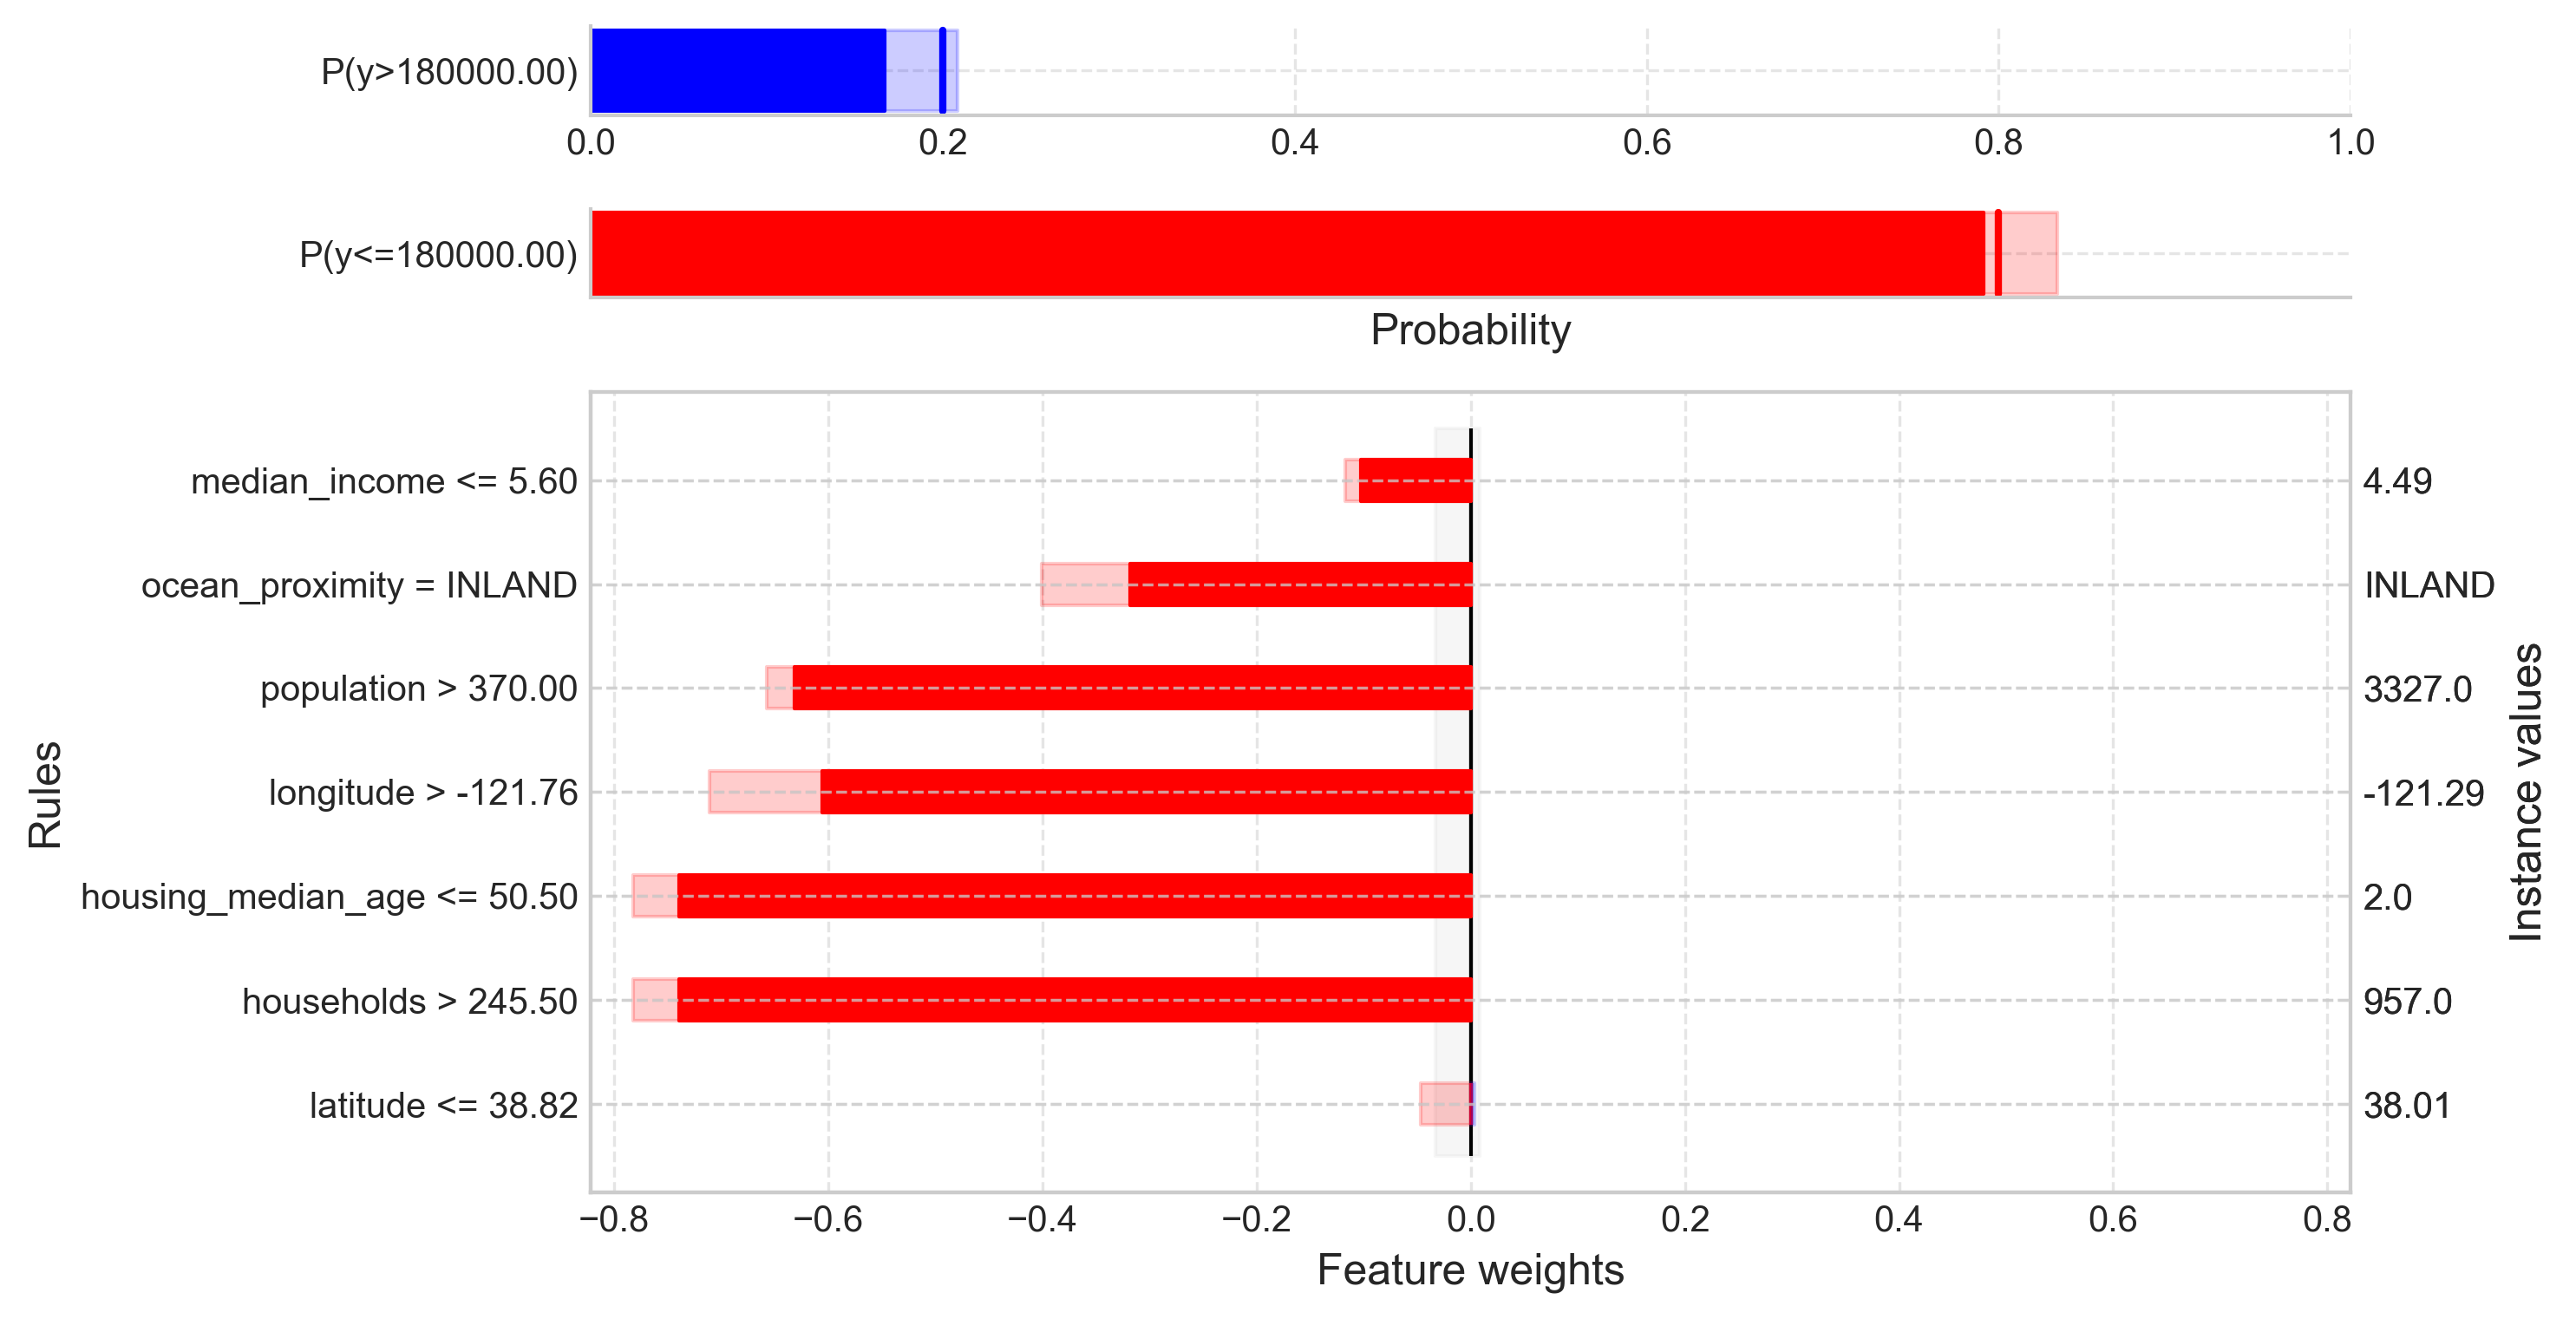

In [11]:
factual_explanation.add_conjunctions().plot(uncertainty=True)

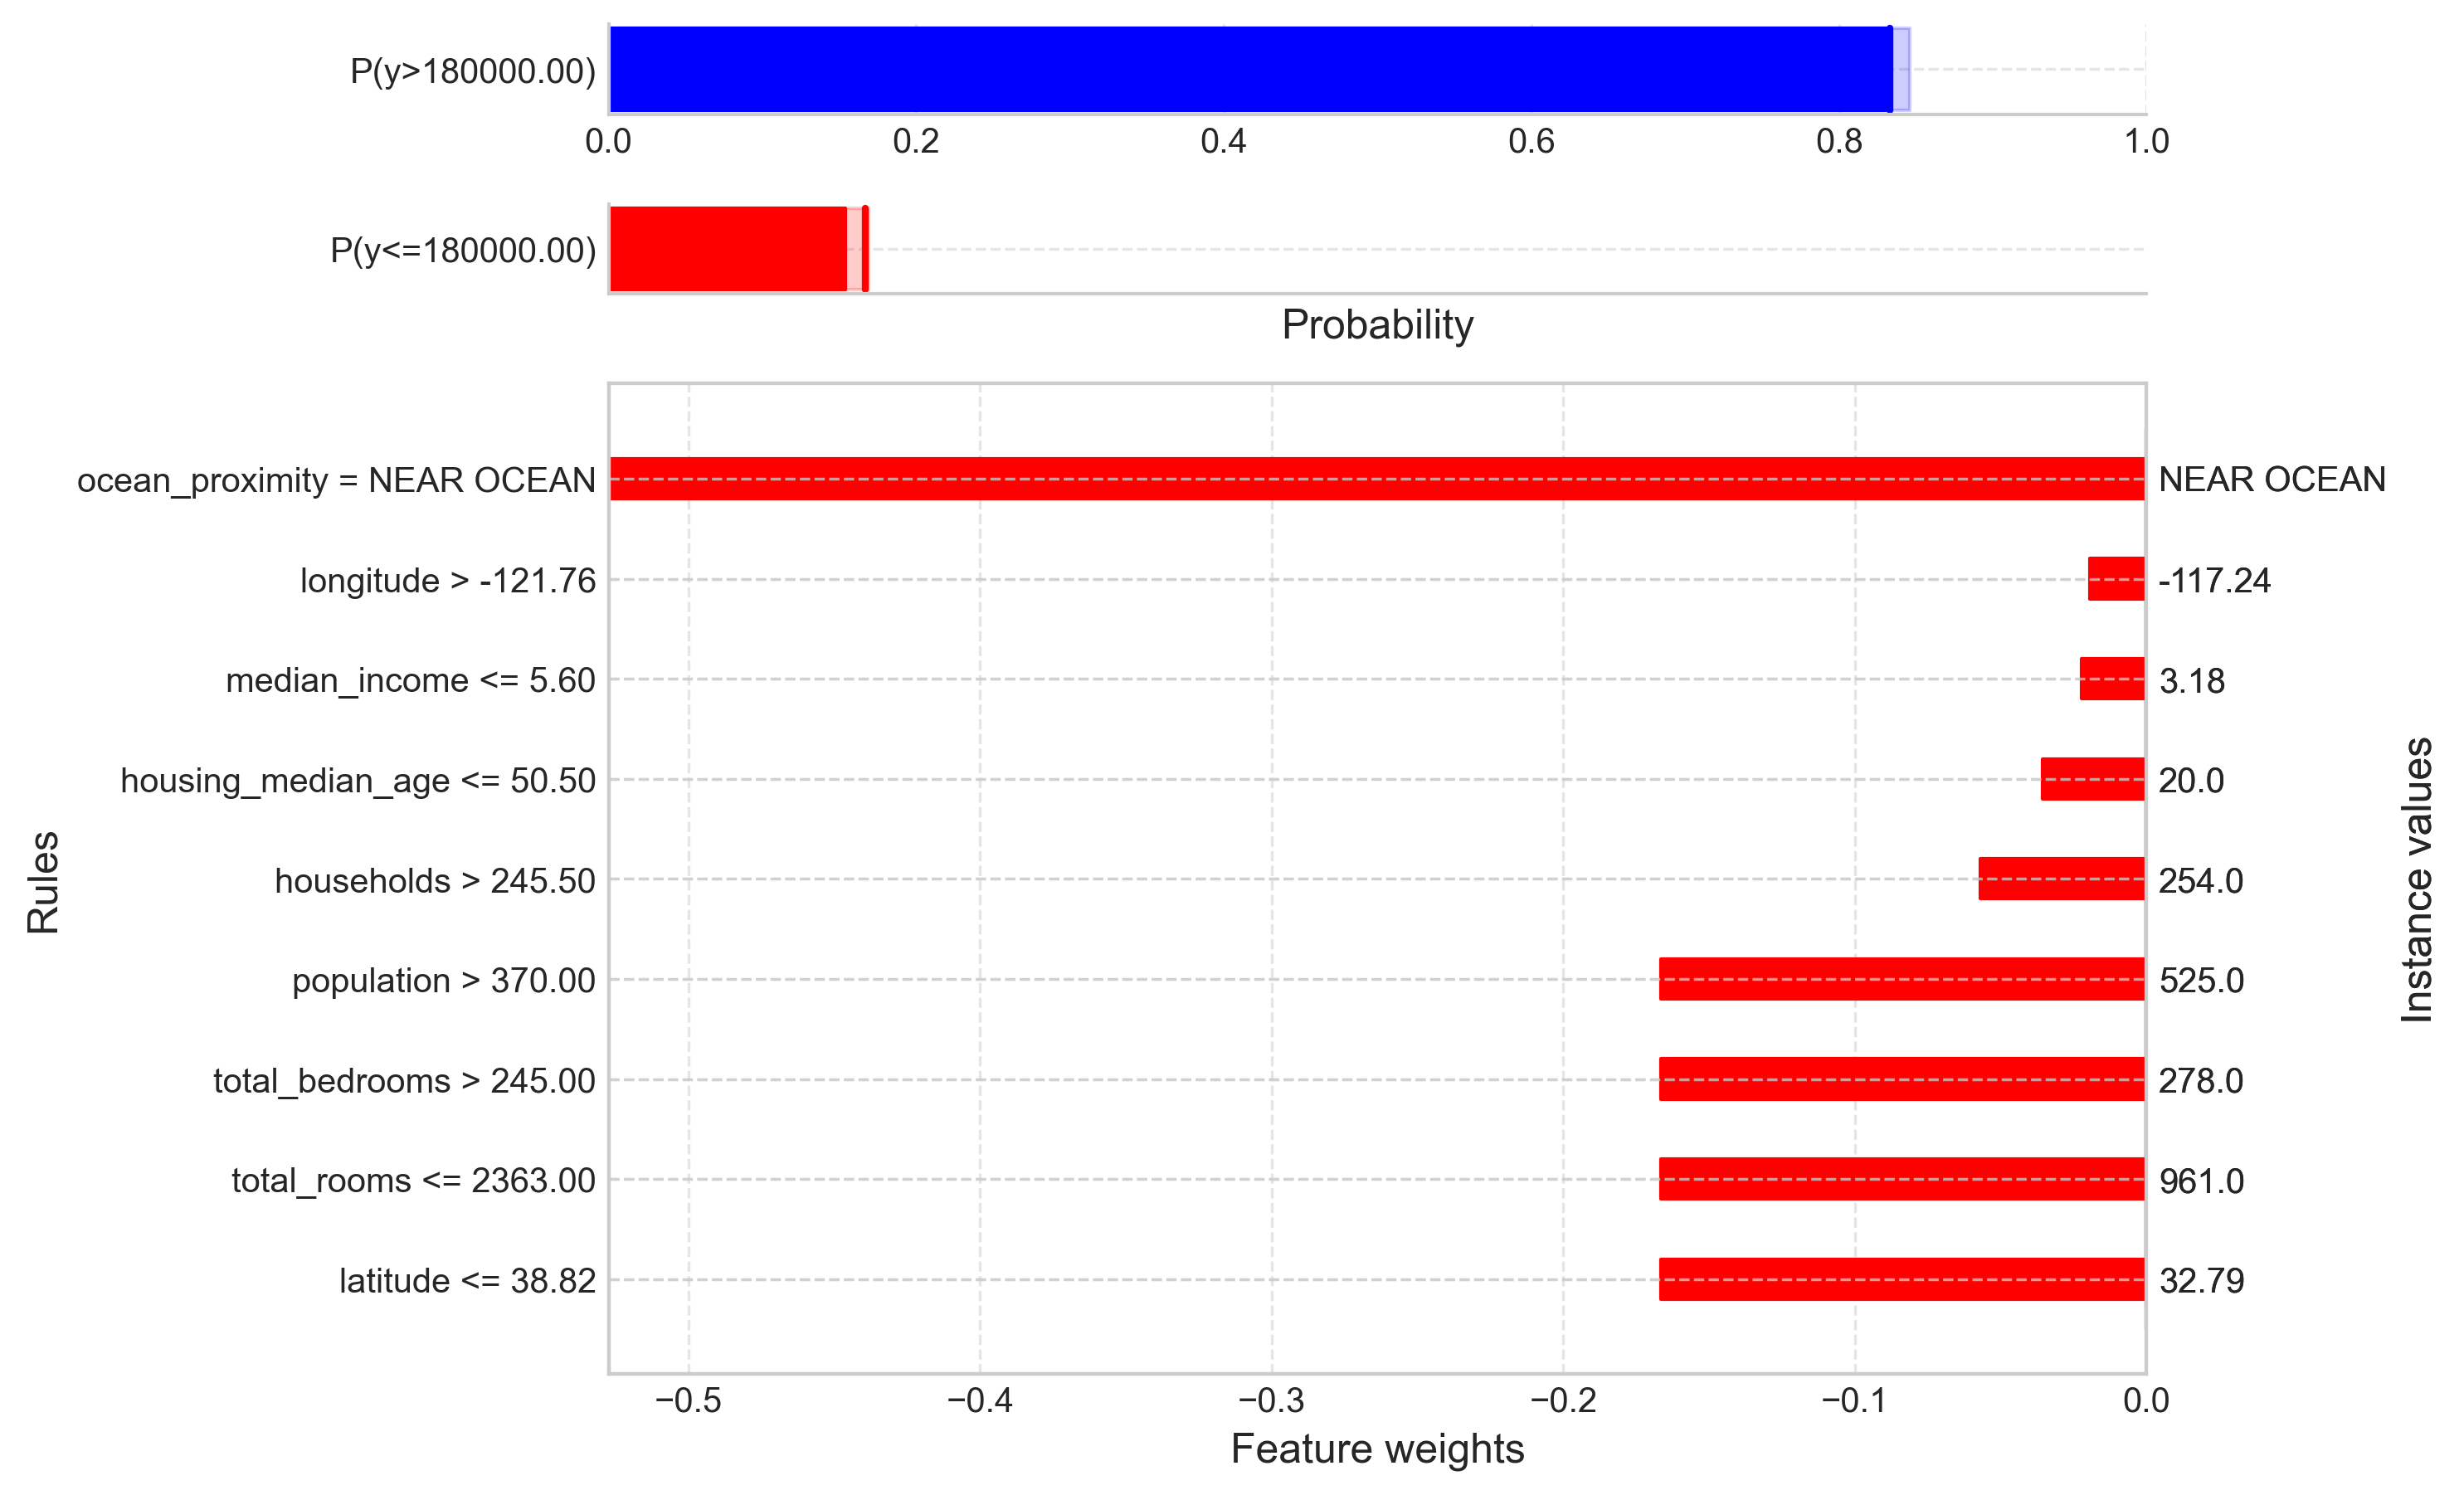

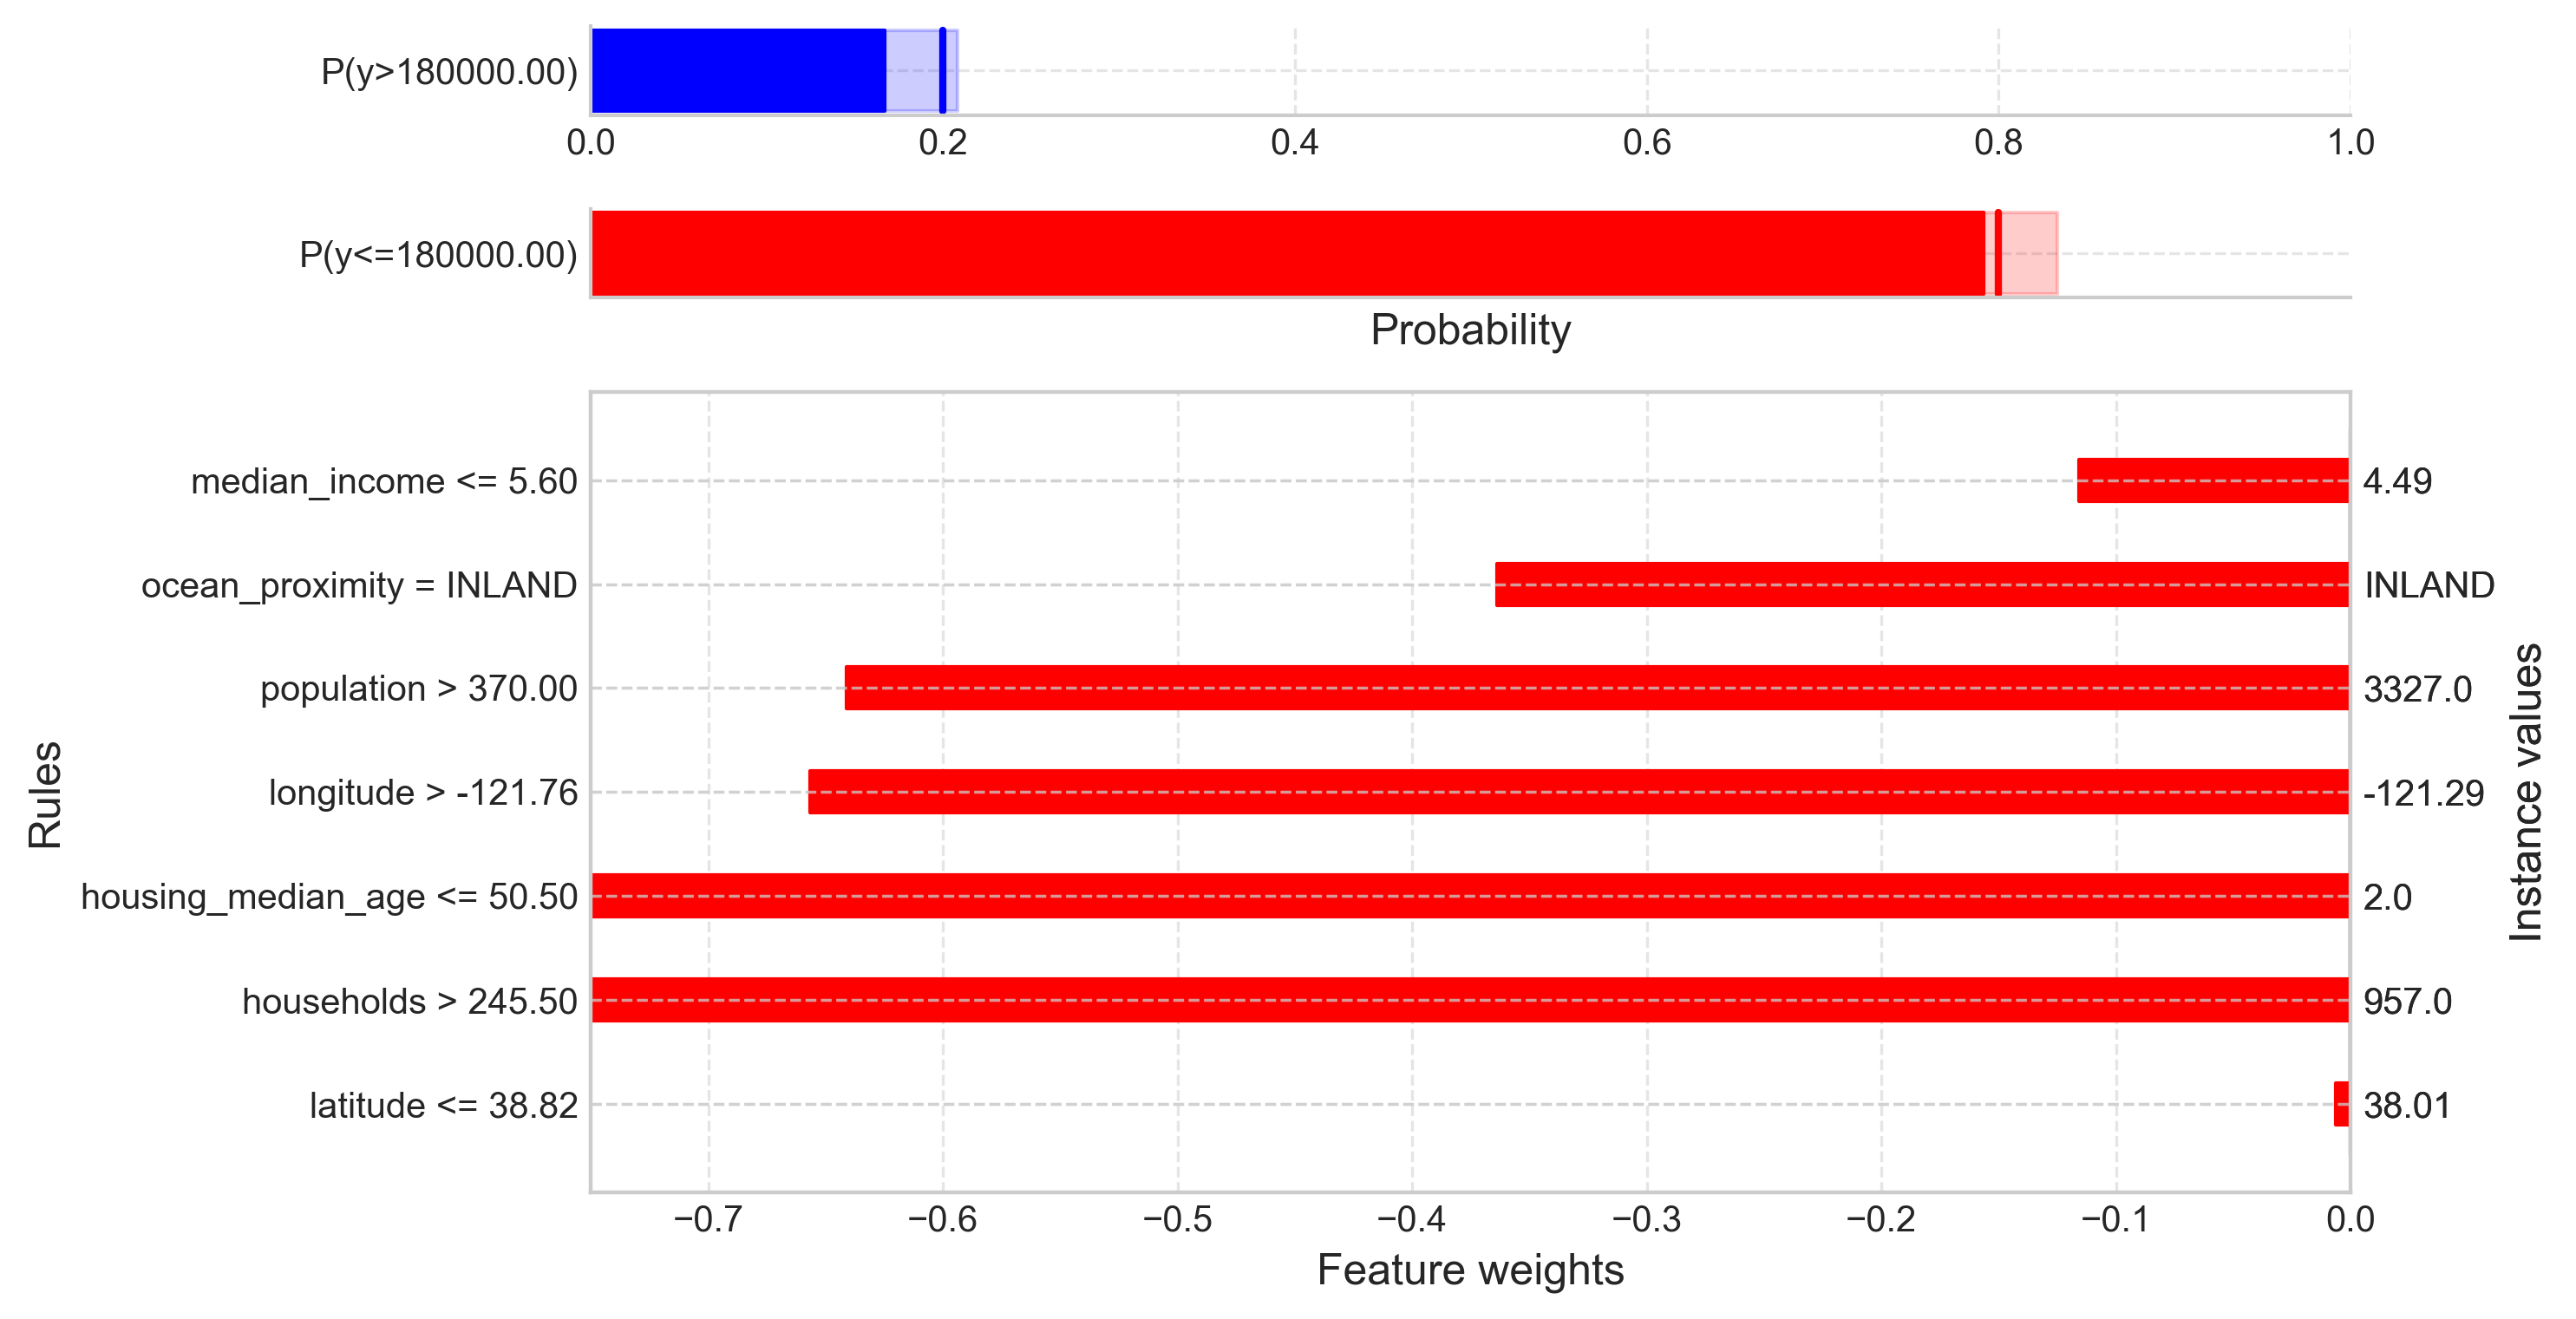

In [12]:
factual_explanation.remove_conjunctions().plot()

In [13]:
alternative_explanation = ce.explore_alternatives(X_test, 180000)

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\viz\matplotlib_adapter.py:1199: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(rect=(0, 0, 1, 0.94))


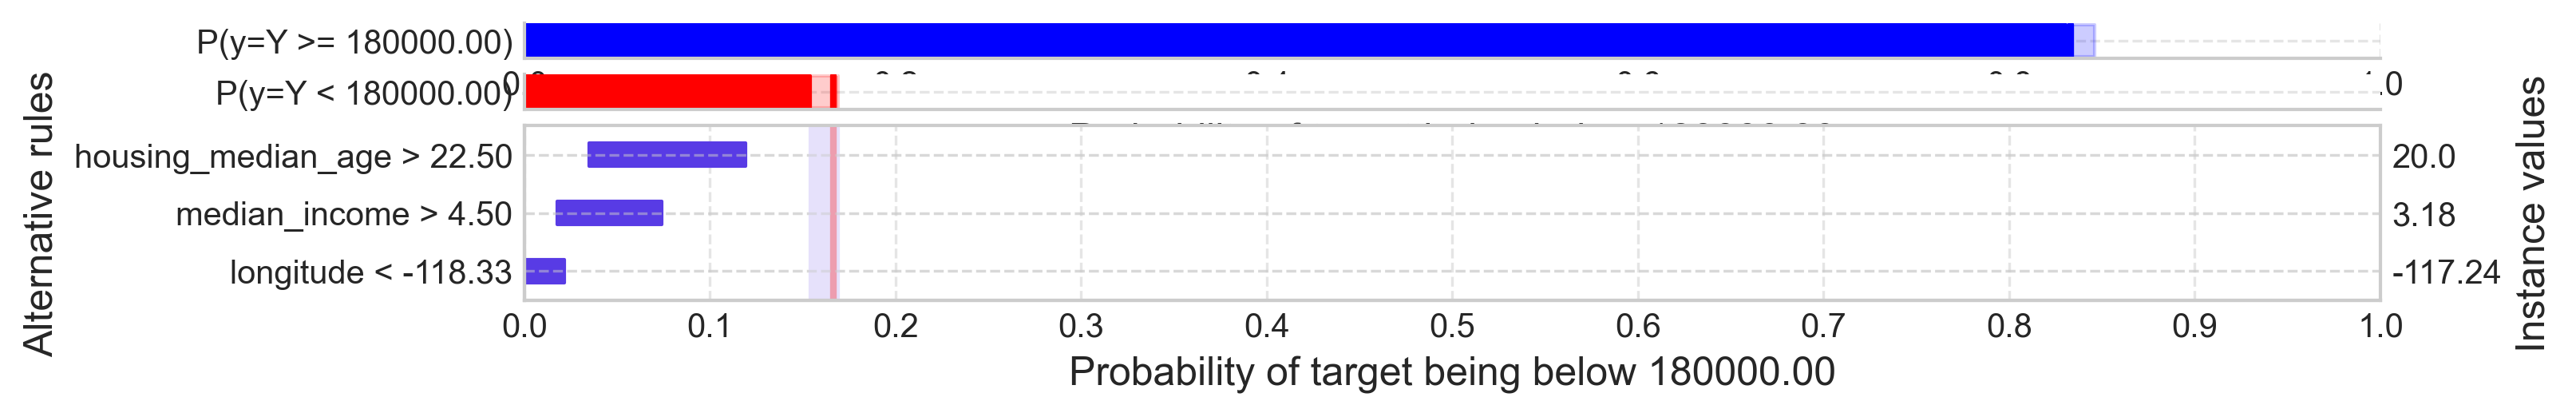

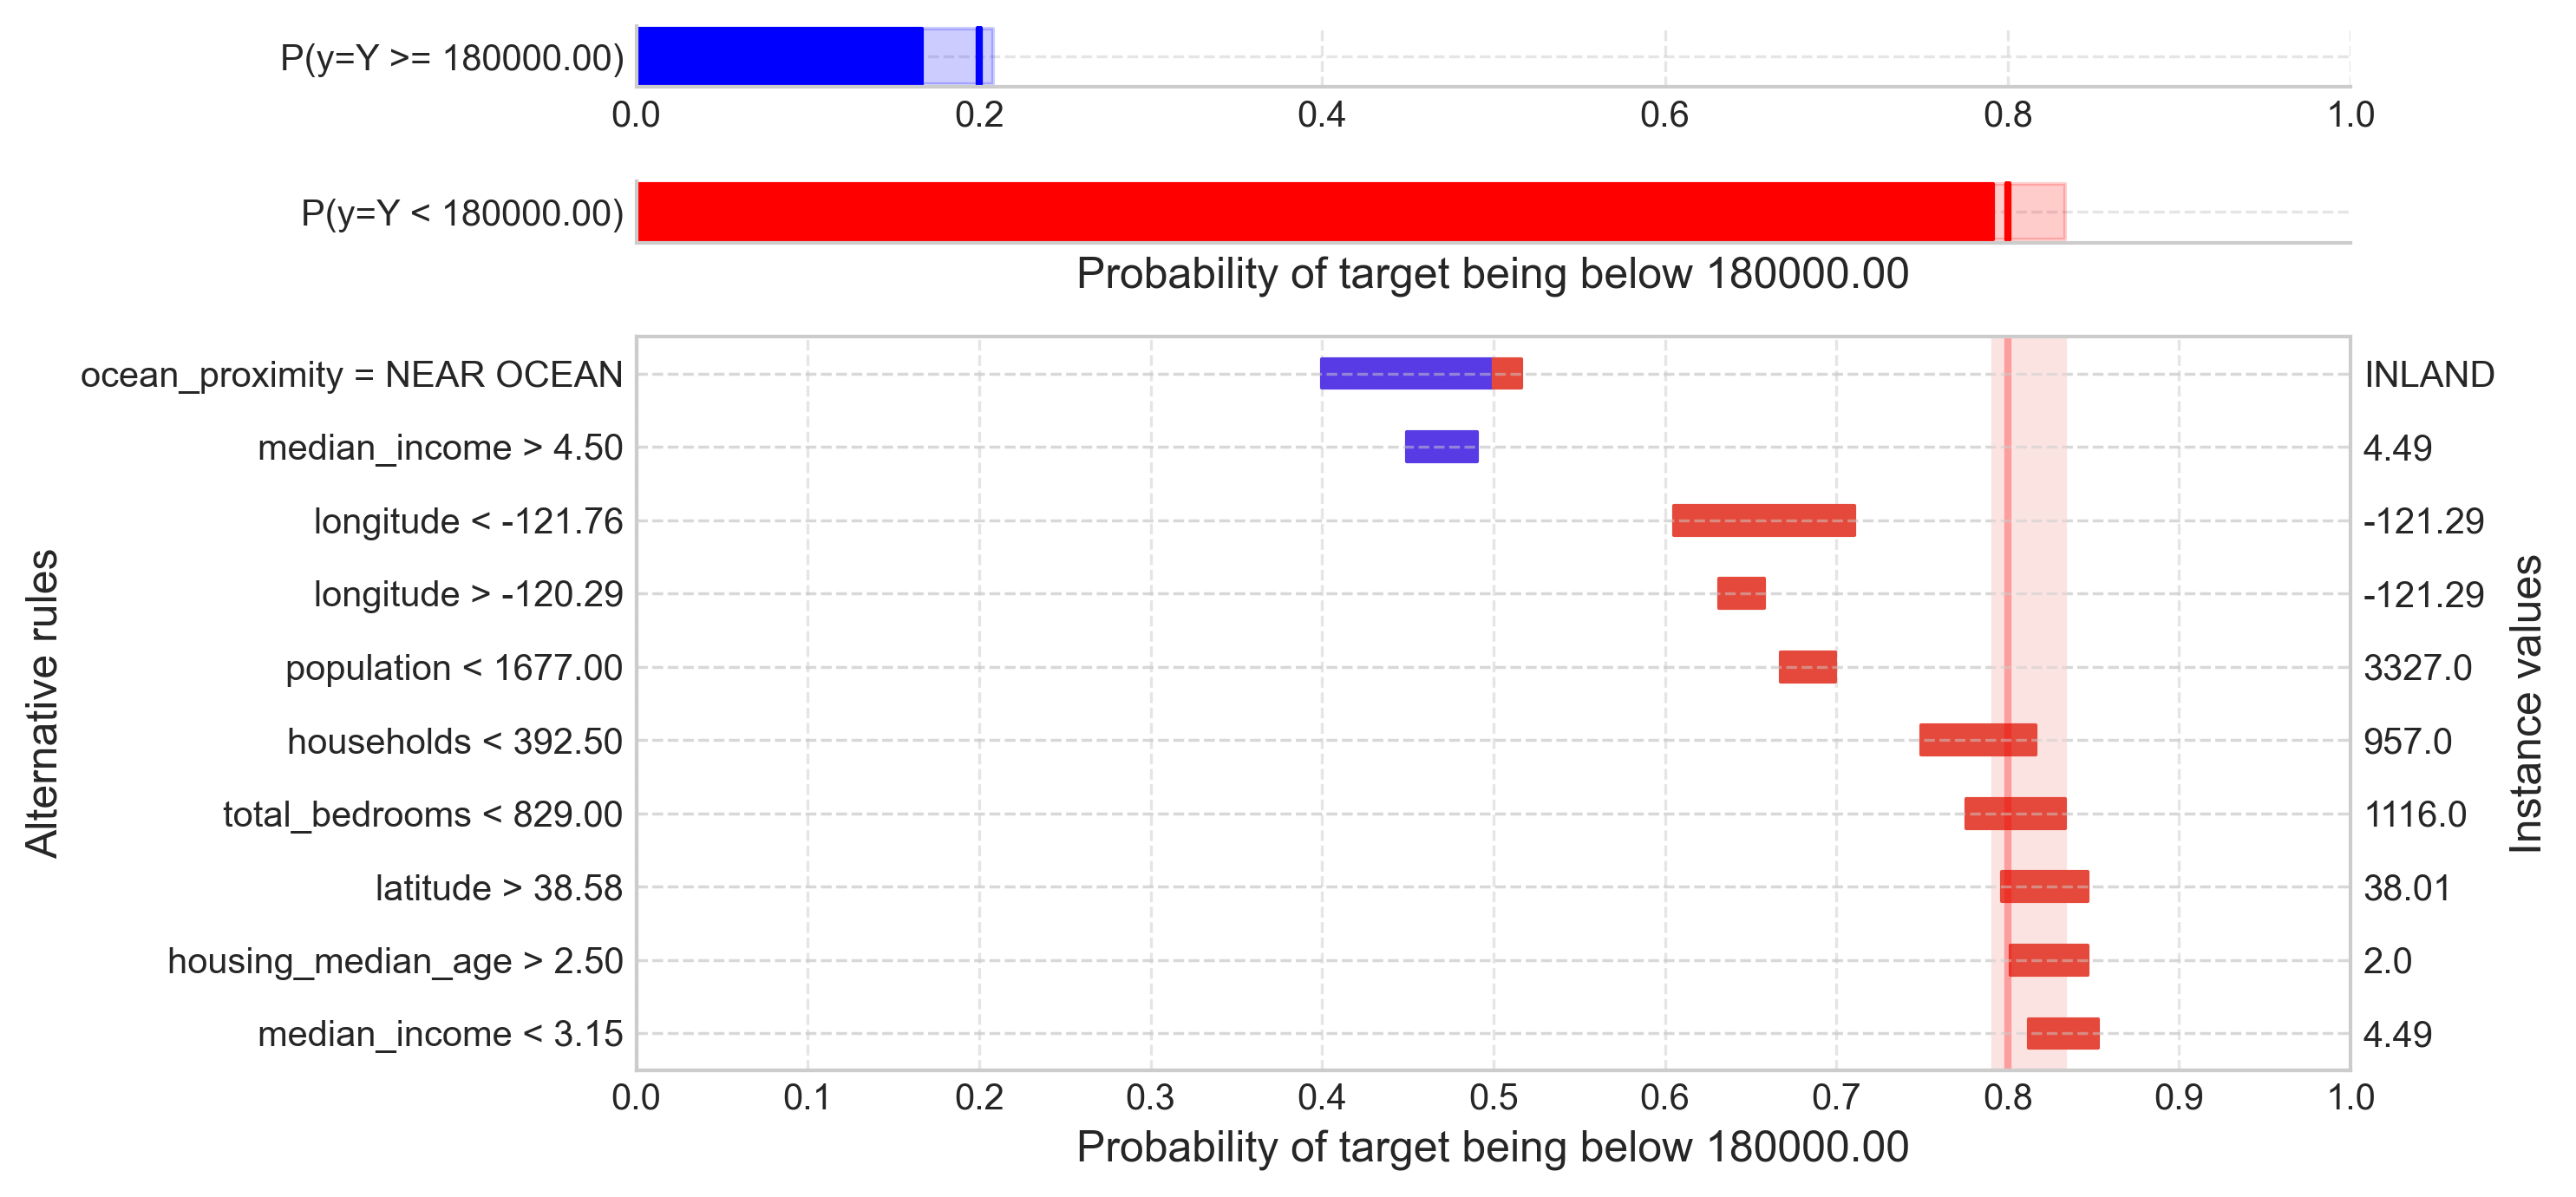

In [14]:
alternative_explanation.add_conjunctions().plot()

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\viz\matplotlib_adapter.py:1199: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(rect=(0, 0, 1, 0.94))


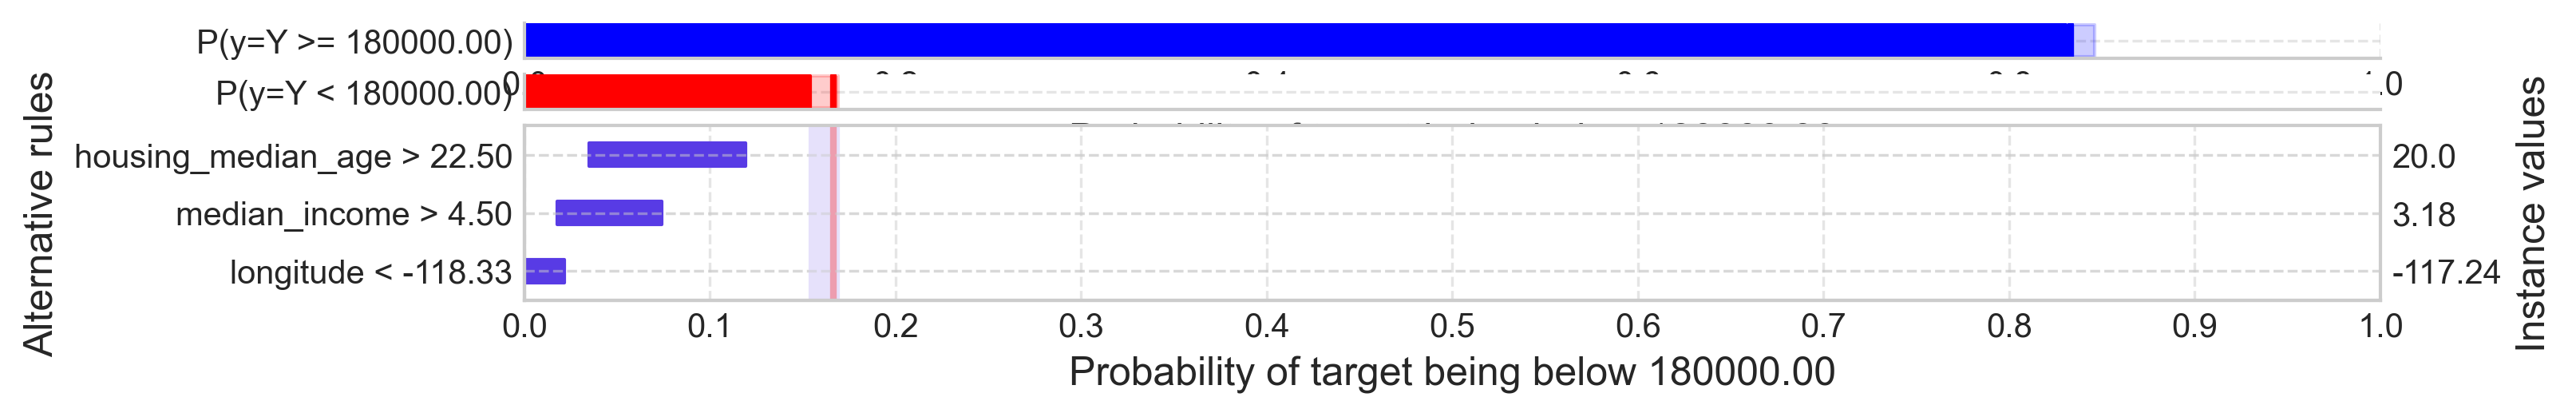

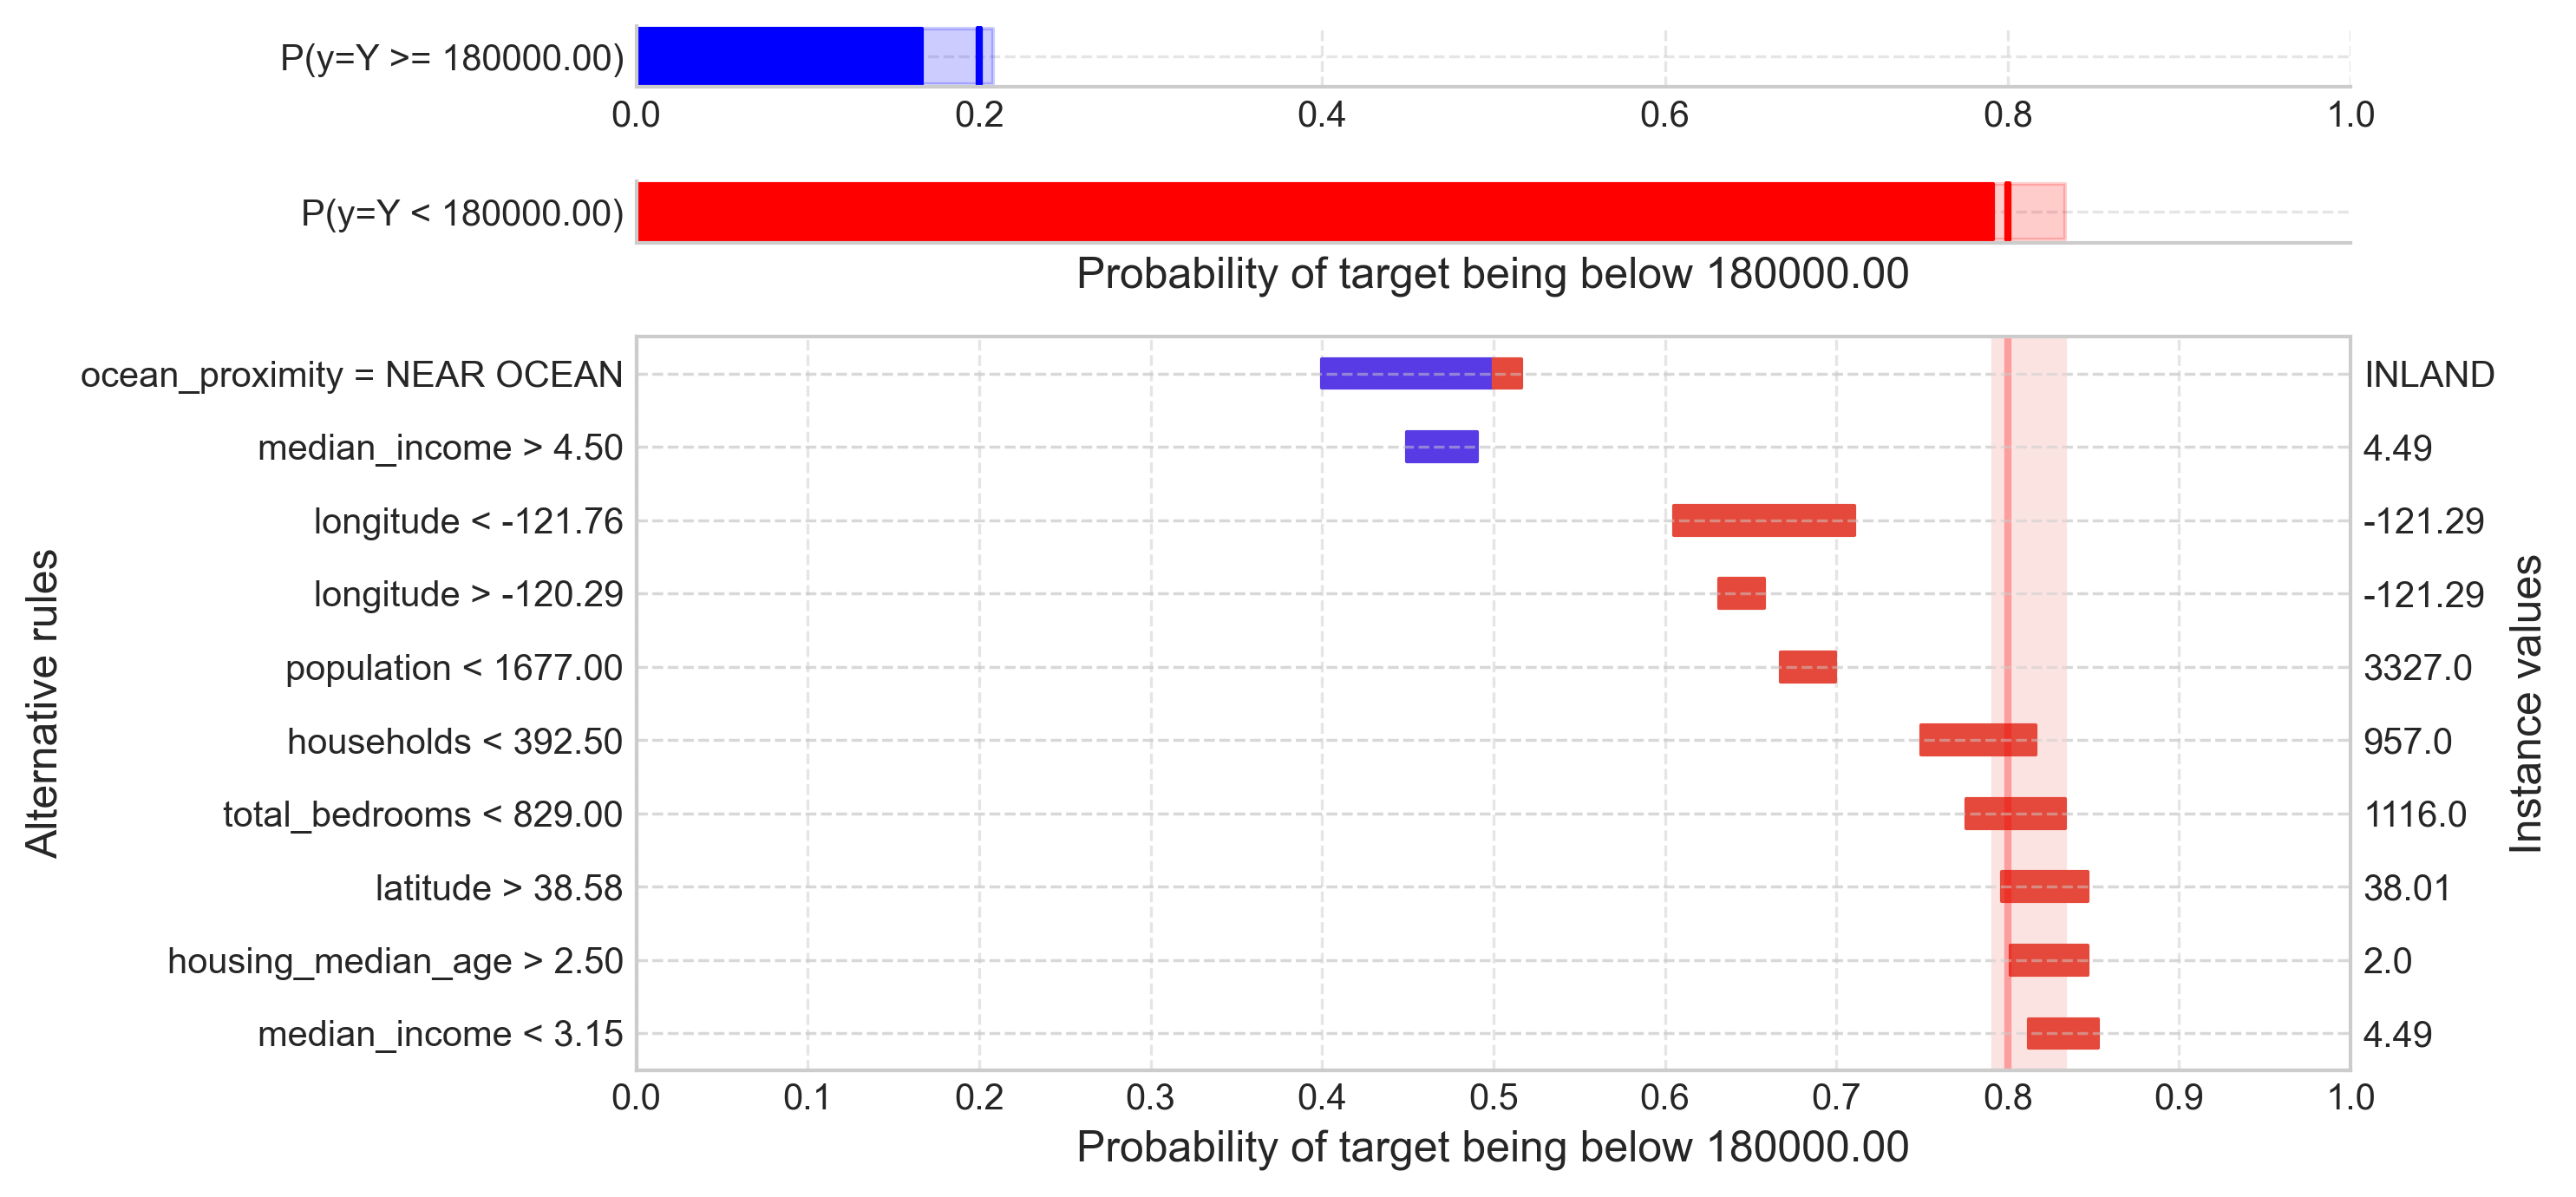

In [15]:
alternative_explanation.remove_conjunctions().plot()

#### Normalized explanations using knn

There are three ways to set the difficulty estimator (sigma) for the CalibratedExplainer when using k-nearest neighbor.
* alternative 1: by the (Euclidean) distances to the nearest neighbors
* alternative 2: by the standard deviation of the targets of the nearest neighbors
* alternative 3: by the absolute errors of the k nearest neighbors

See the documentation of crepes for further details, see [here](https://crepes.readthedocs.io/en/latest/).

In [16]:
# alternative 1: by the (Euclidean) distances to the nearest neighbors
ce.set_difficulty_estimator(DifficultyEstimator().fit(X=X_prop_train, scaler=True))

# alternative 2: by the standard deviation of the targets of the nearest neighbors
ce.set_difficulty_estimator(DifficultyEstimator().fit(X=X_prop_train, y=y_prop_train, scaler=True))

# alternative 3: by the absolute errors of the k nearest neighbors
oob_predictions = model.oob_prediction_  # requires the model to have been trained with oob_score=True, available for RandomForestRegressor
residuals_oob = y_prop_train - oob_predictions
ce.set_difficulty_estimator(
    DifficultyEstimator().fit(X=X_prop_train, residuals=residuals_oob, scaler=True)
)

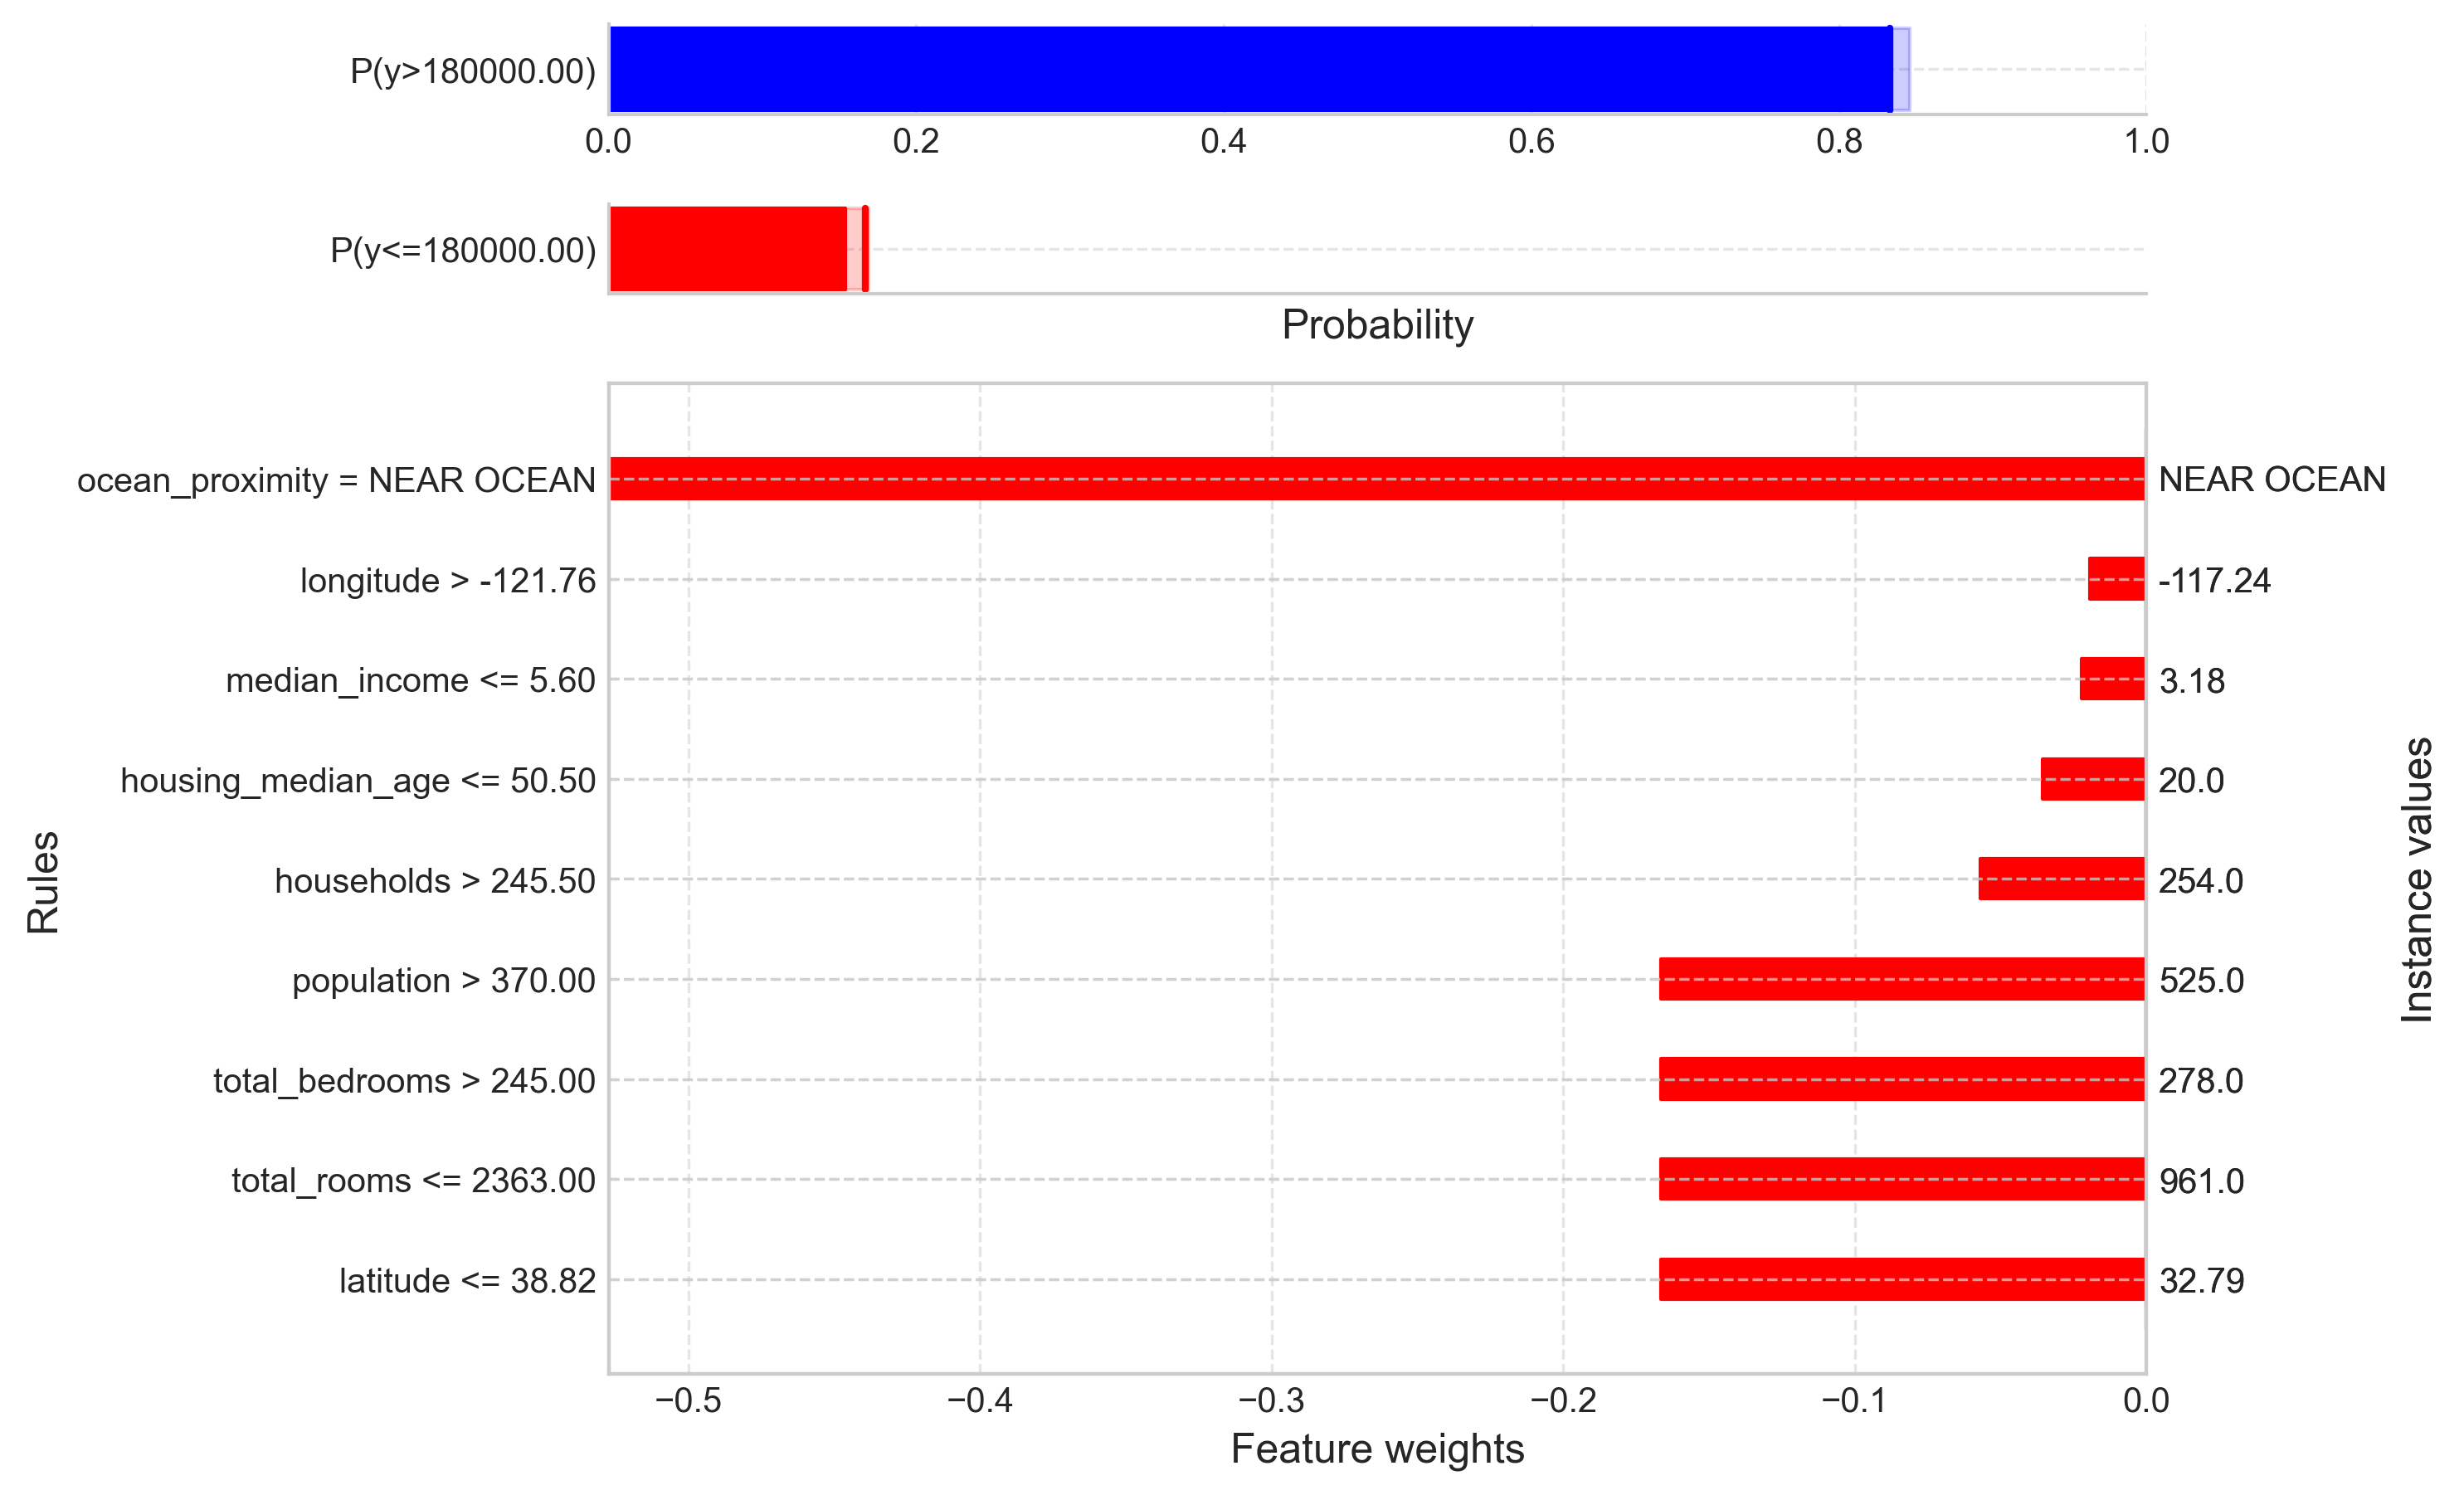

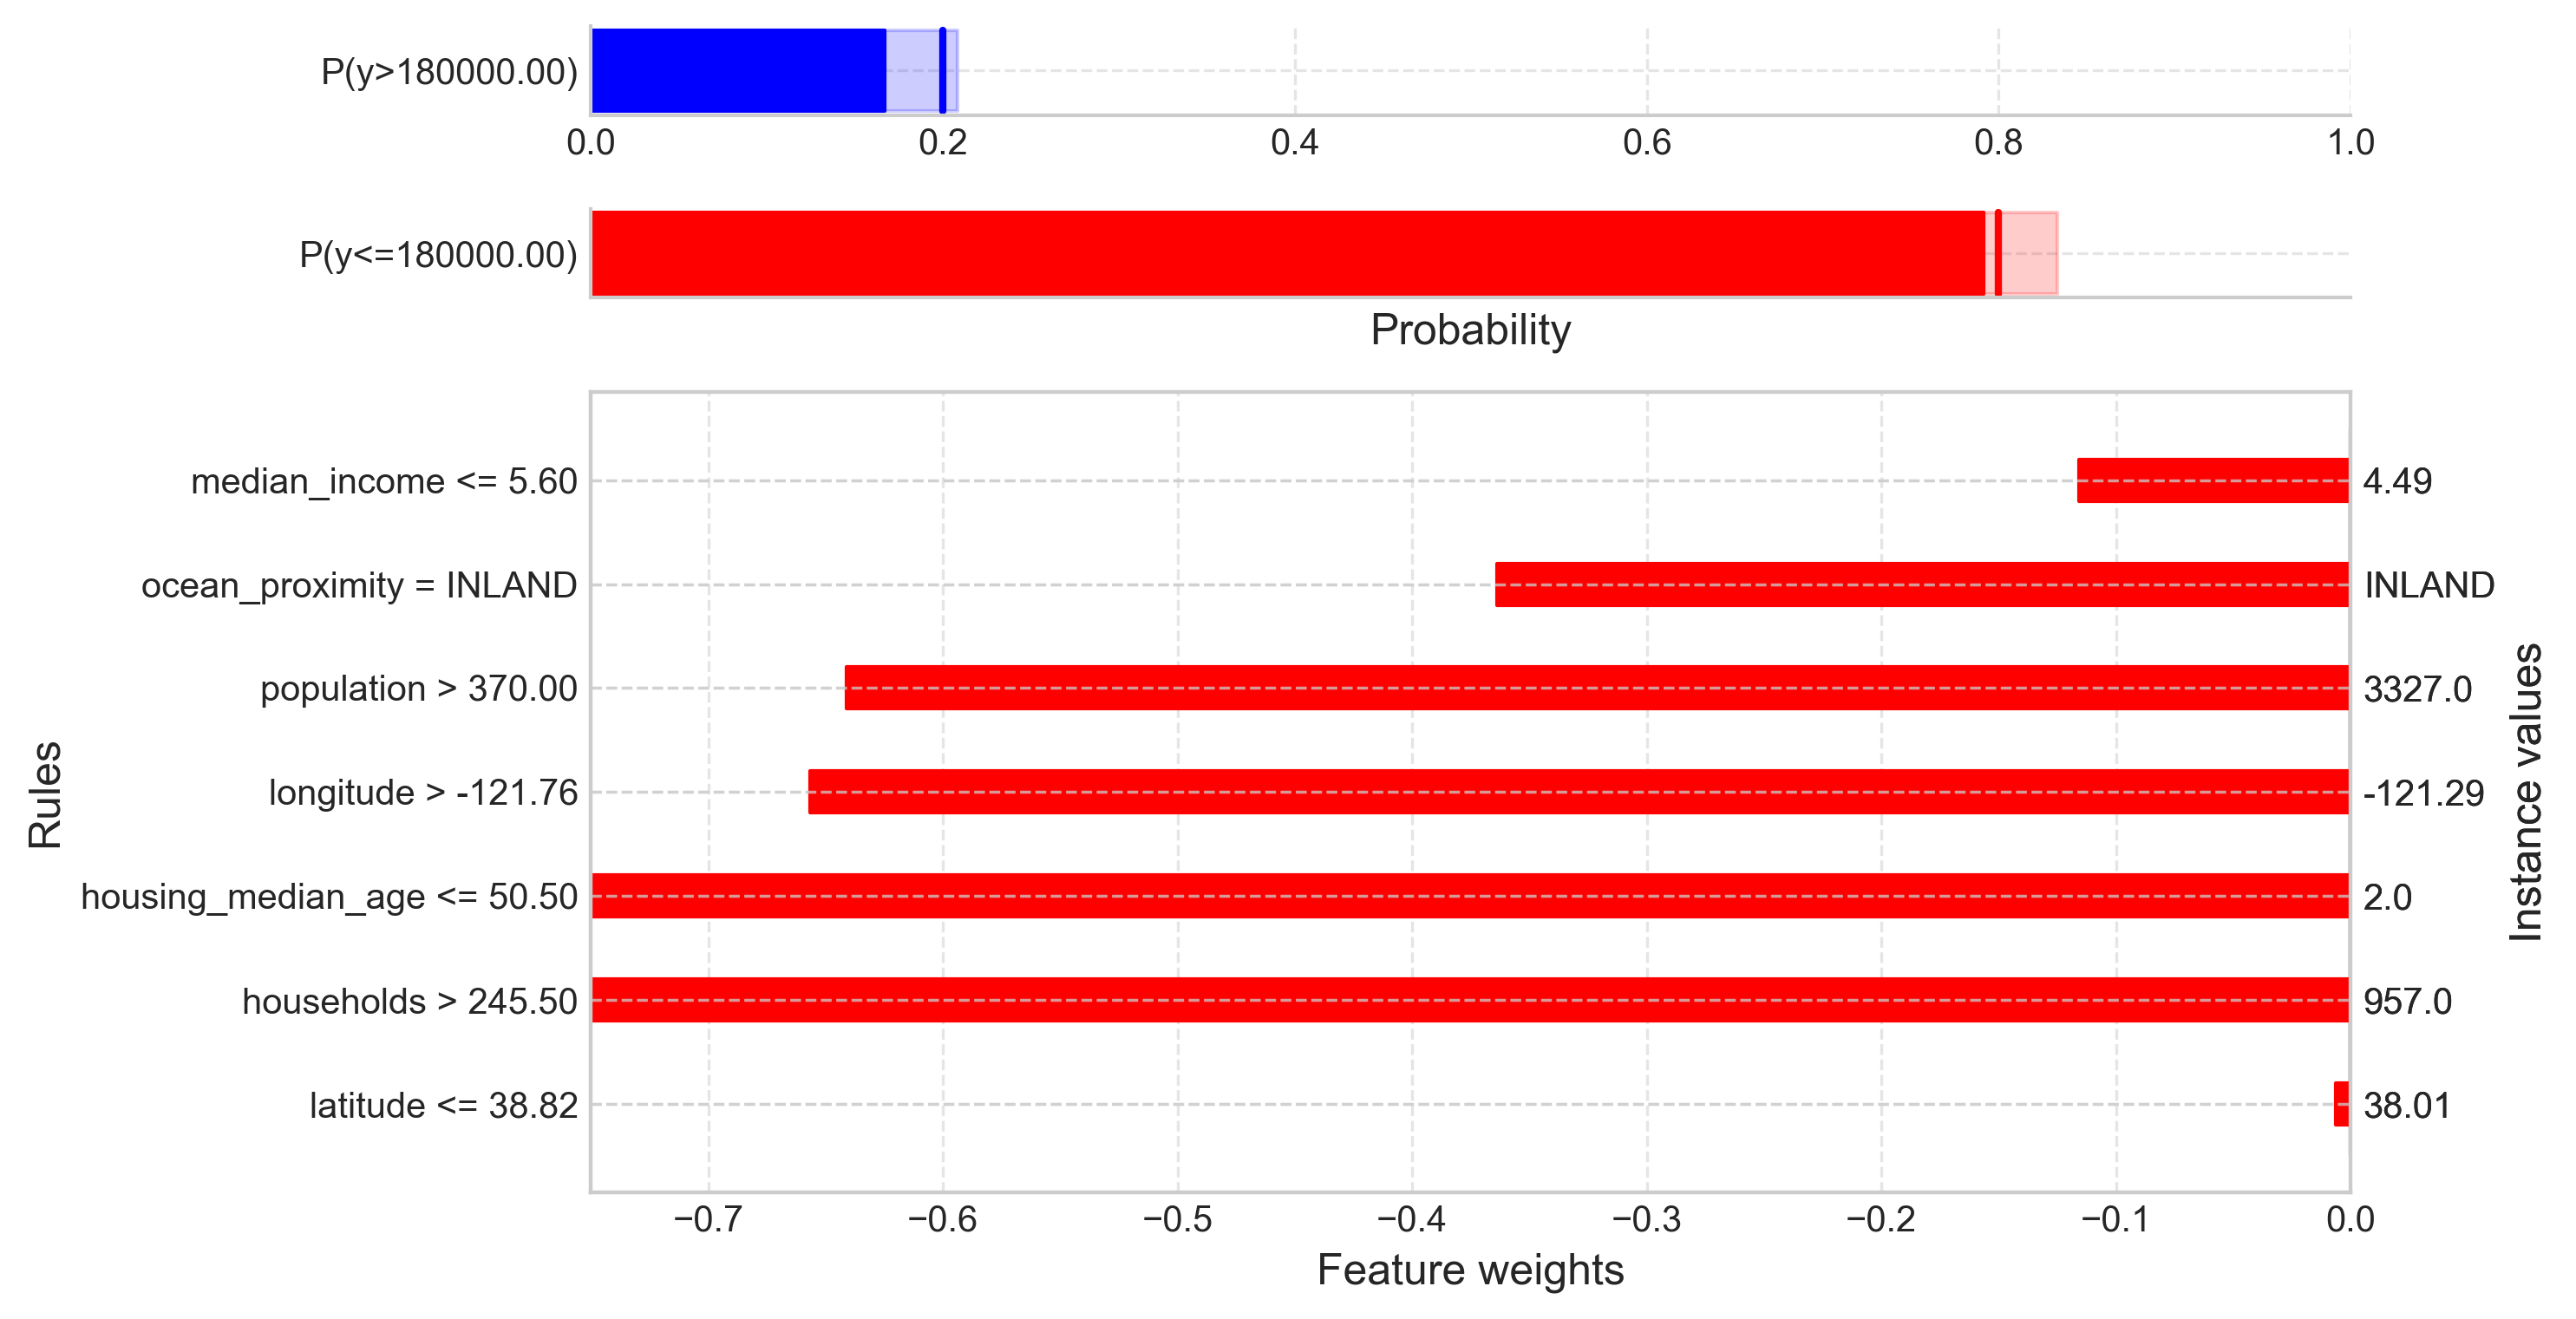

In [17]:
factual_explanation = ce.explain_factual(X_test, 180000)

factual_explanation.add_conjunctions(n_top_features=5).plot(filter_top=15)

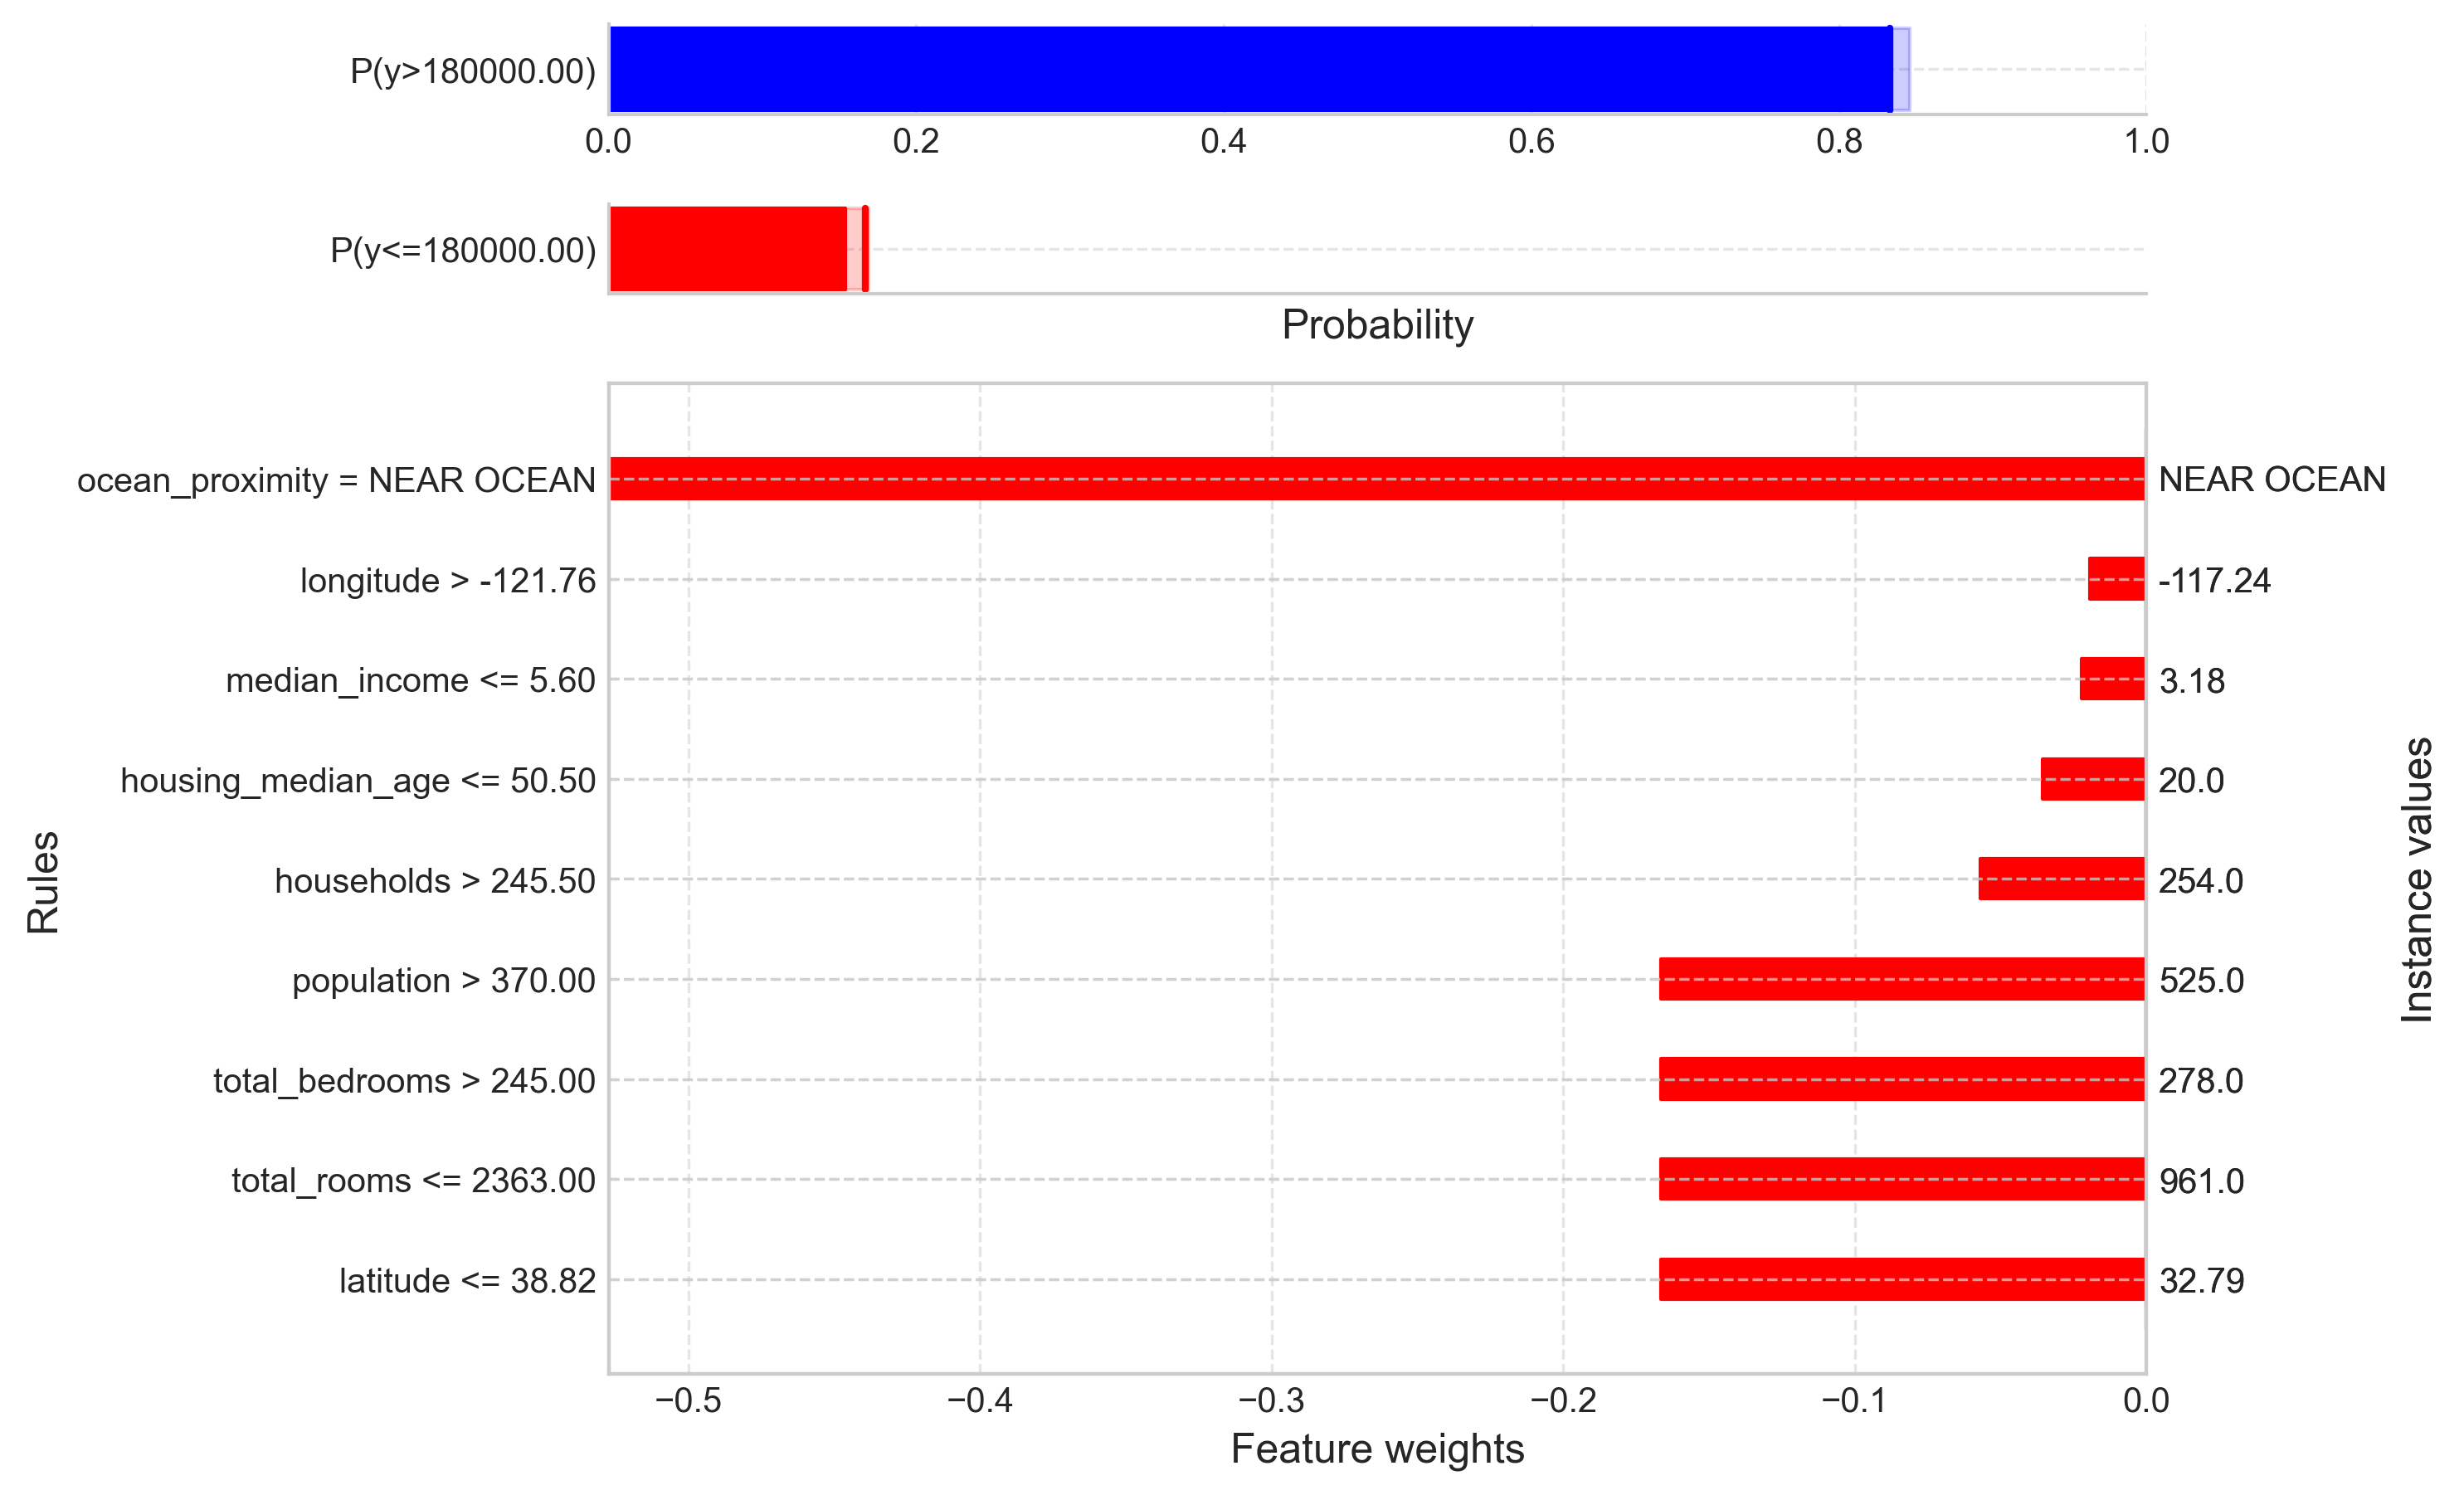

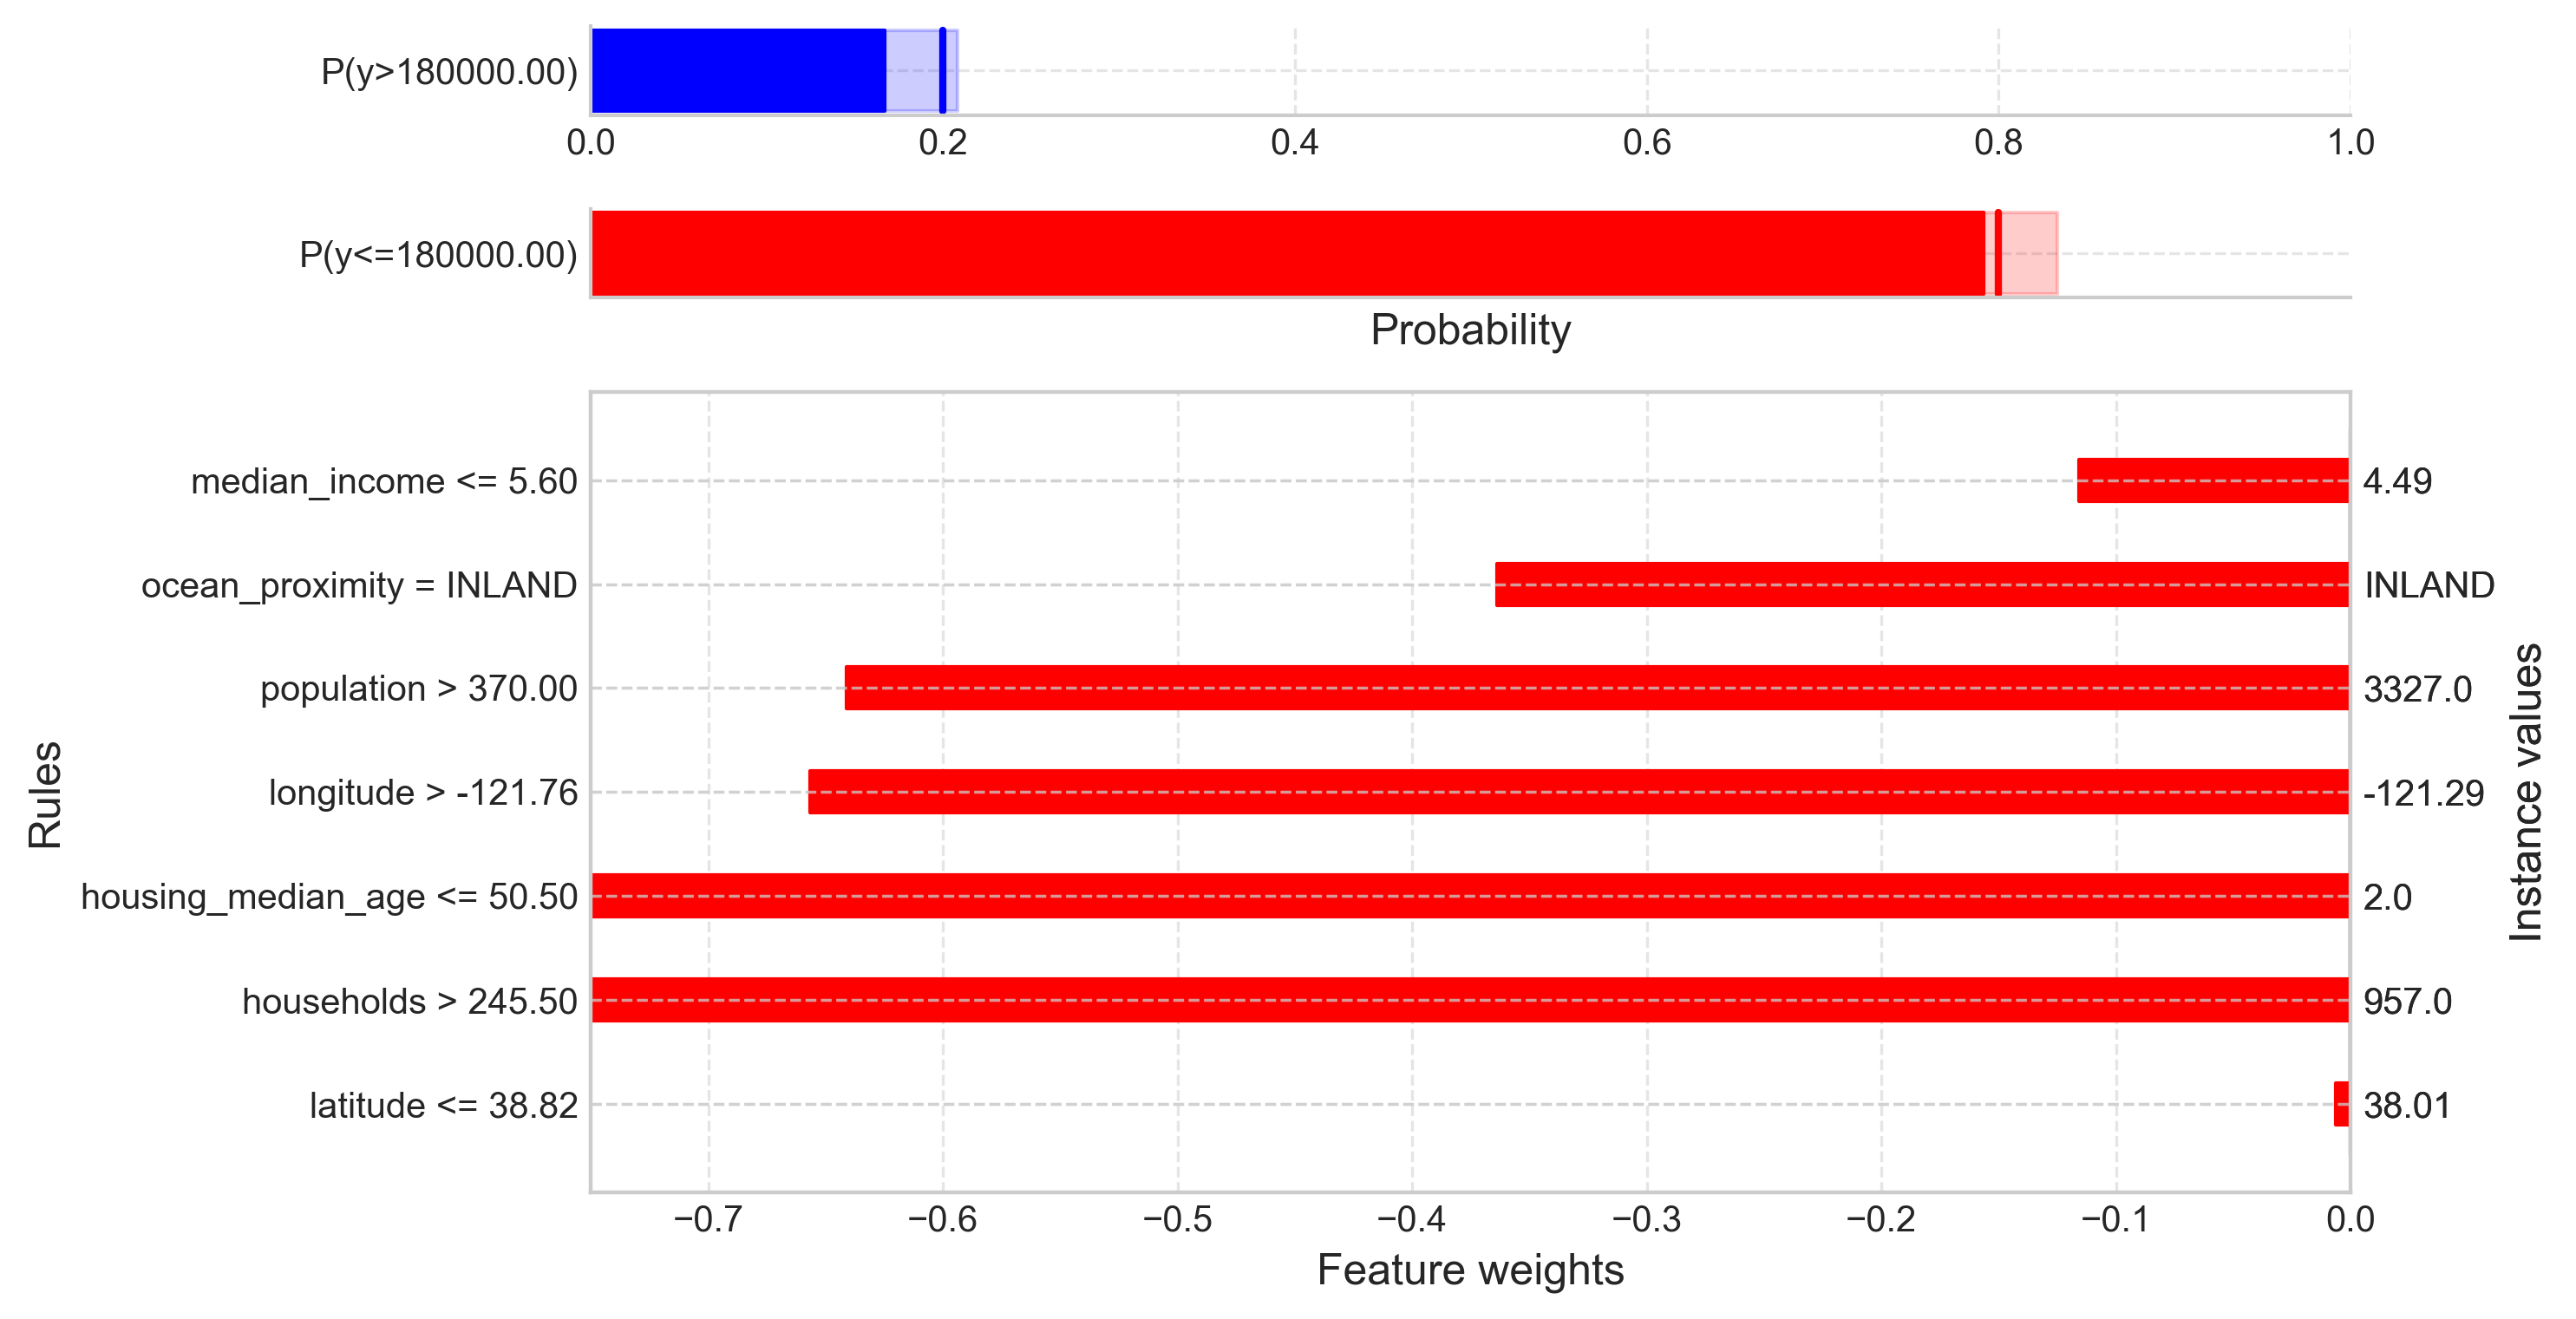

In [18]:
factual_explanation.remove_conjunctions().plot()

#### Normalized alternatives using knn

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\viz\matplotlib_adapter.py:1199: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(rect=(0, 0, 1, 0.94))


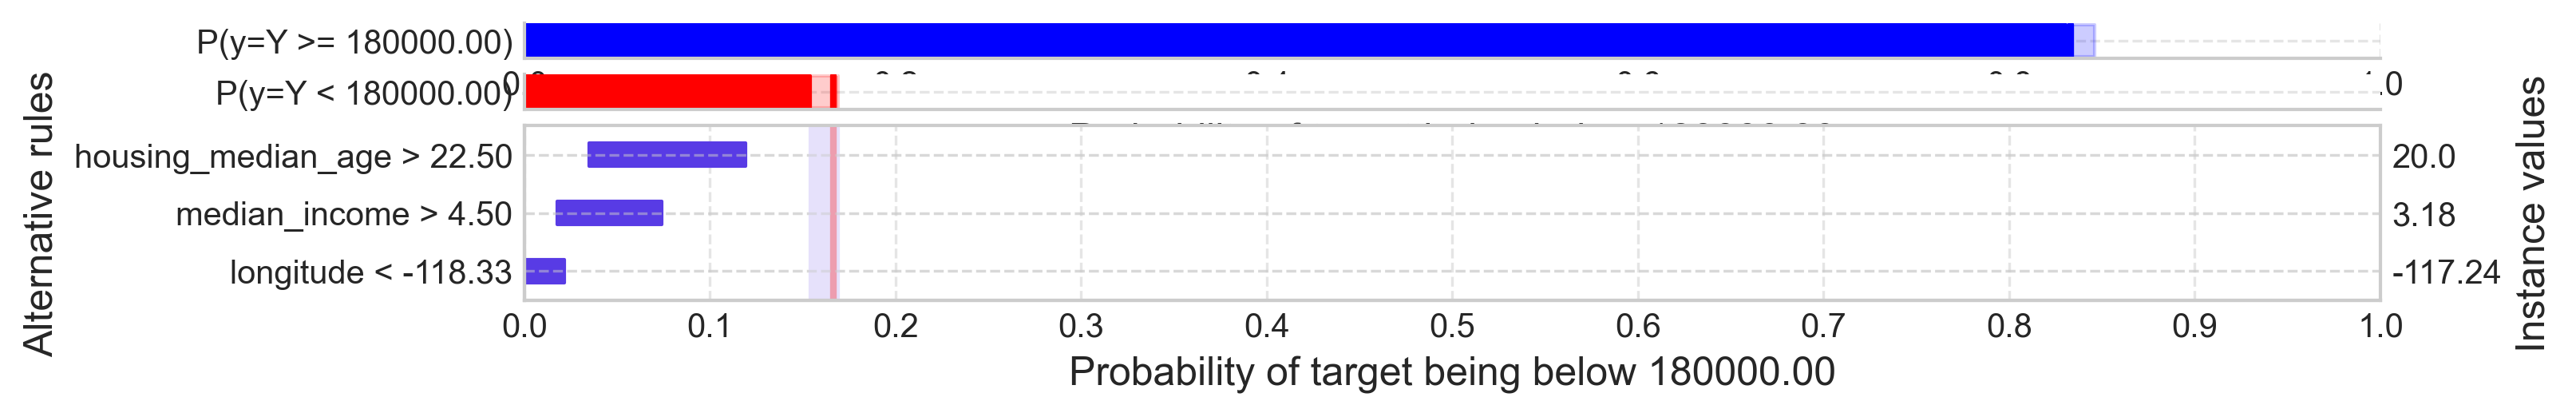

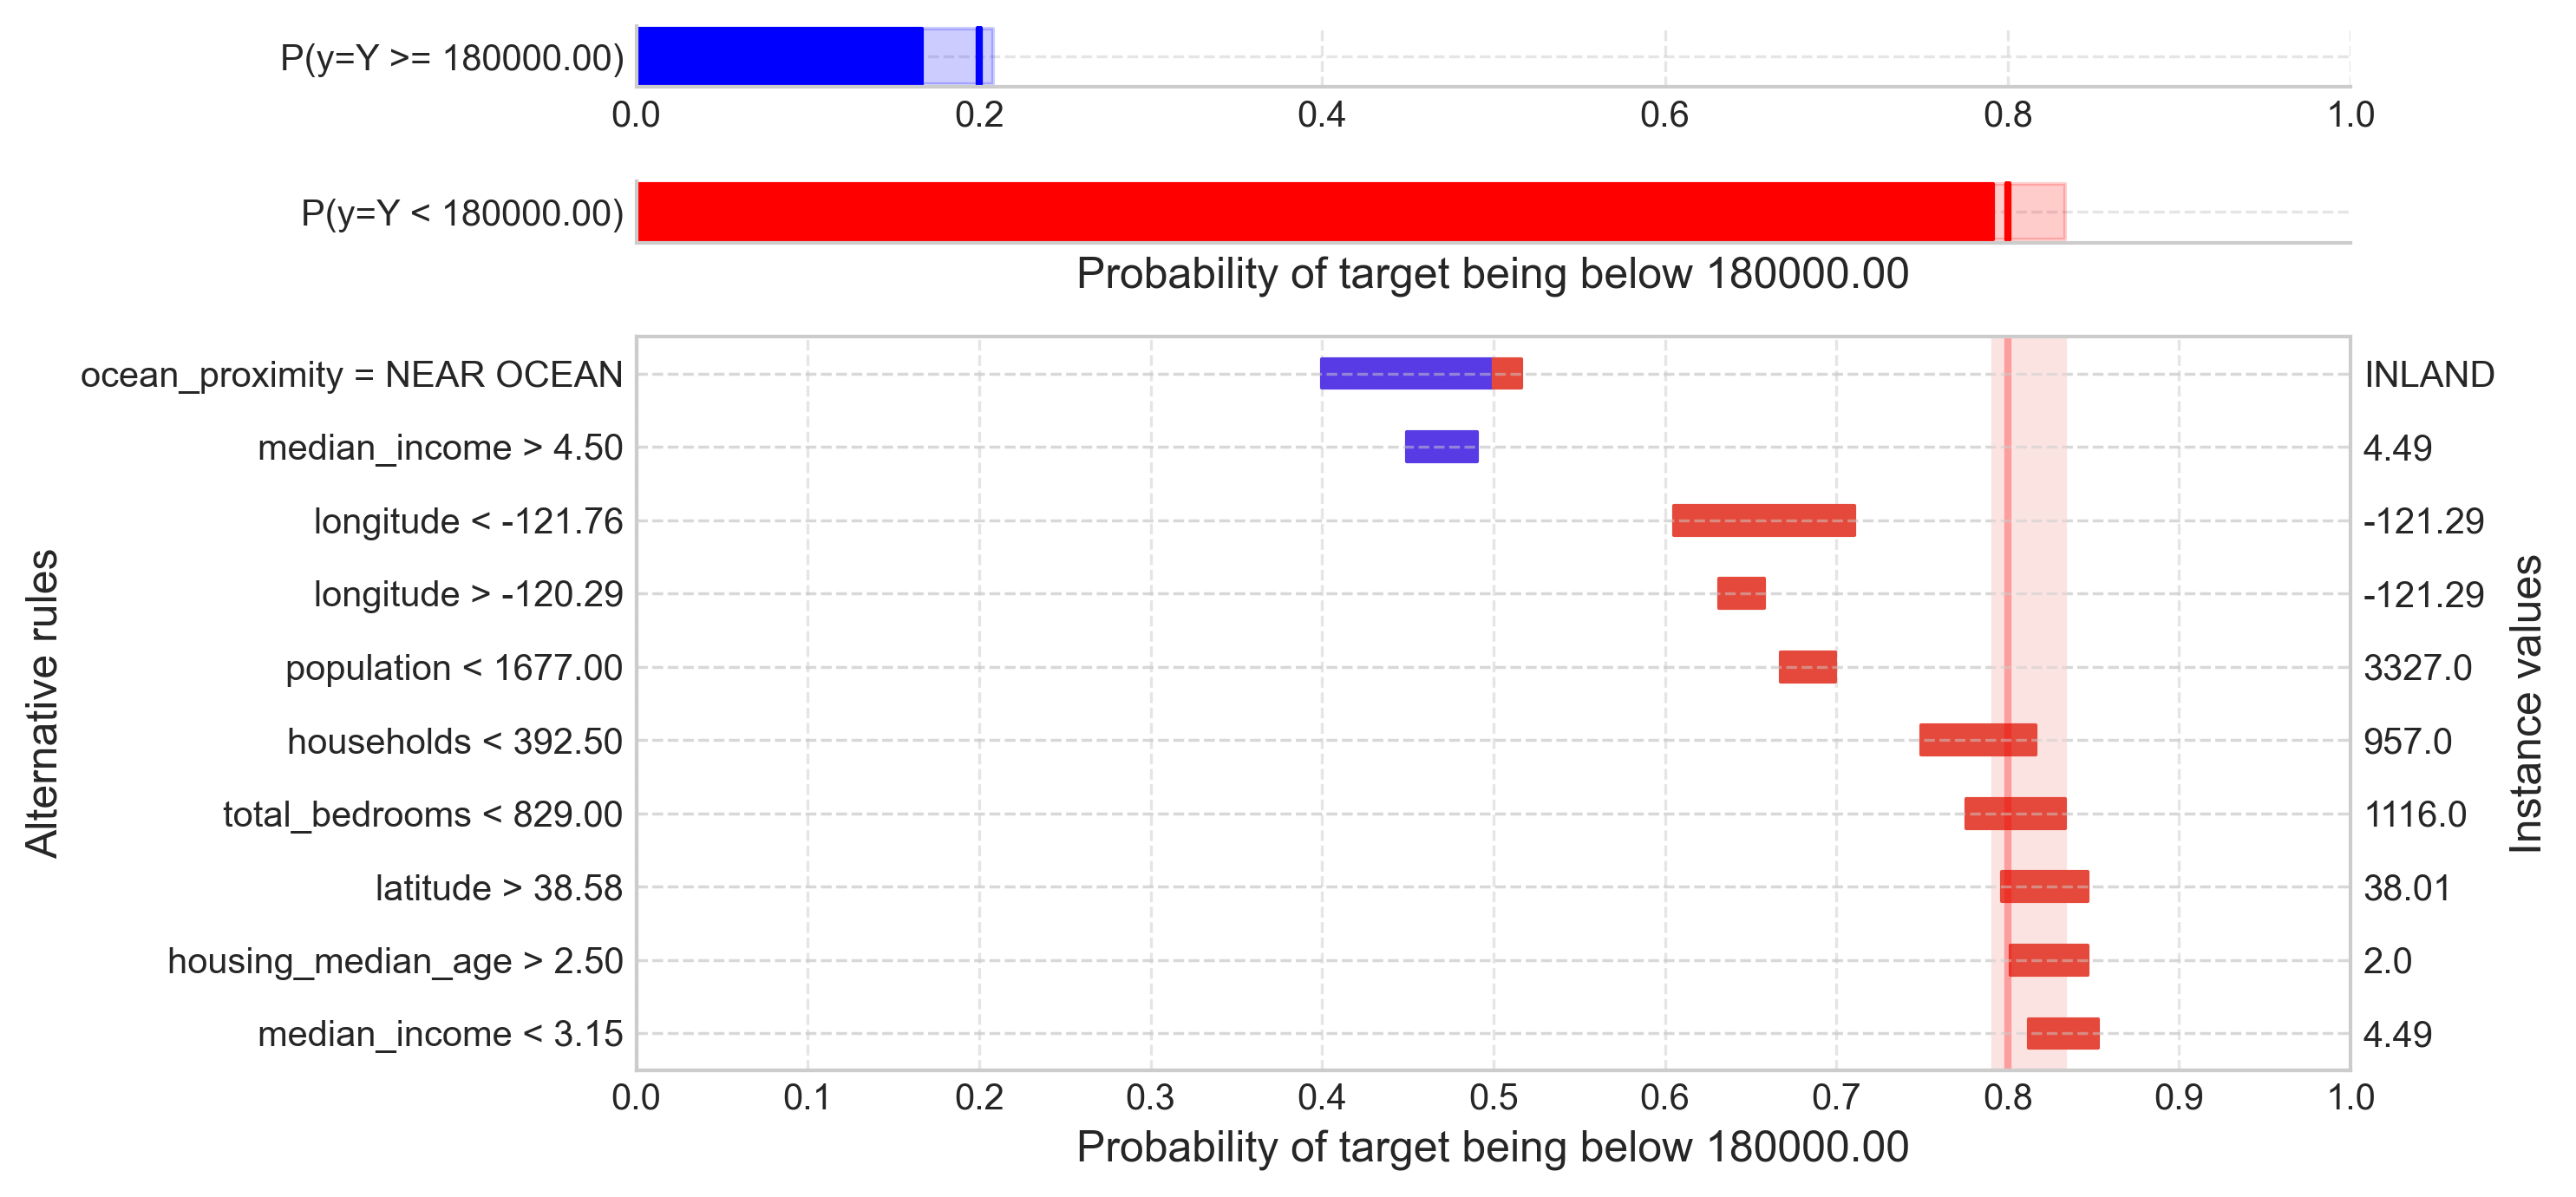

In [19]:
alternative_explanation = ce.explore_alternatives(X_test, 180000)

alternative_explanation.add_conjunctions().plot()

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\viz\matplotlib_adapter.py:1199: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(rect=(0, 0, 1, 0.94))


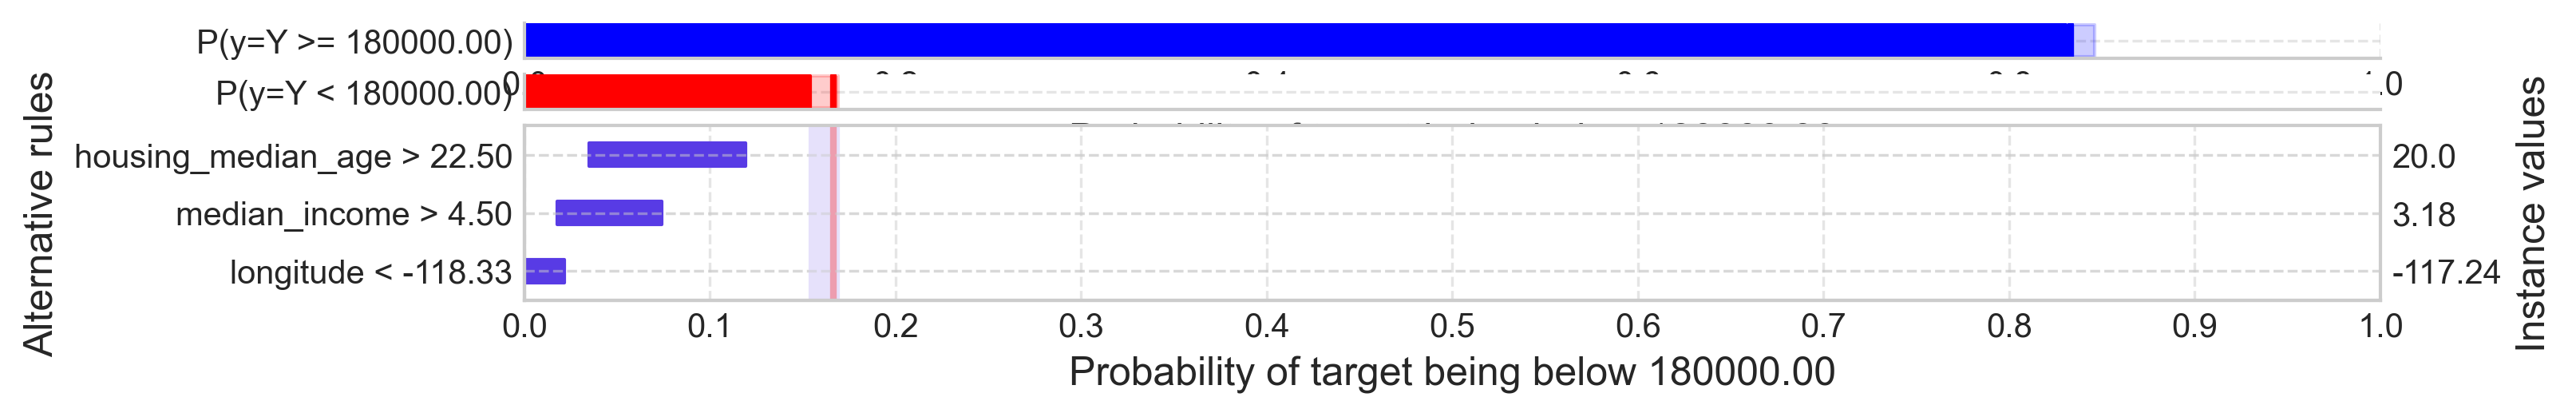

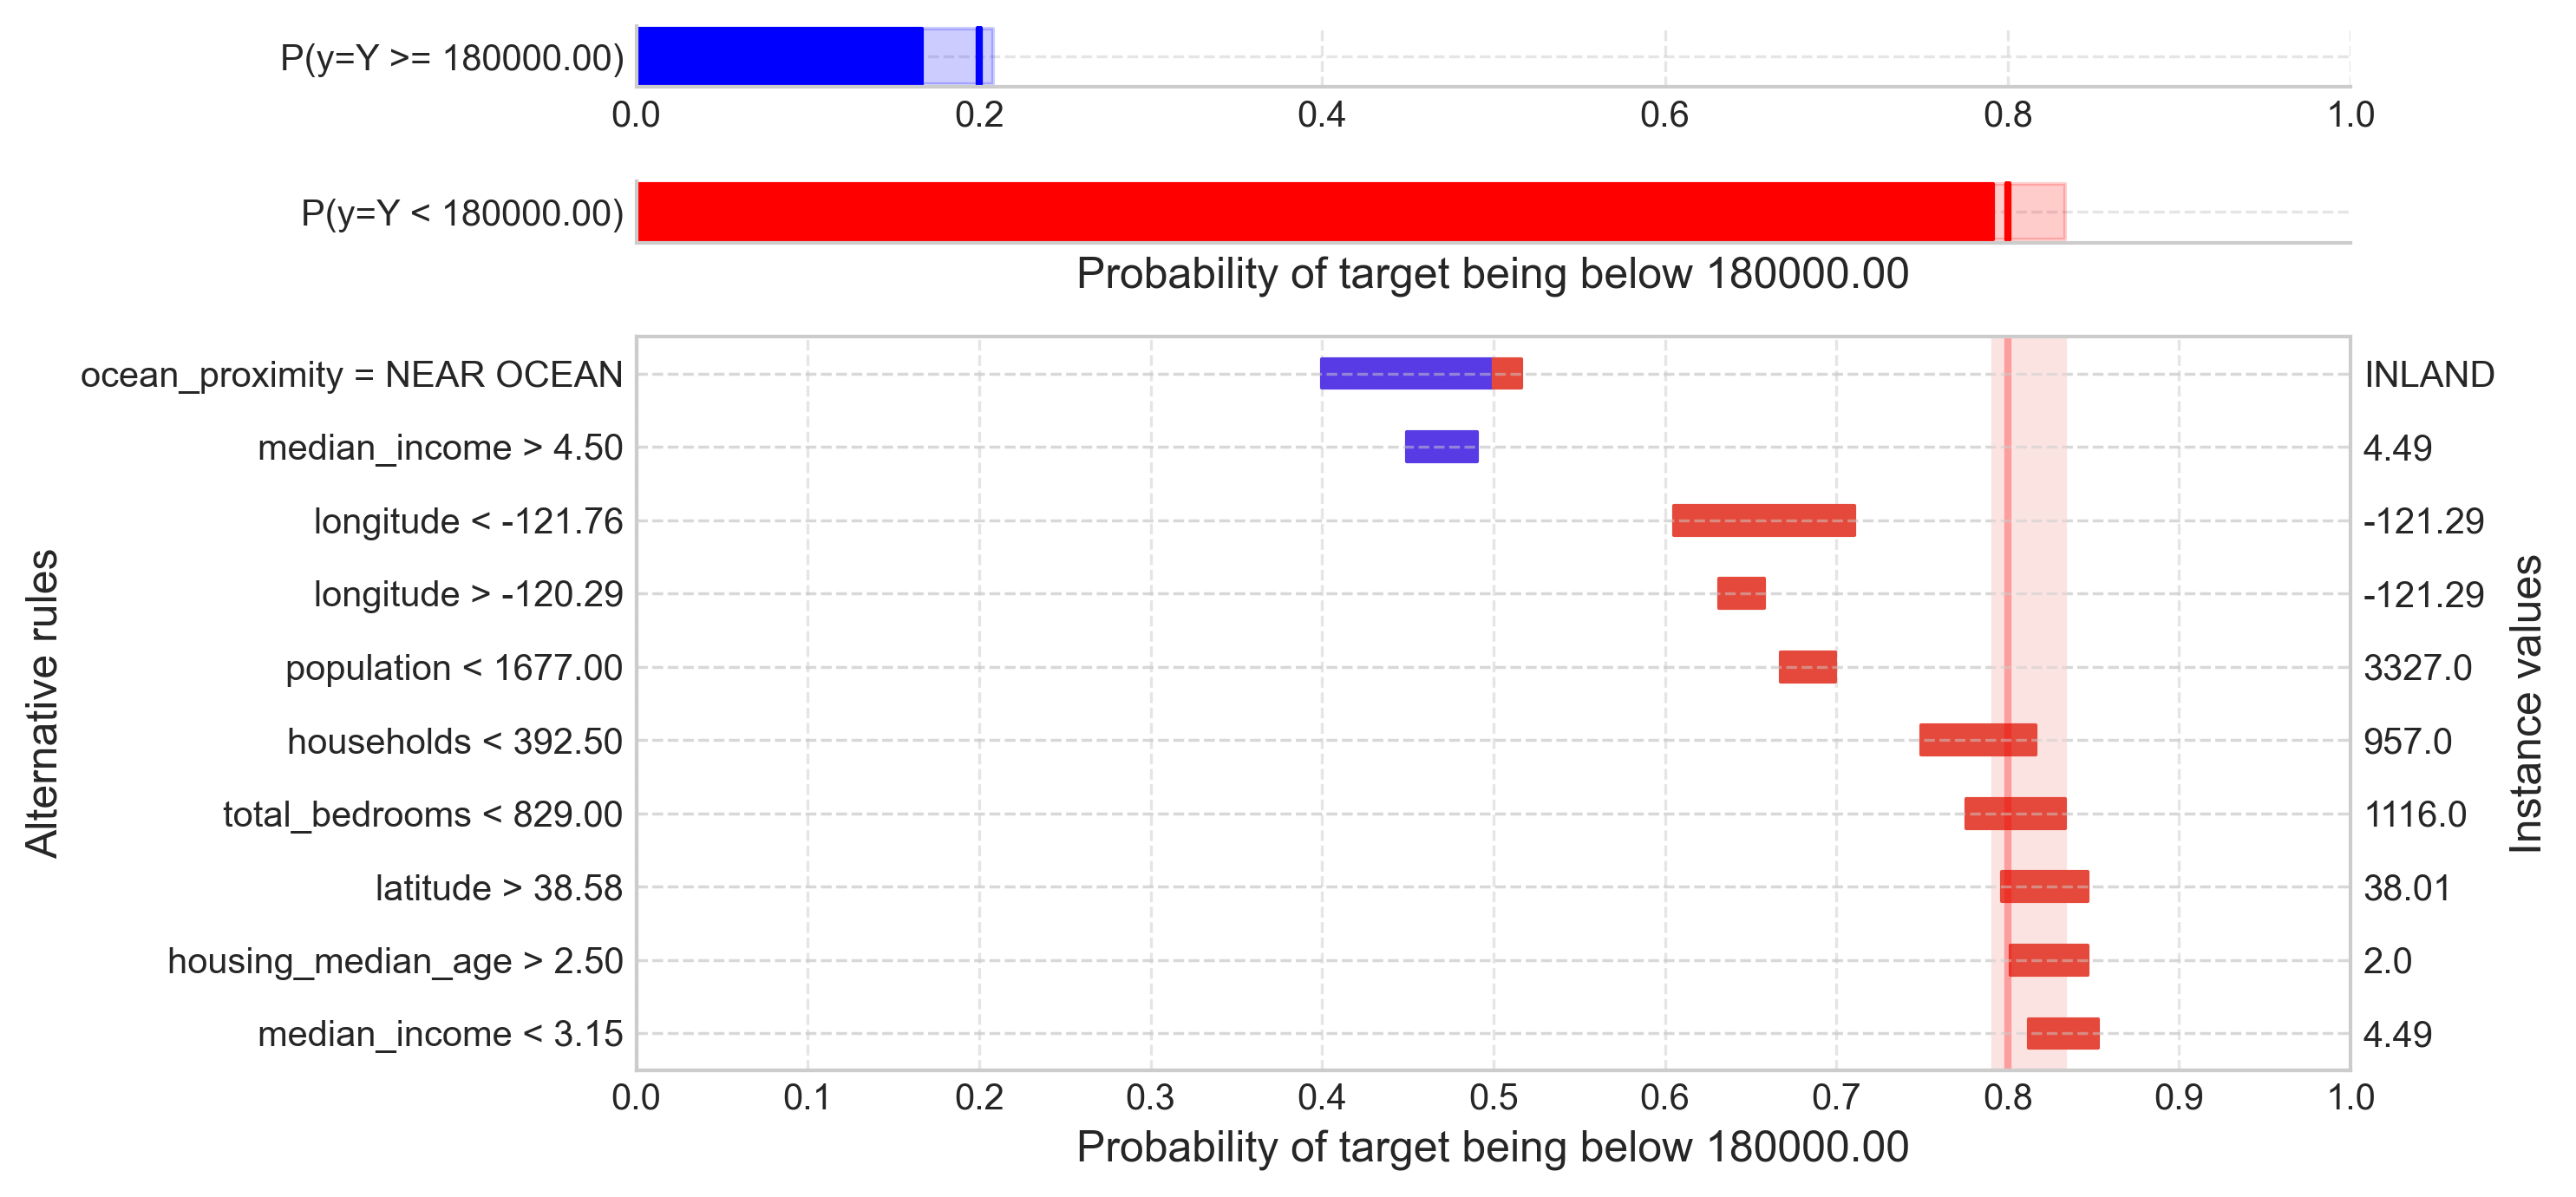

In [20]:
alternative_explanation.remove_conjunctions().plot()

#### Normalized explanations using variance

In [21]:
ce.set_difficulty_estimator(DifficultyEstimator().fit(X=X_prop_train, learner=model, scaler=True))

In [22]:
factual_explanation = ce.explain_factual(X_test, 180000)

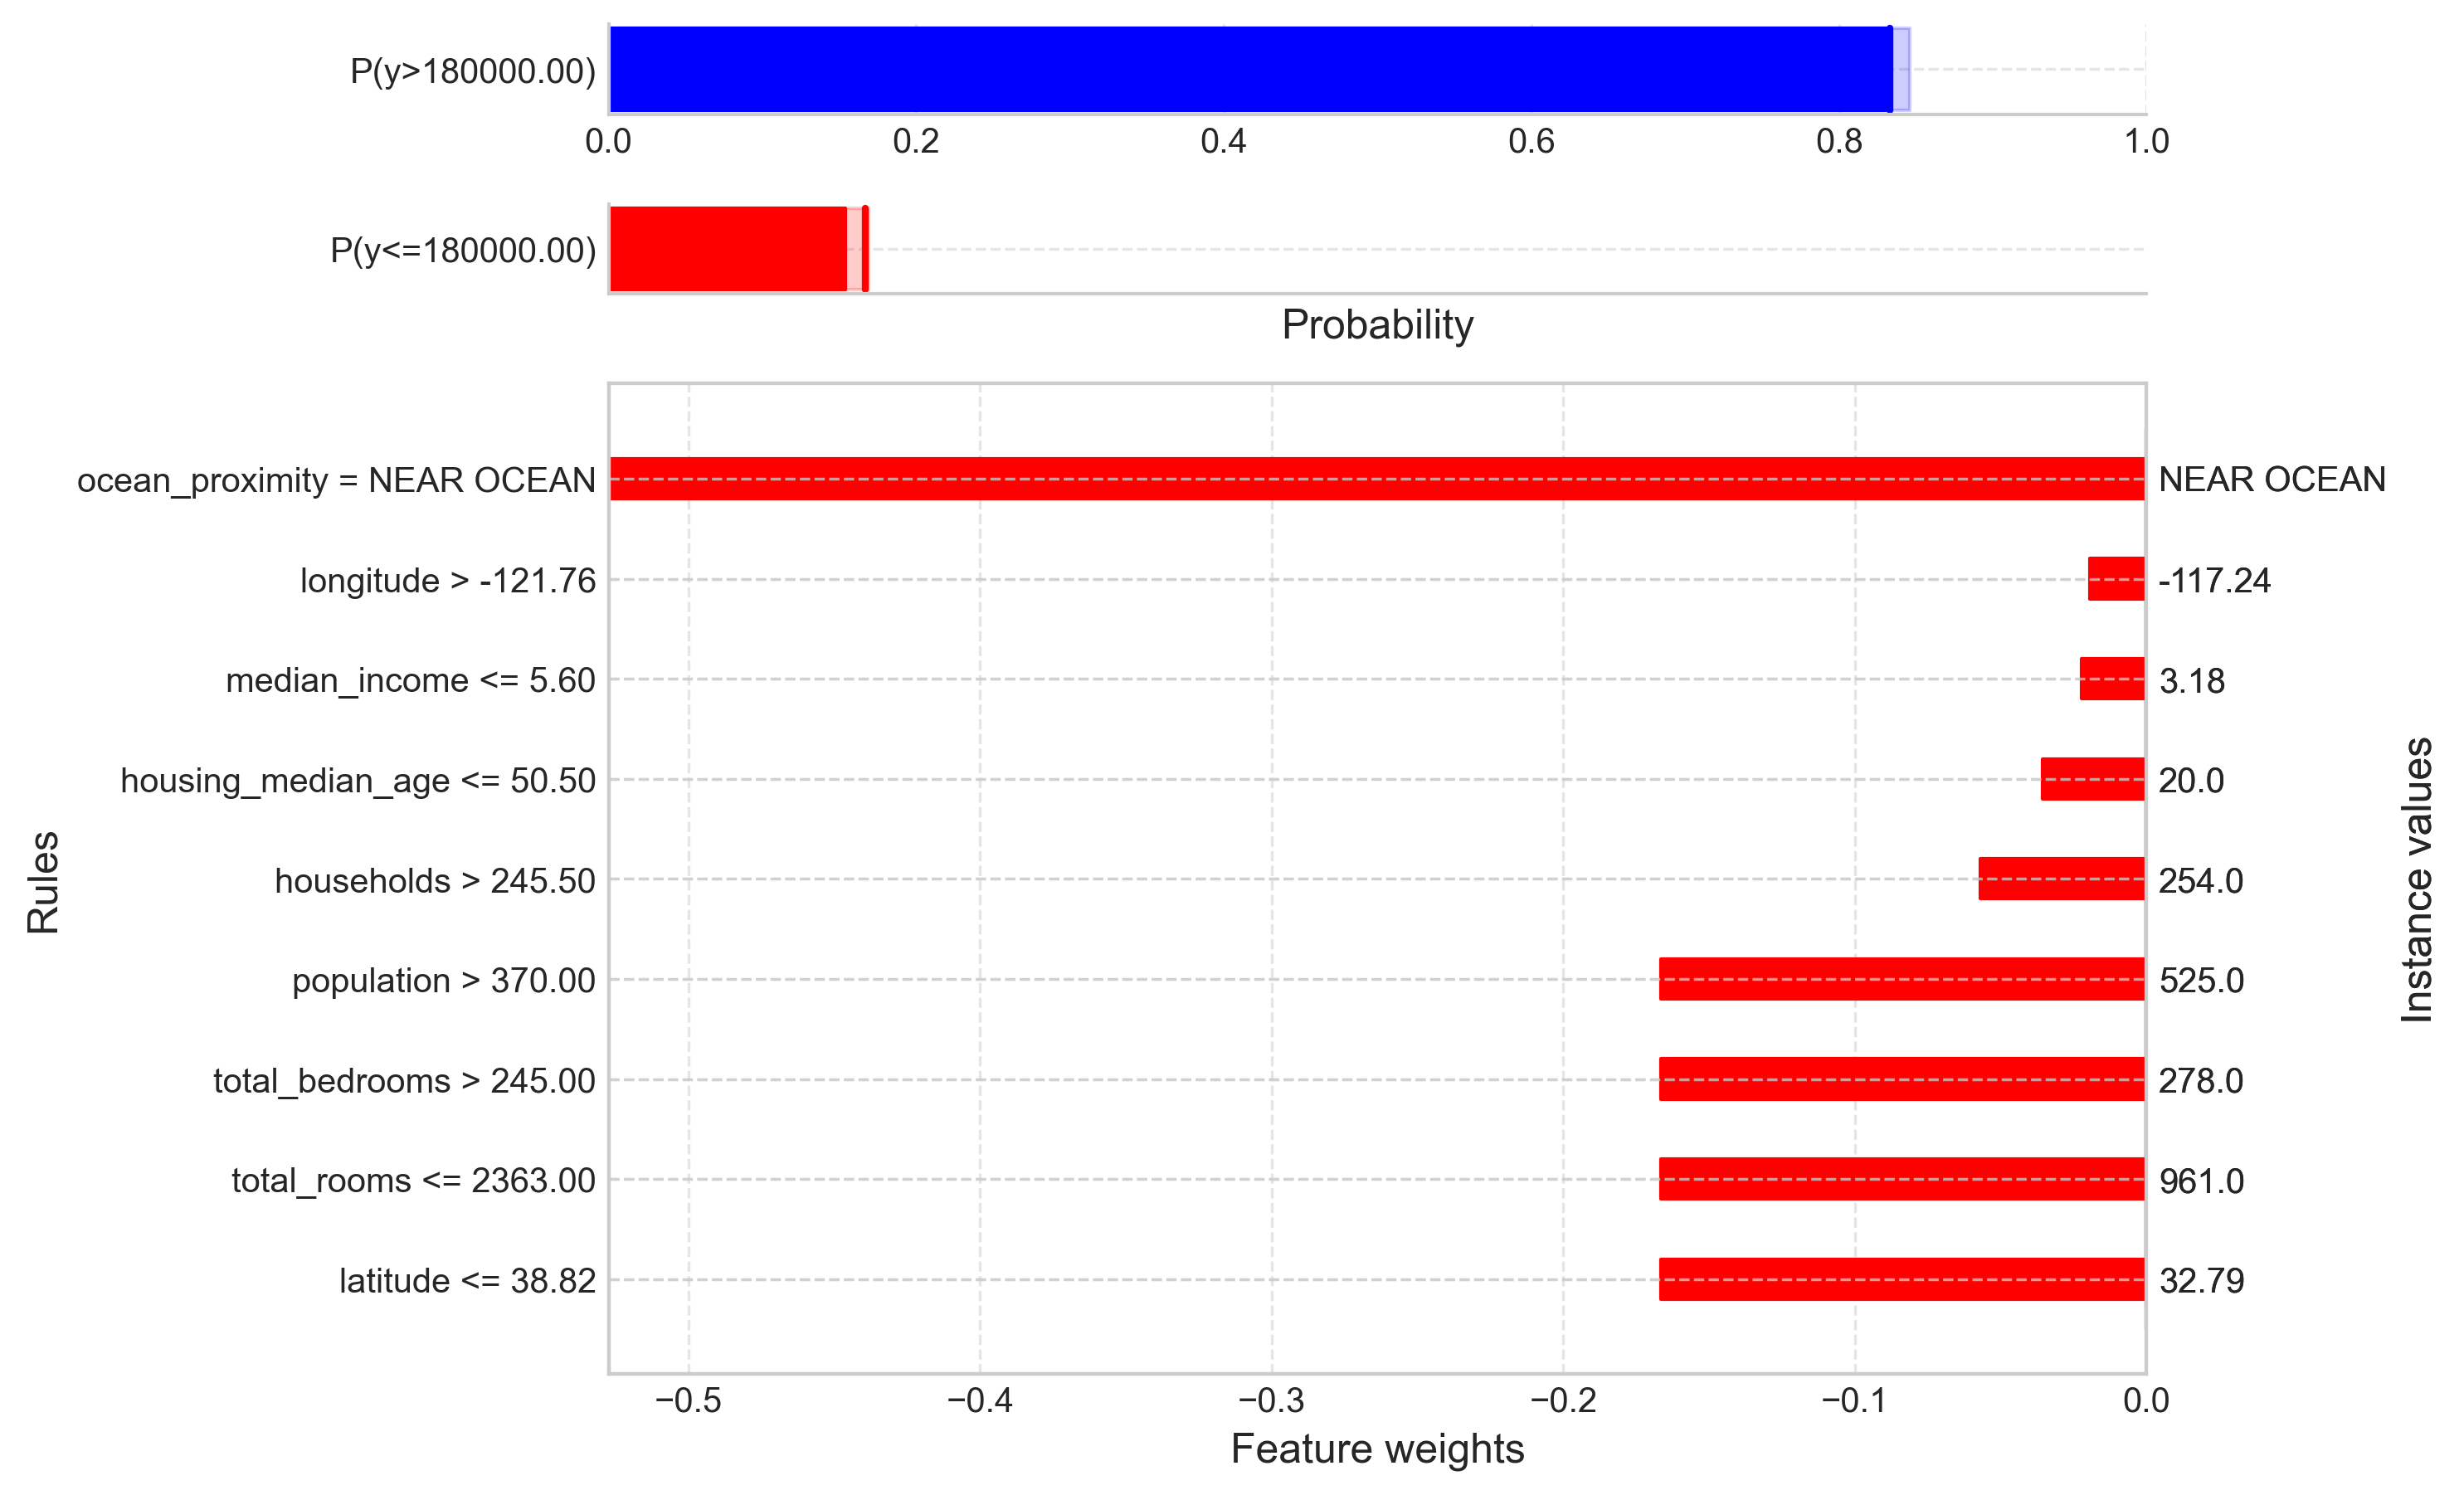

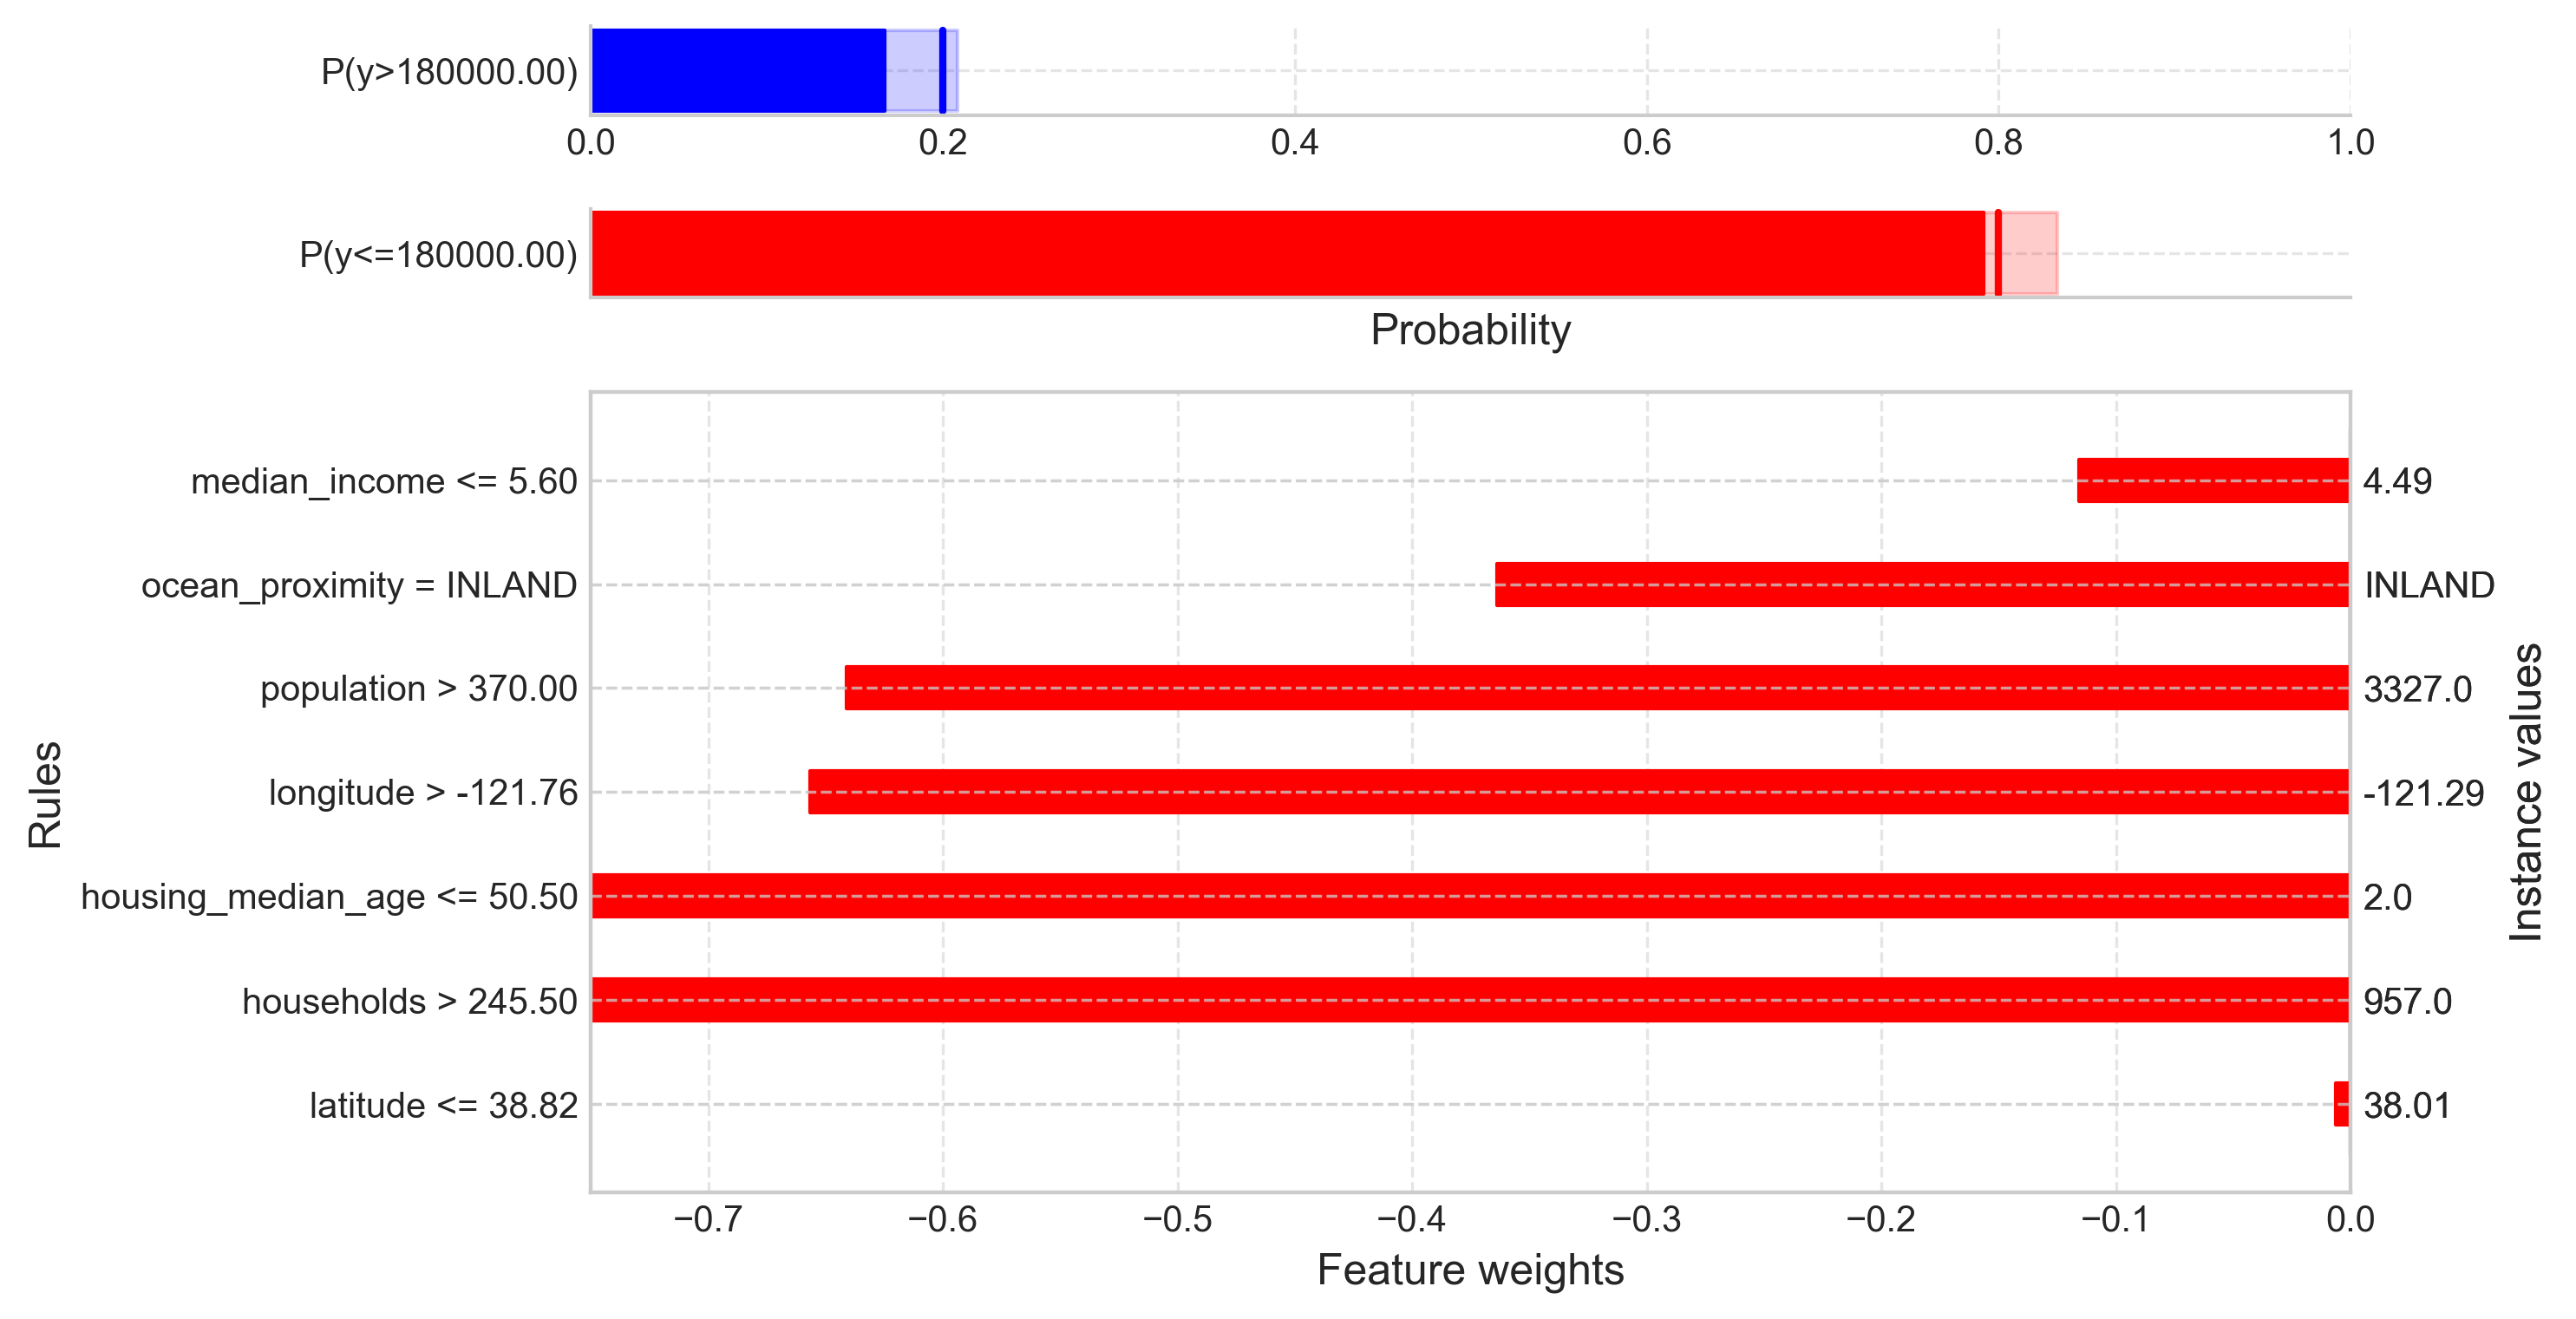

In [23]:
factual_explanation.add_conjunctions().plot()

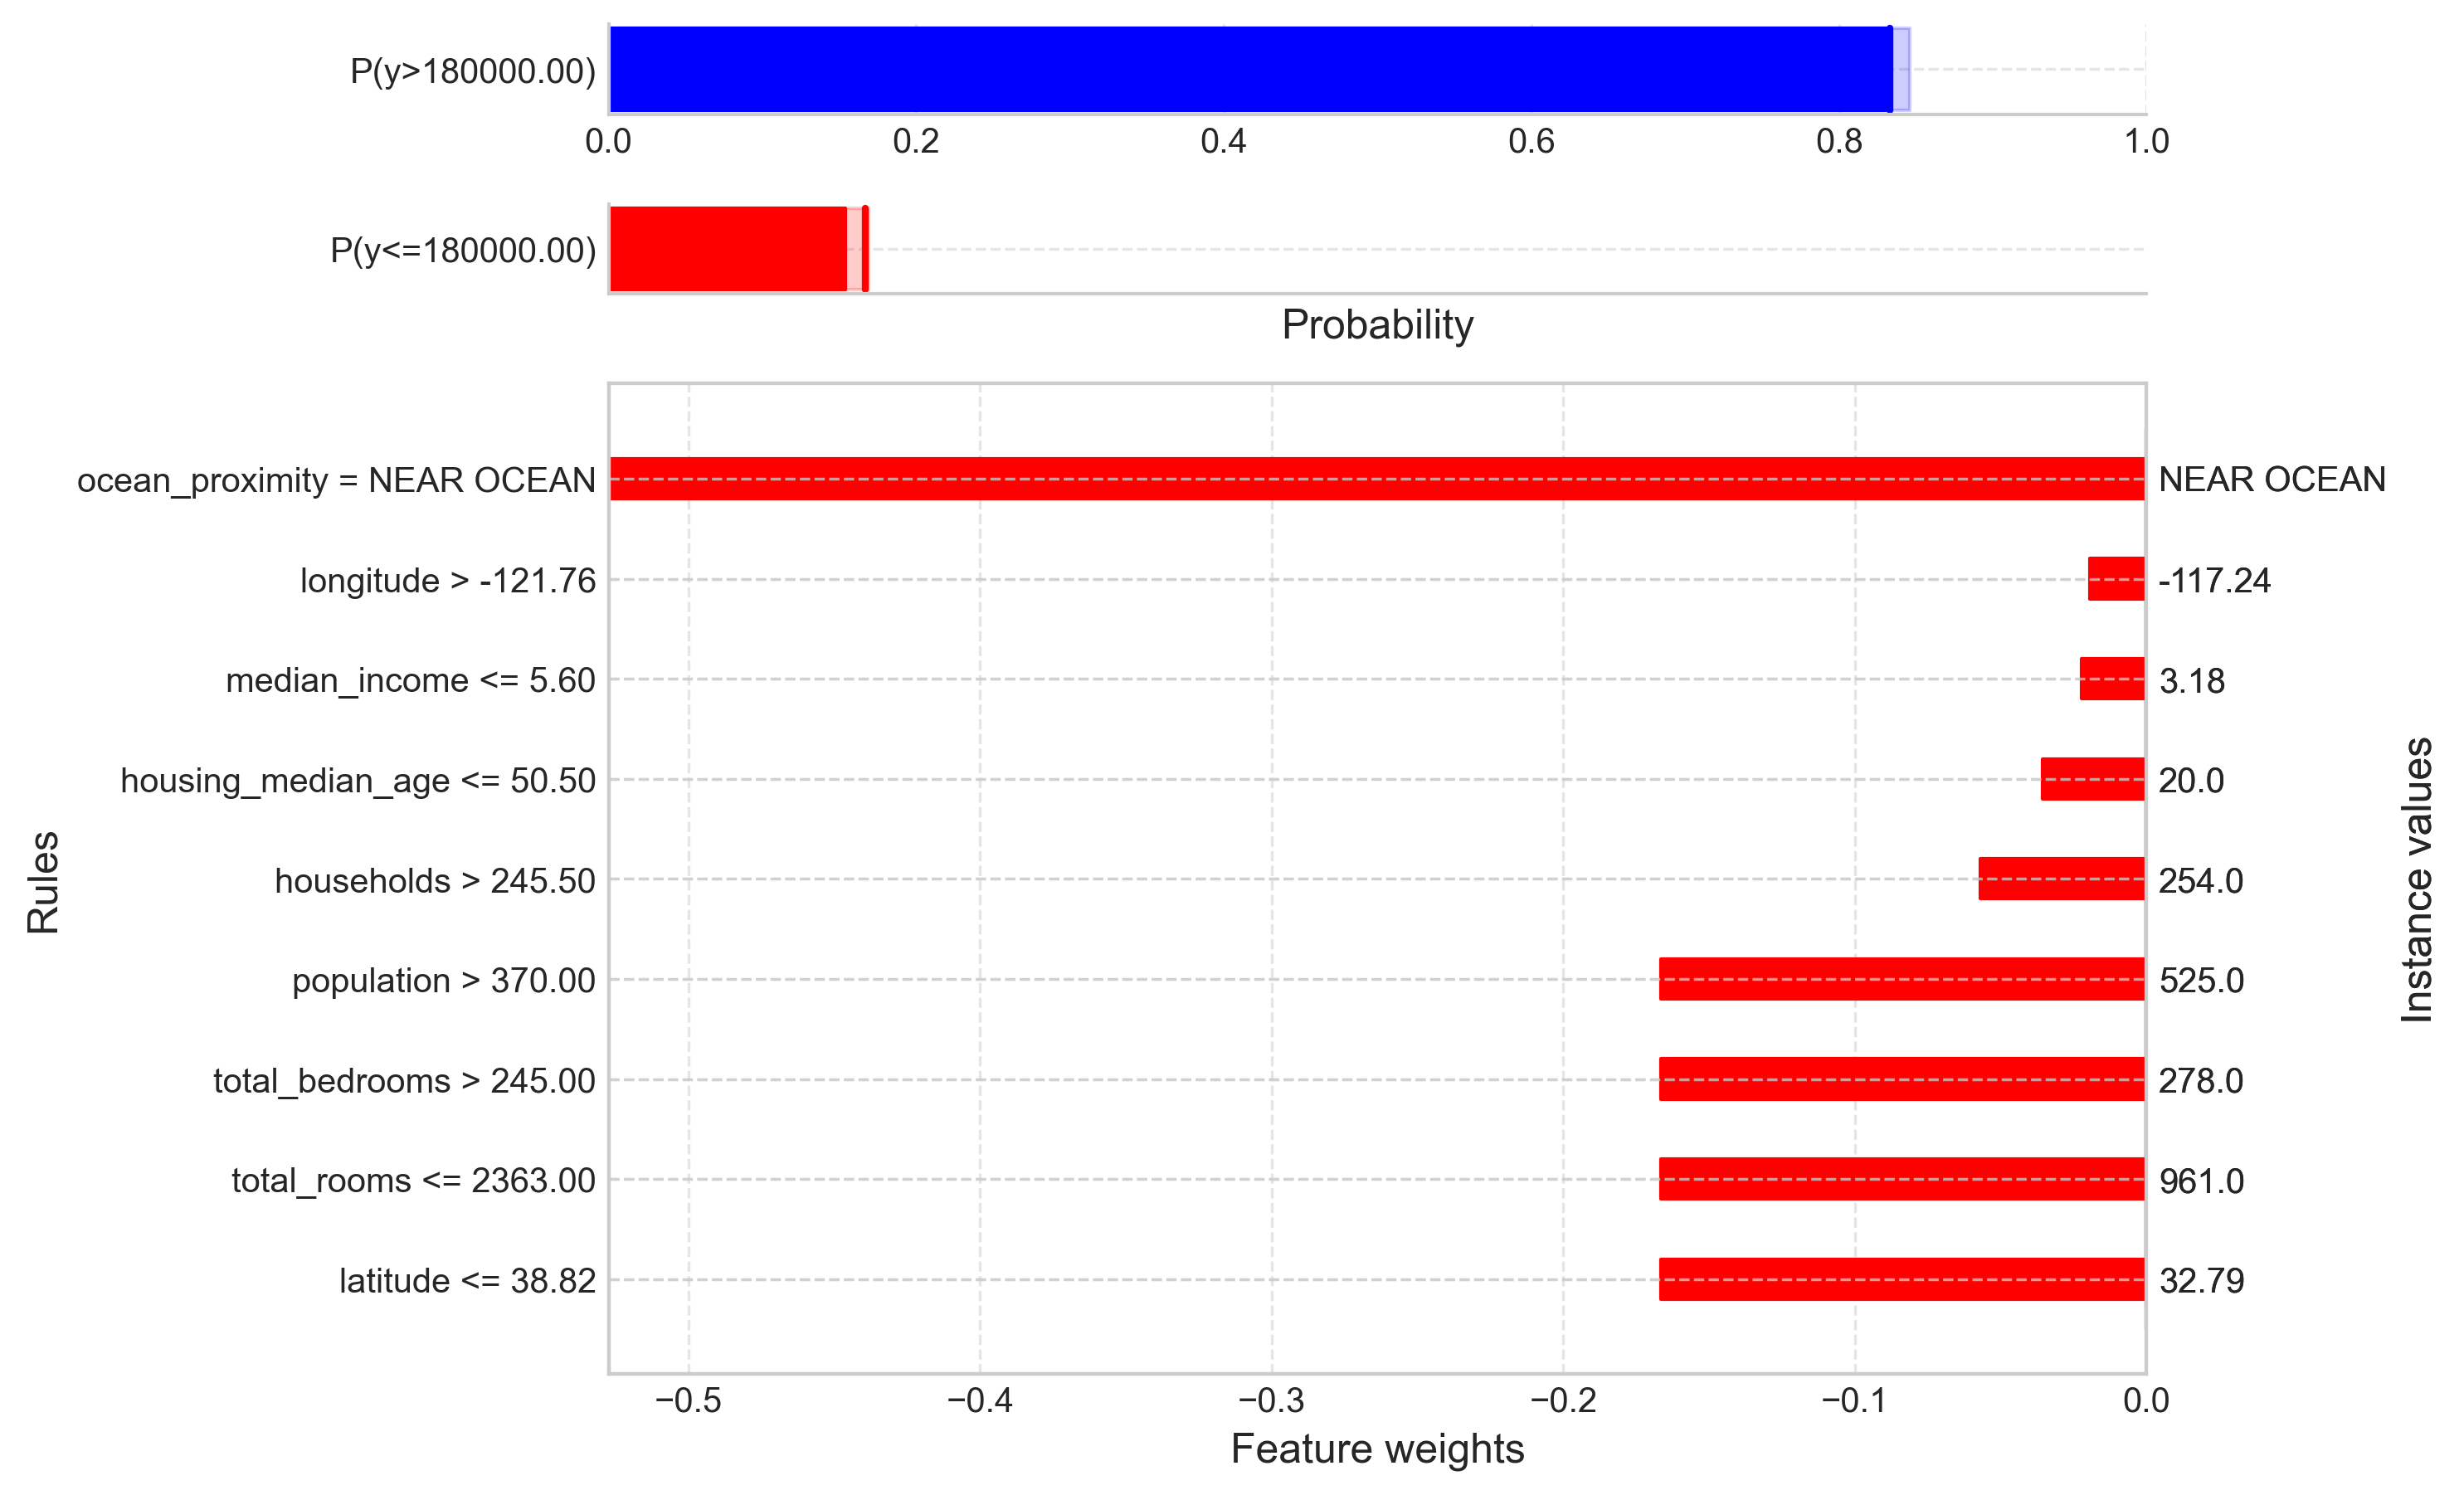

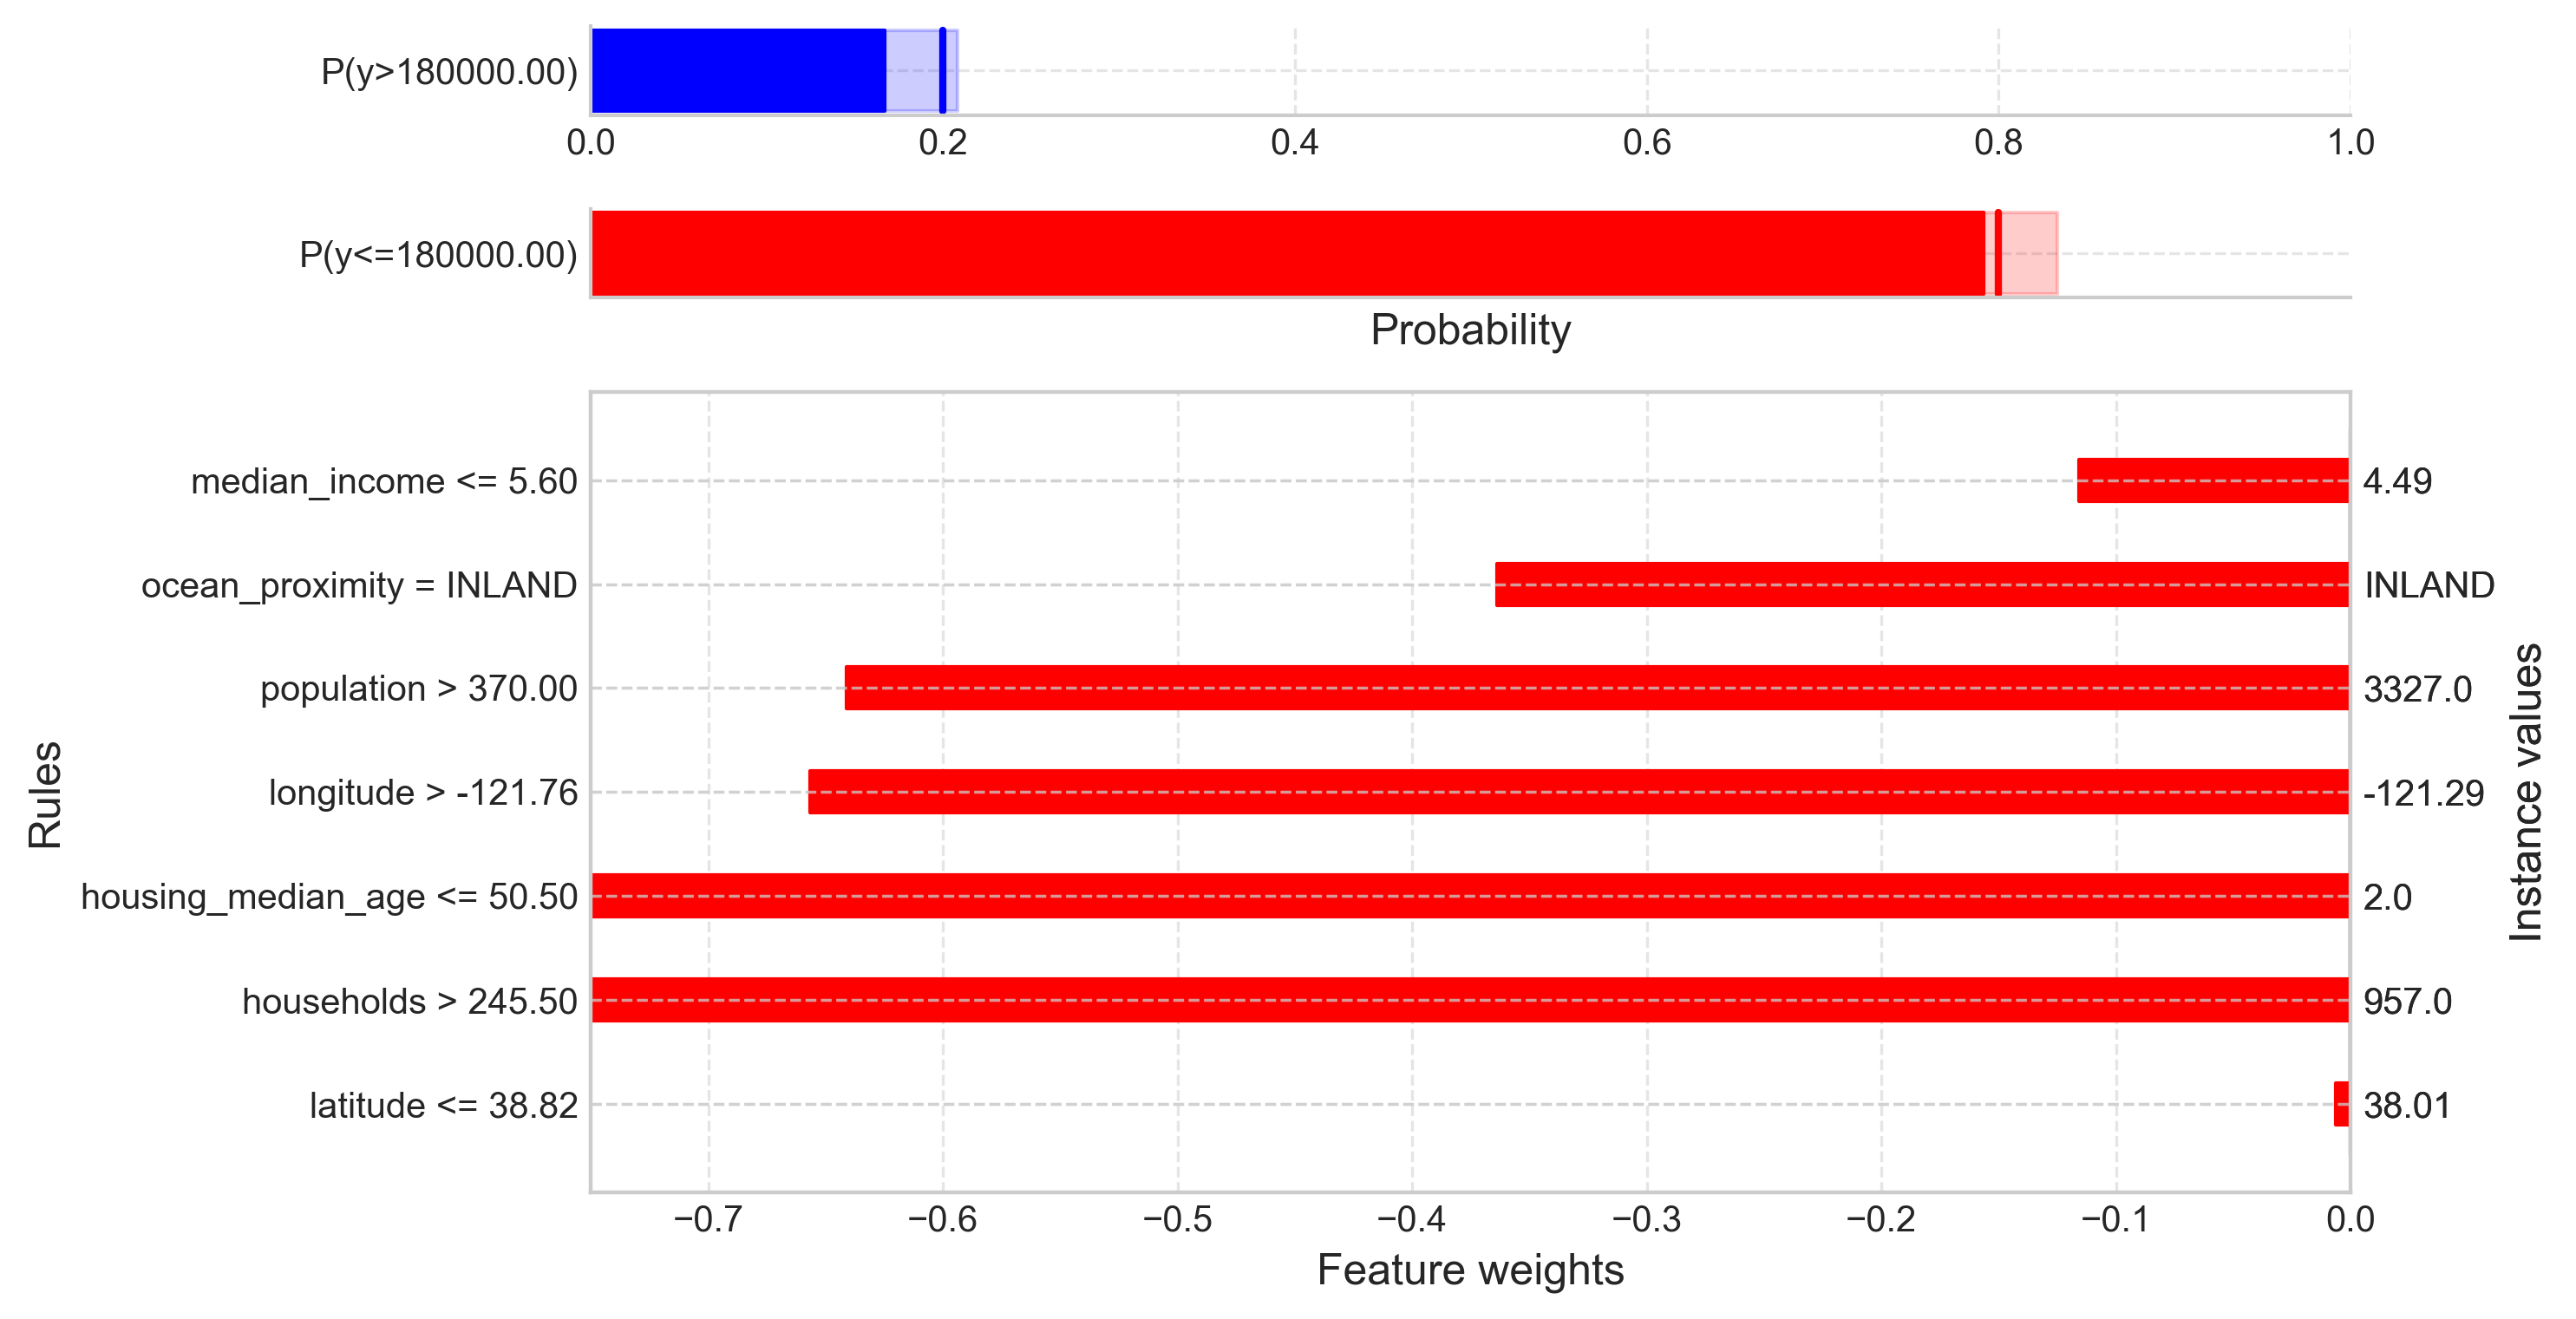

In [24]:
factual_explanation.remove_conjunctions().plot()

#### Normalized alternatives using variance

In [25]:
alternative_explanation = ce.explore_alternatives(X_test, 180000)

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\viz\matplotlib_adapter.py:1199: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(rect=(0, 0, 1, 0.94))


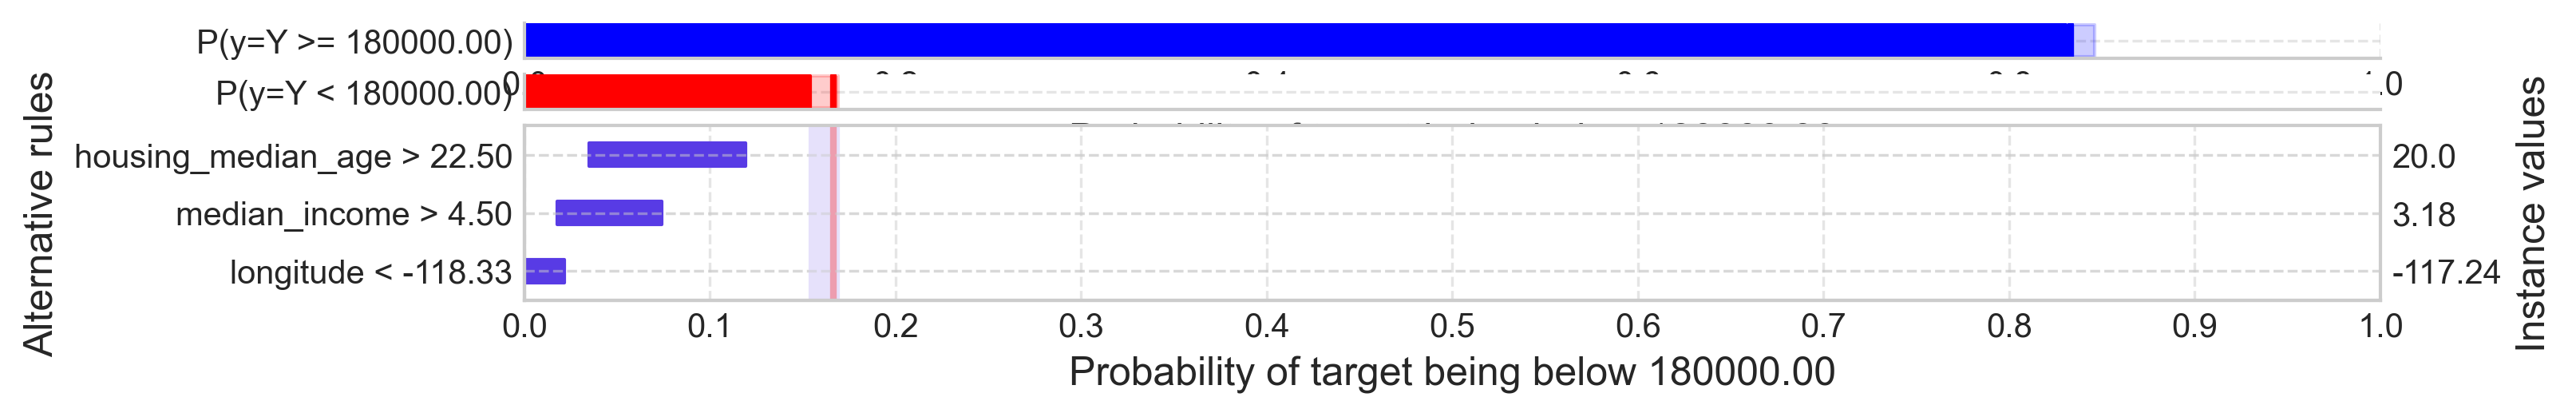

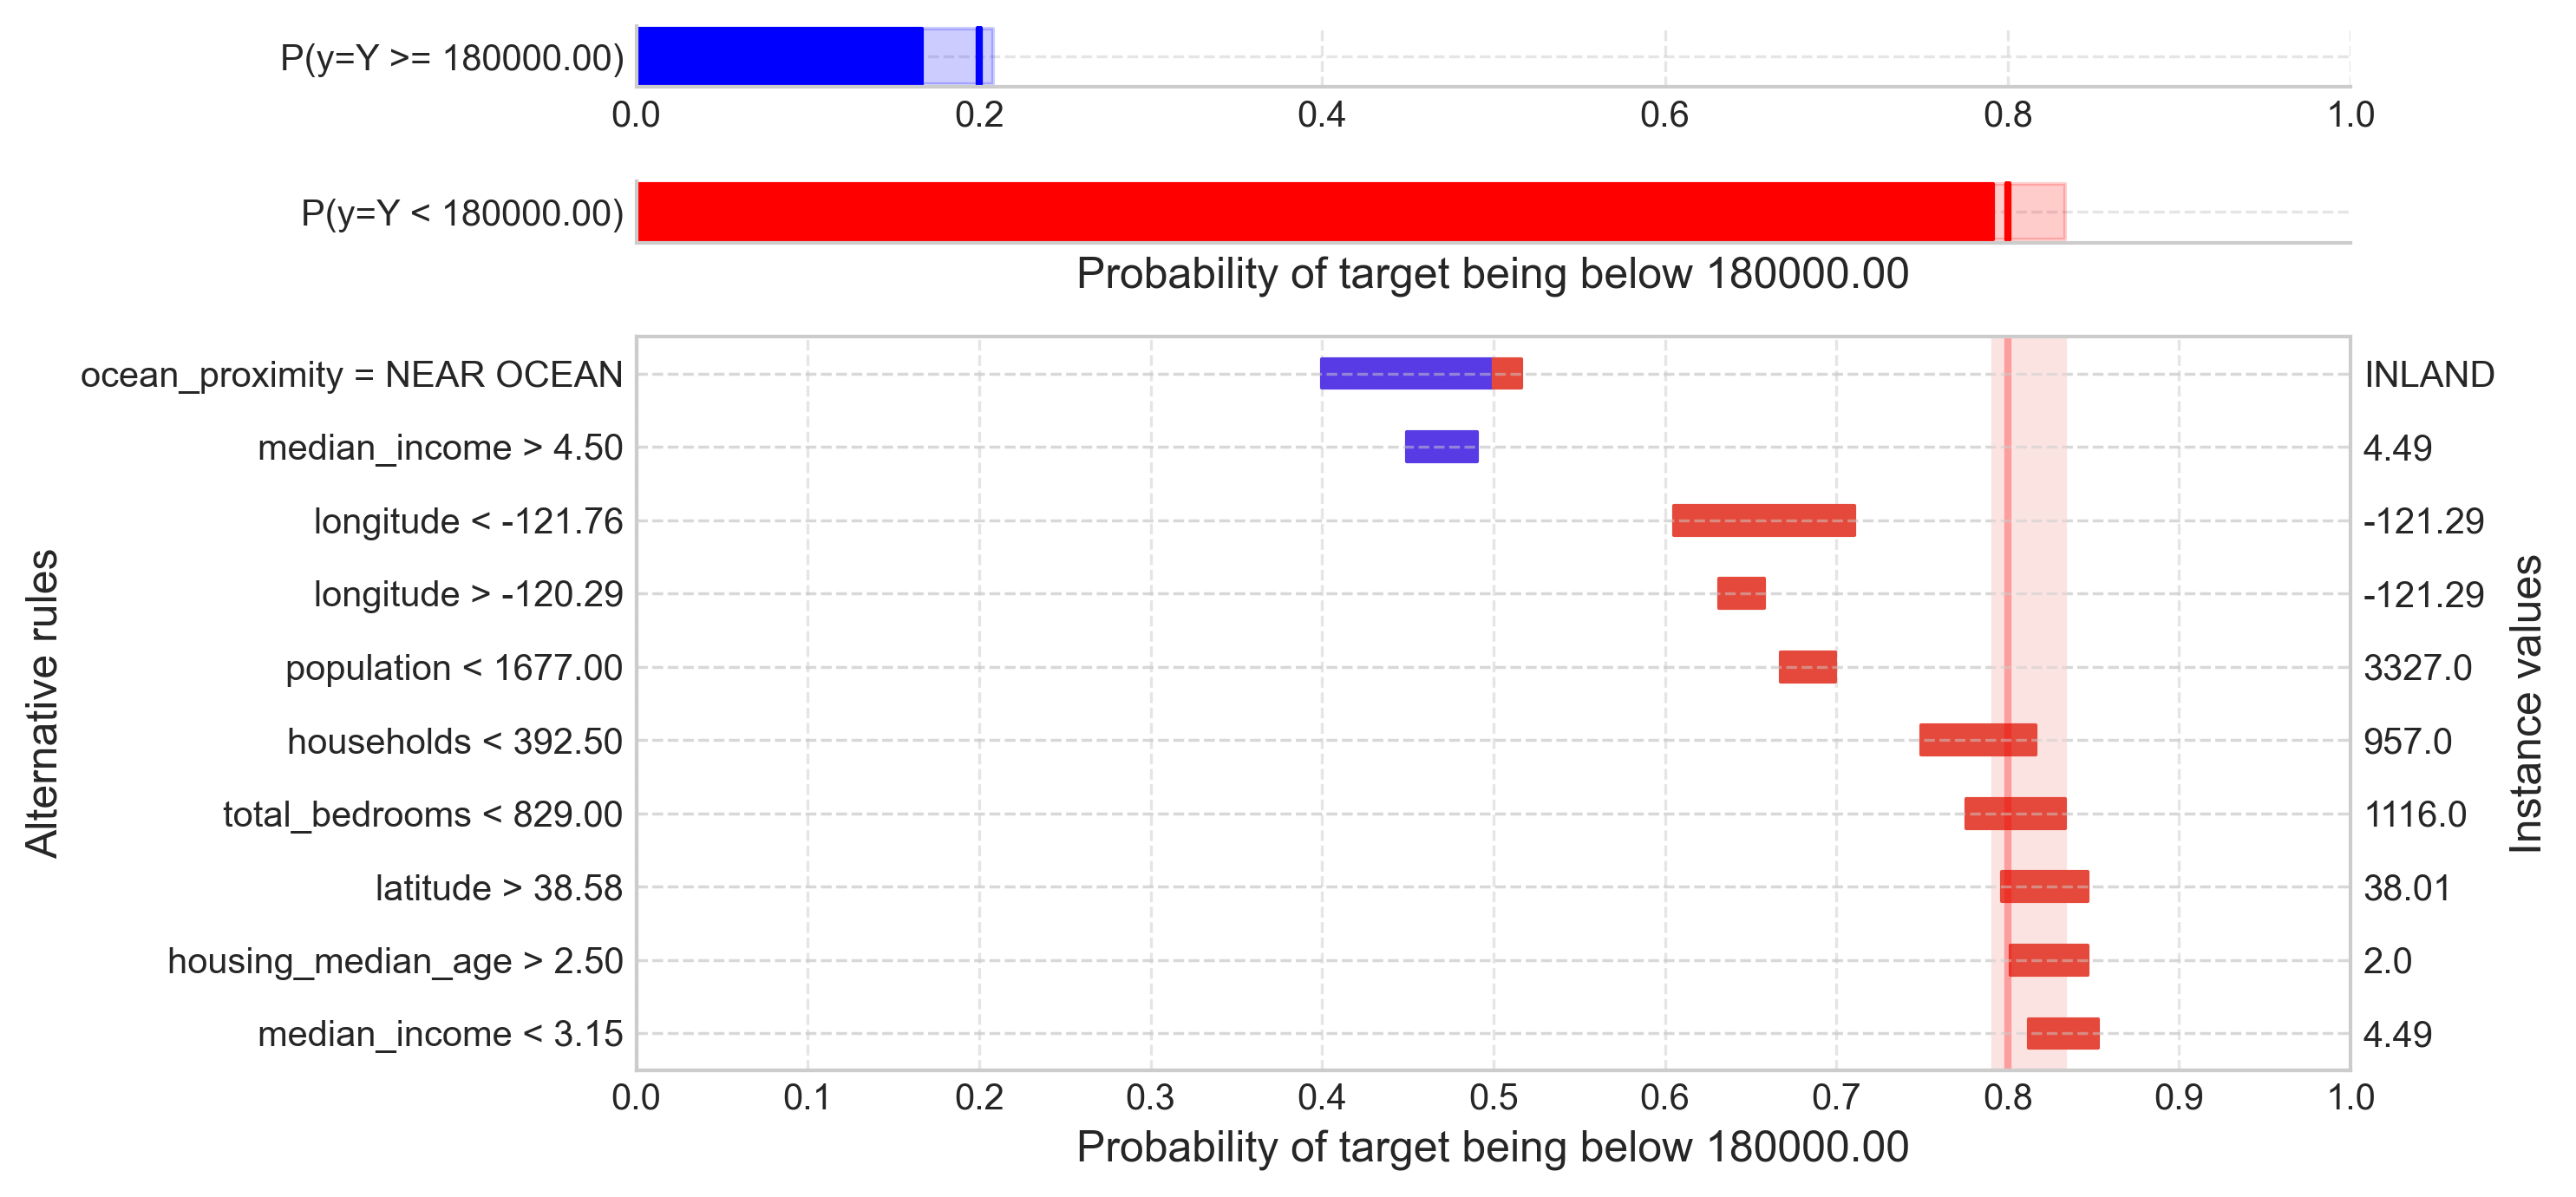

In [26]:
alternative_explanation.plot()

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\viz\matplotlib_adapter.py:1199: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(rect=(0, 0, 1, 0.94))


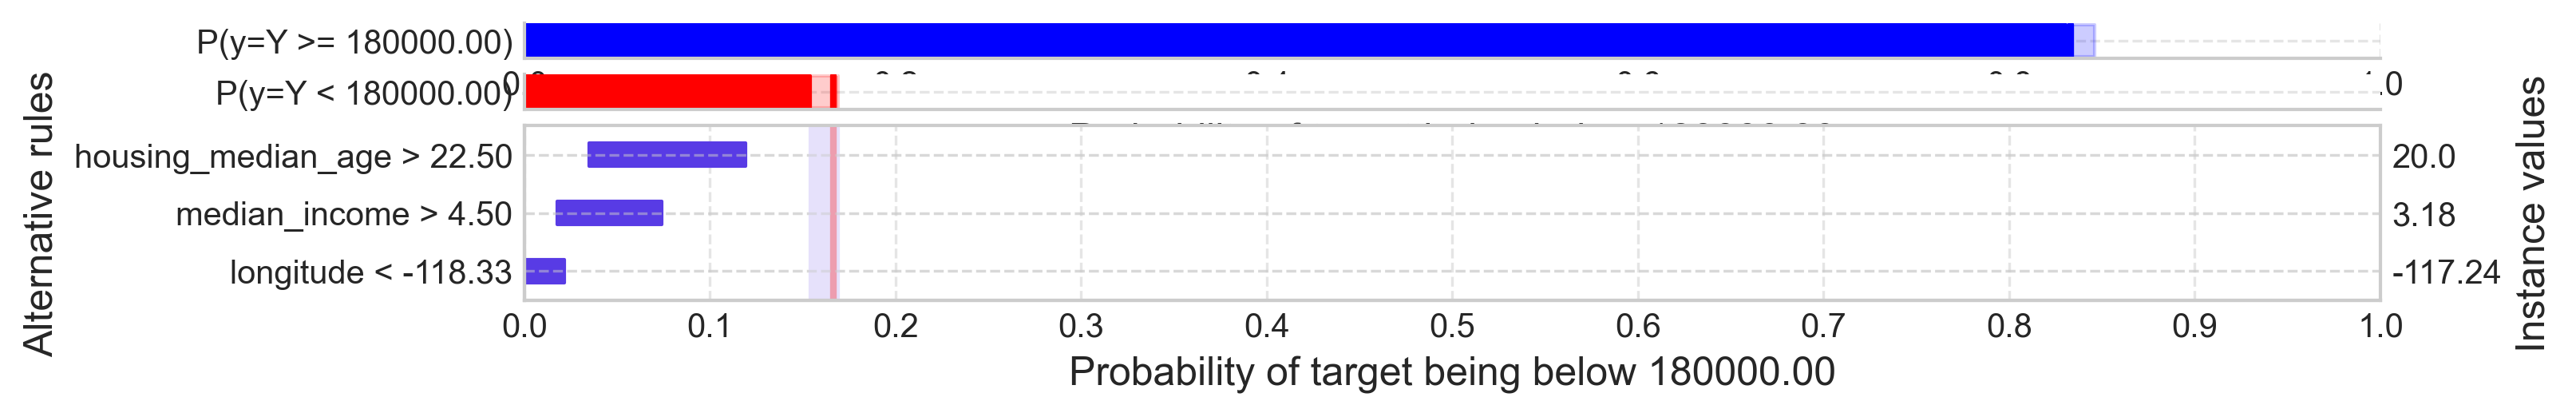

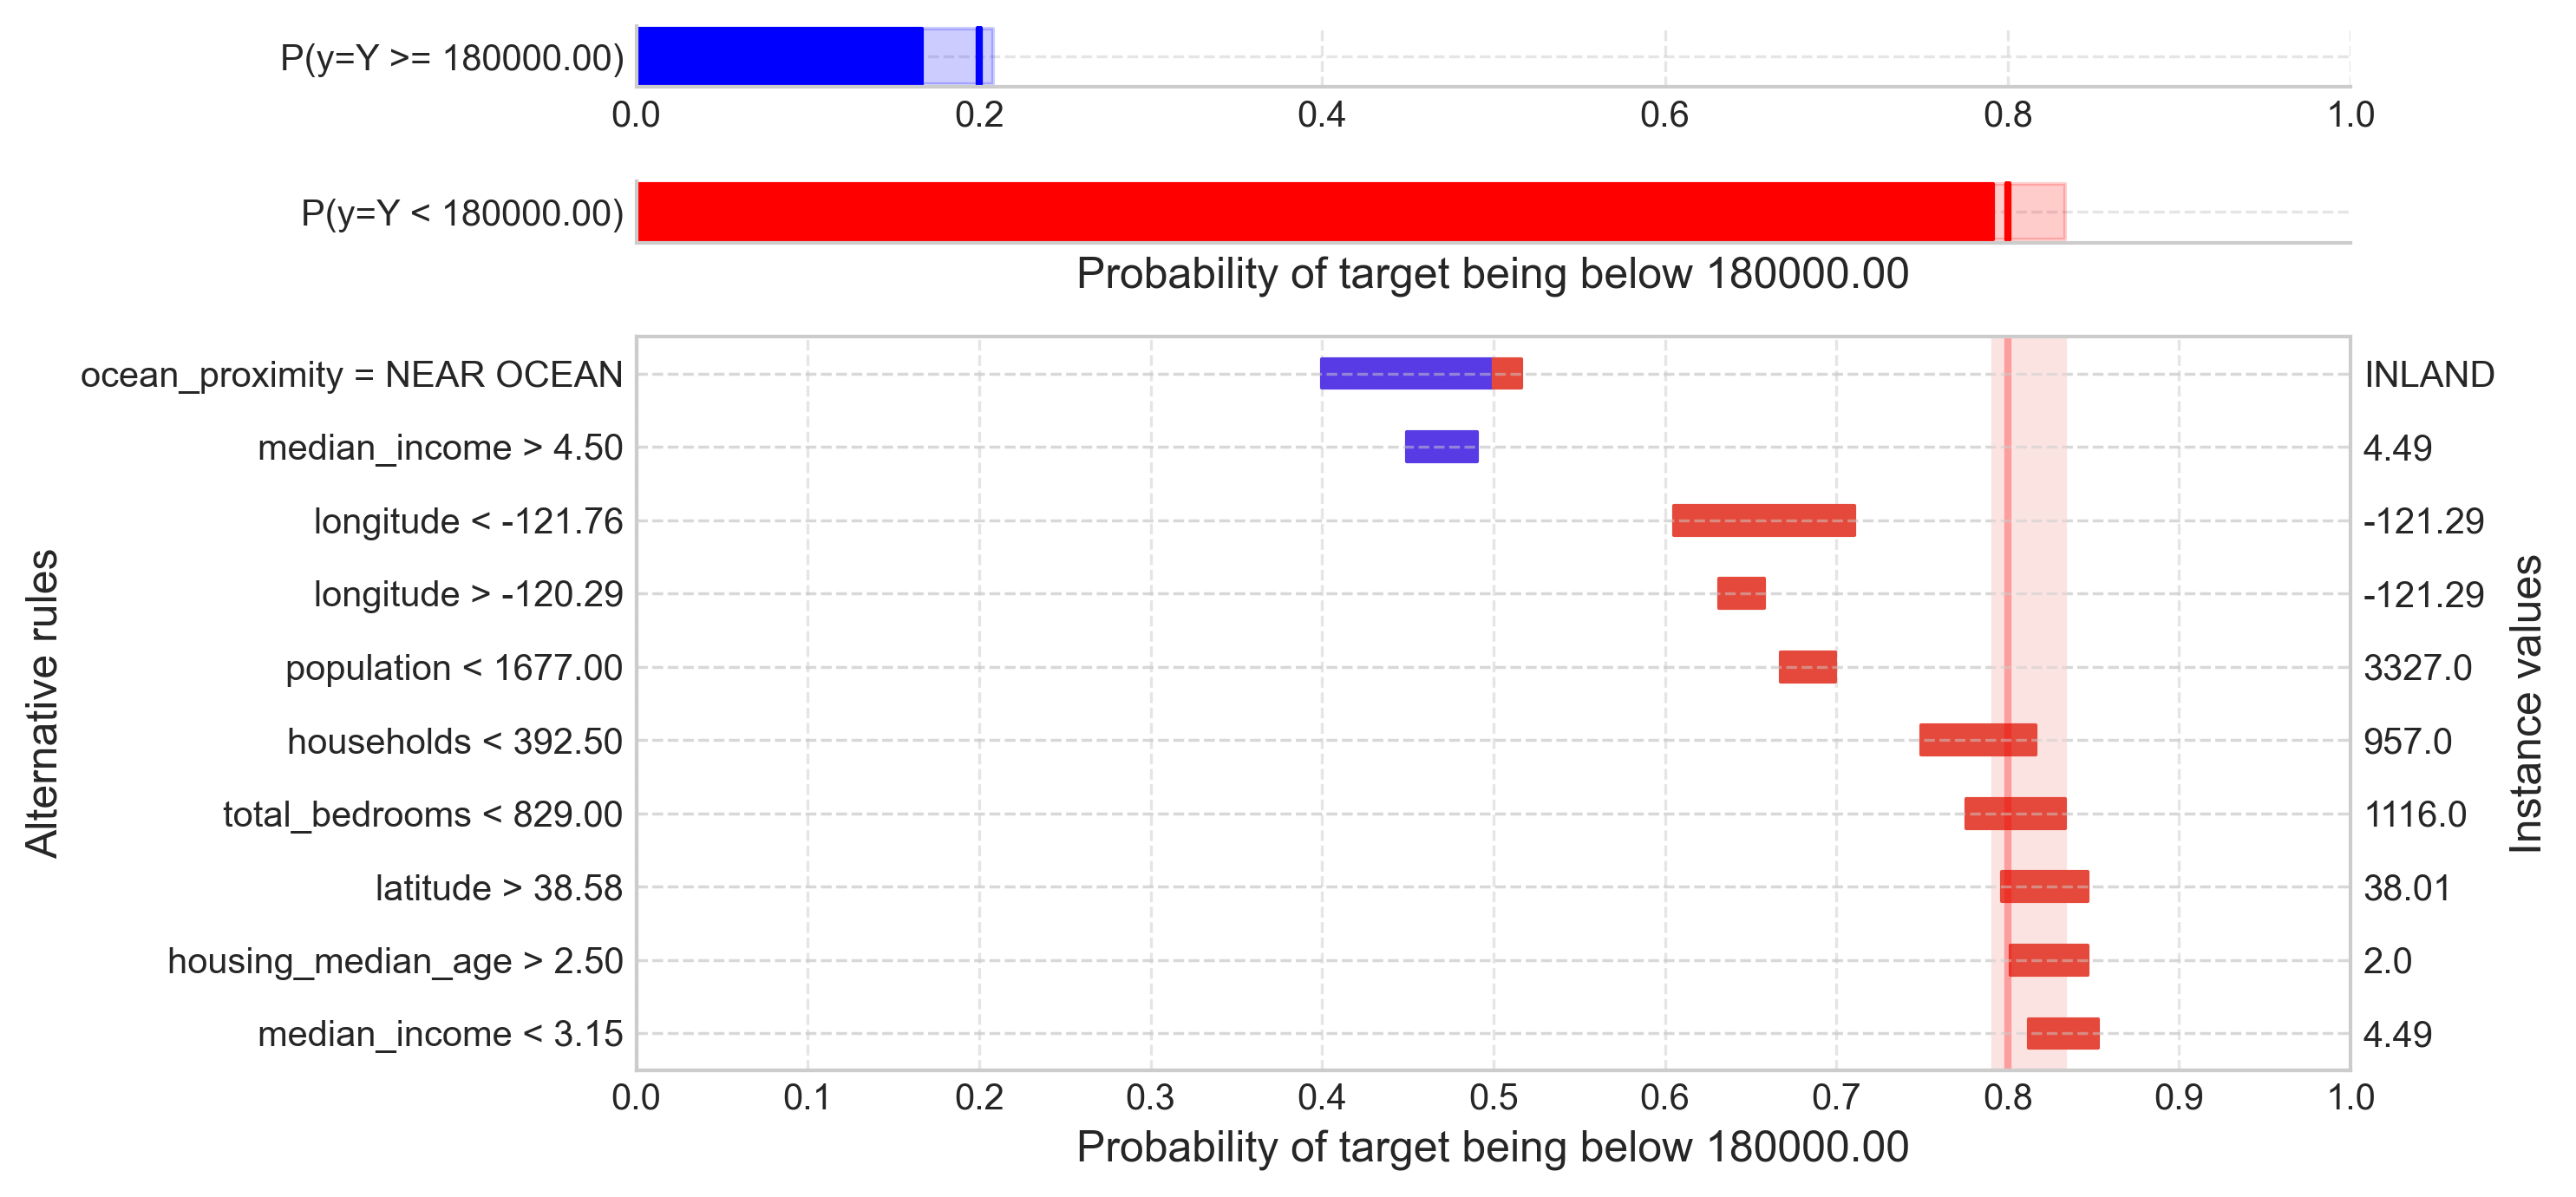

In [27]:
alternative_explanation.add_conjunctions().plot()

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\viz\matplotlib_adapter.py:1199: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(rect=(0, 0, 1, 0.94))


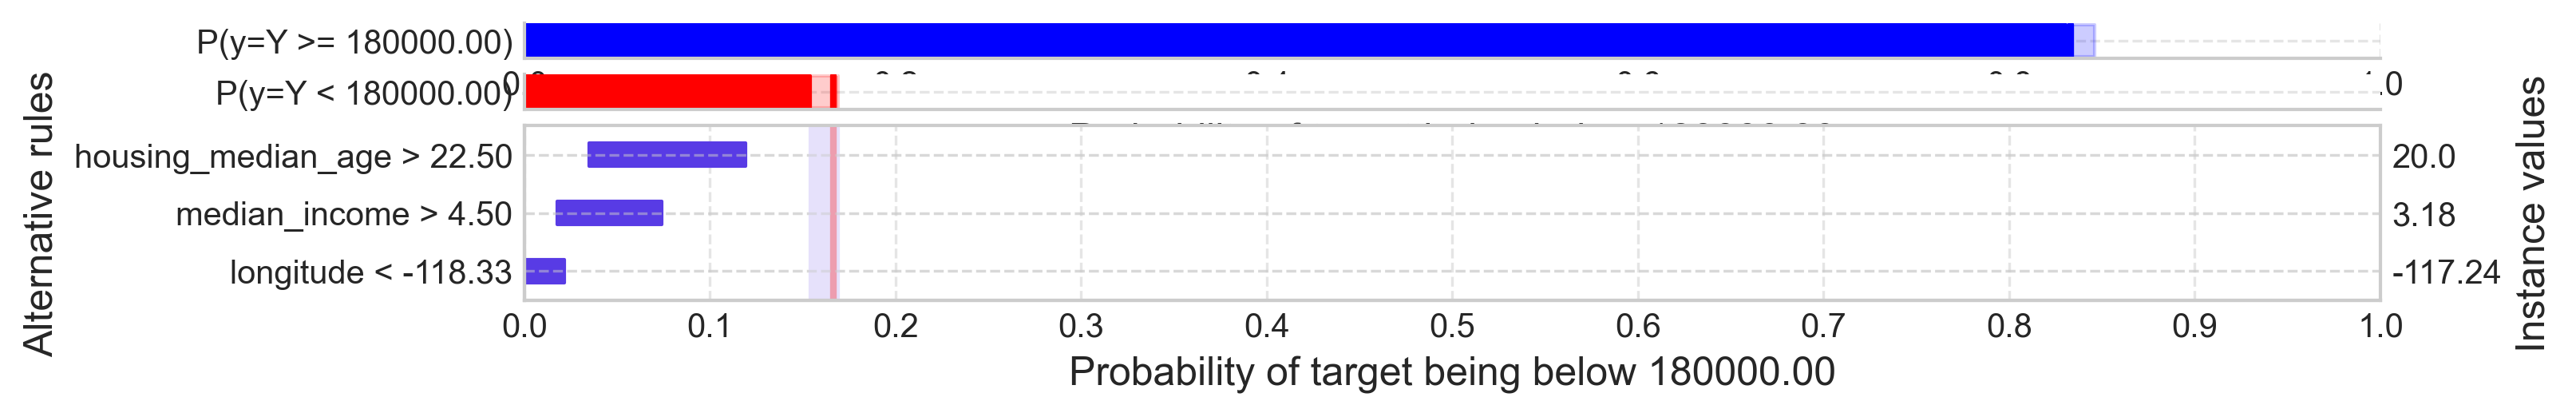

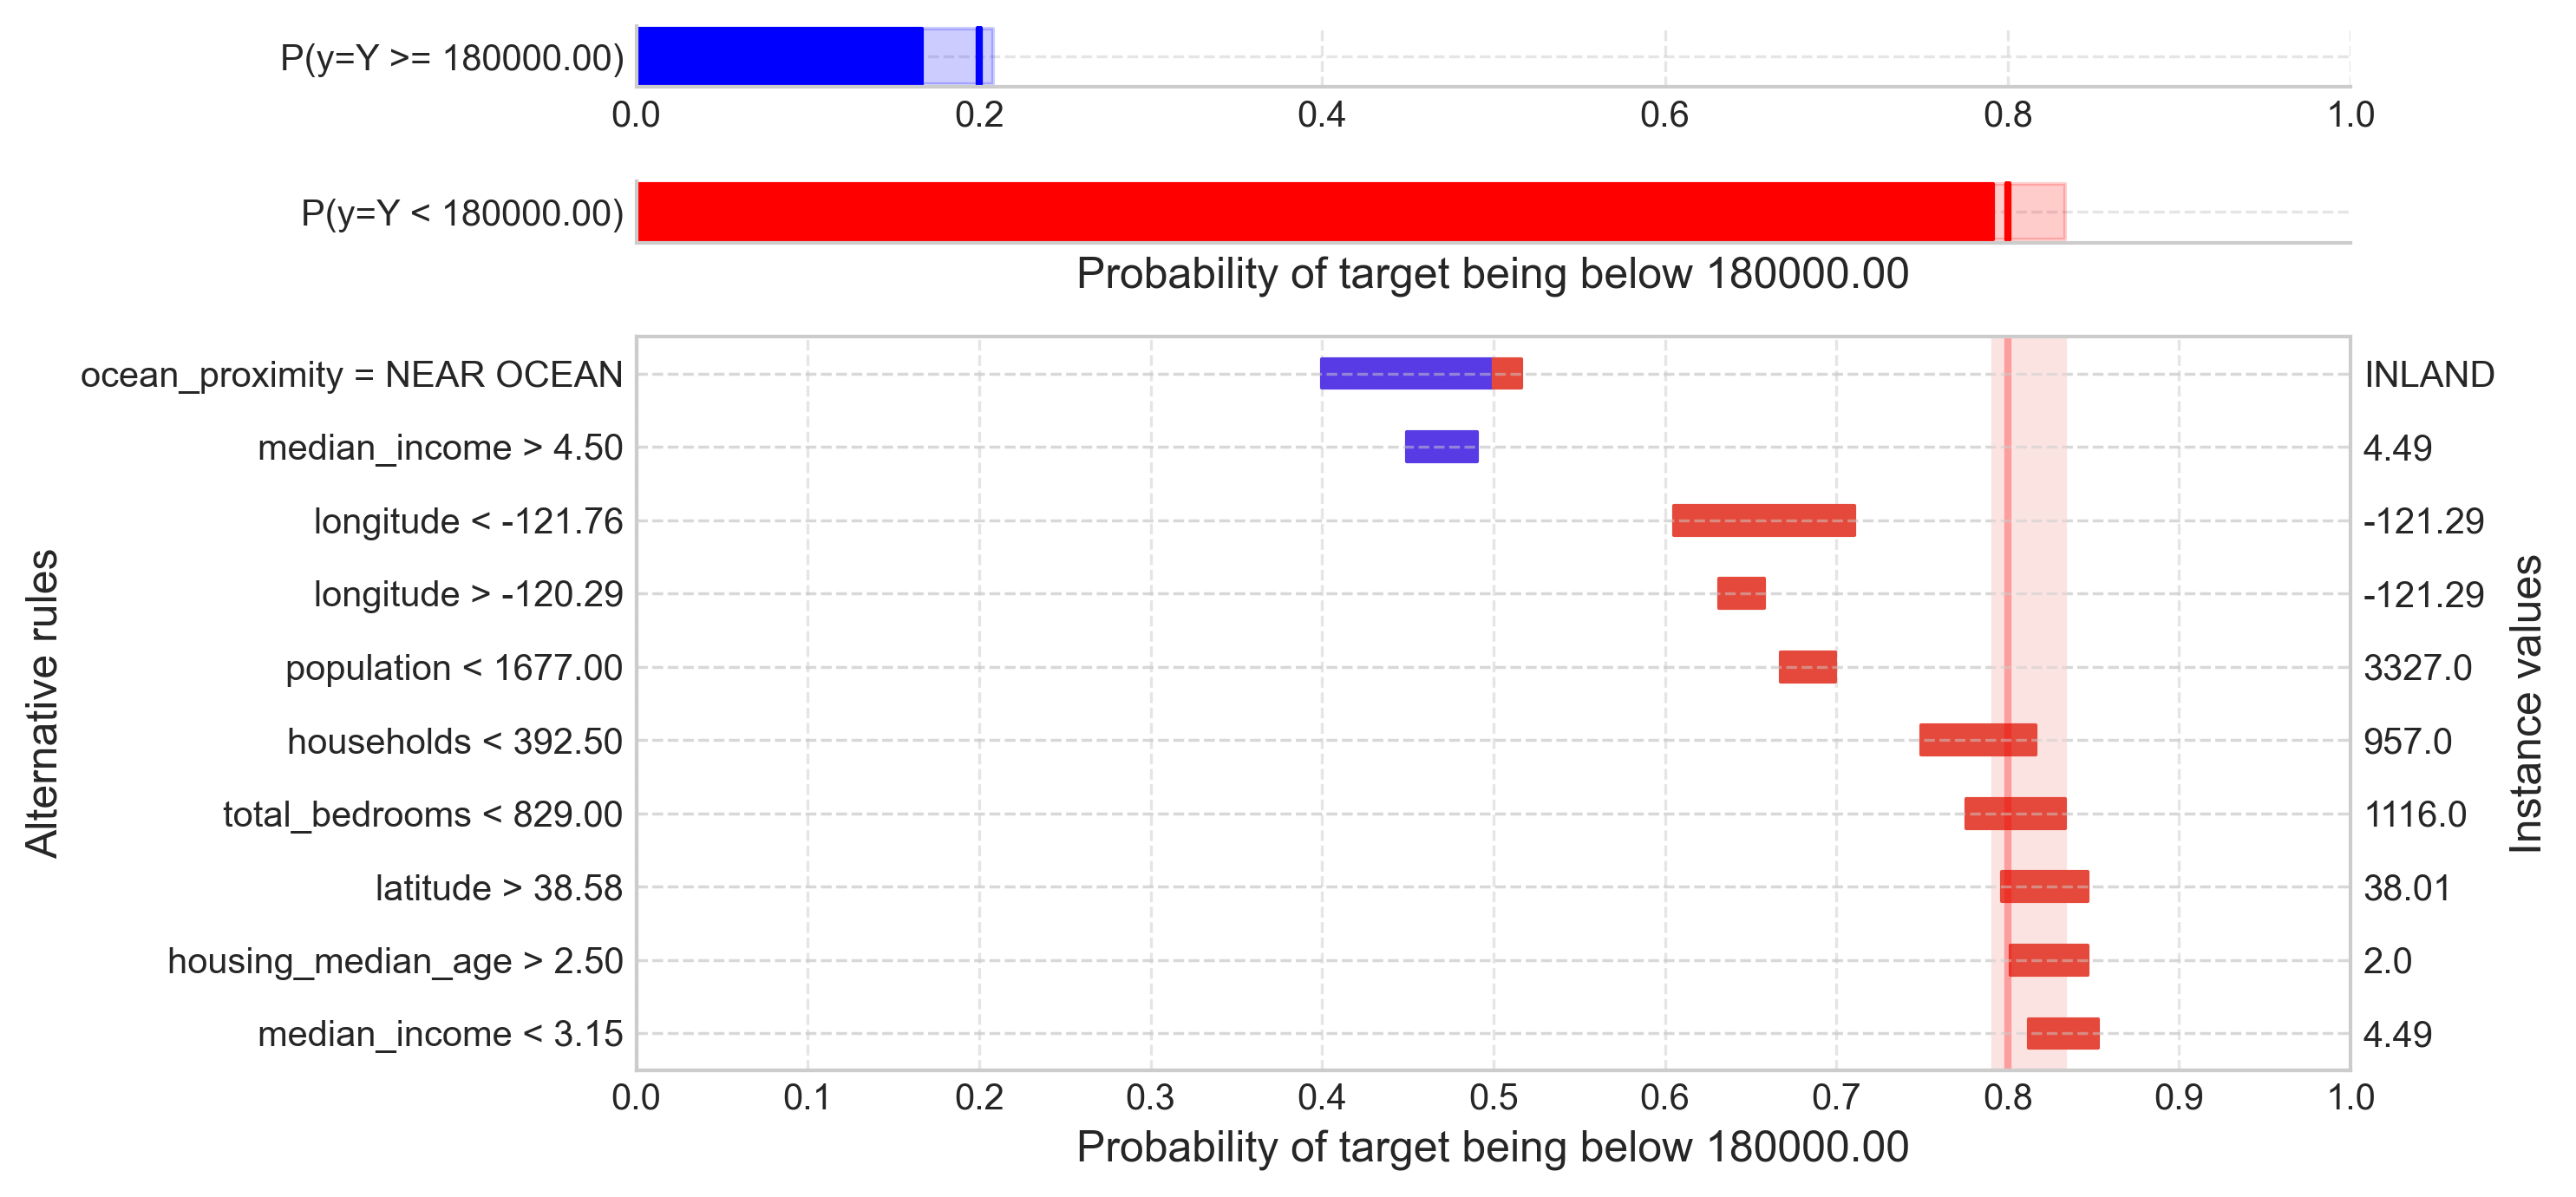

In [28]:
alternative_explanation.add_conjunctions().plot()

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\viz\matplotlib_adapter.py:1199: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(rect=(0, 0, 1, 0.94))


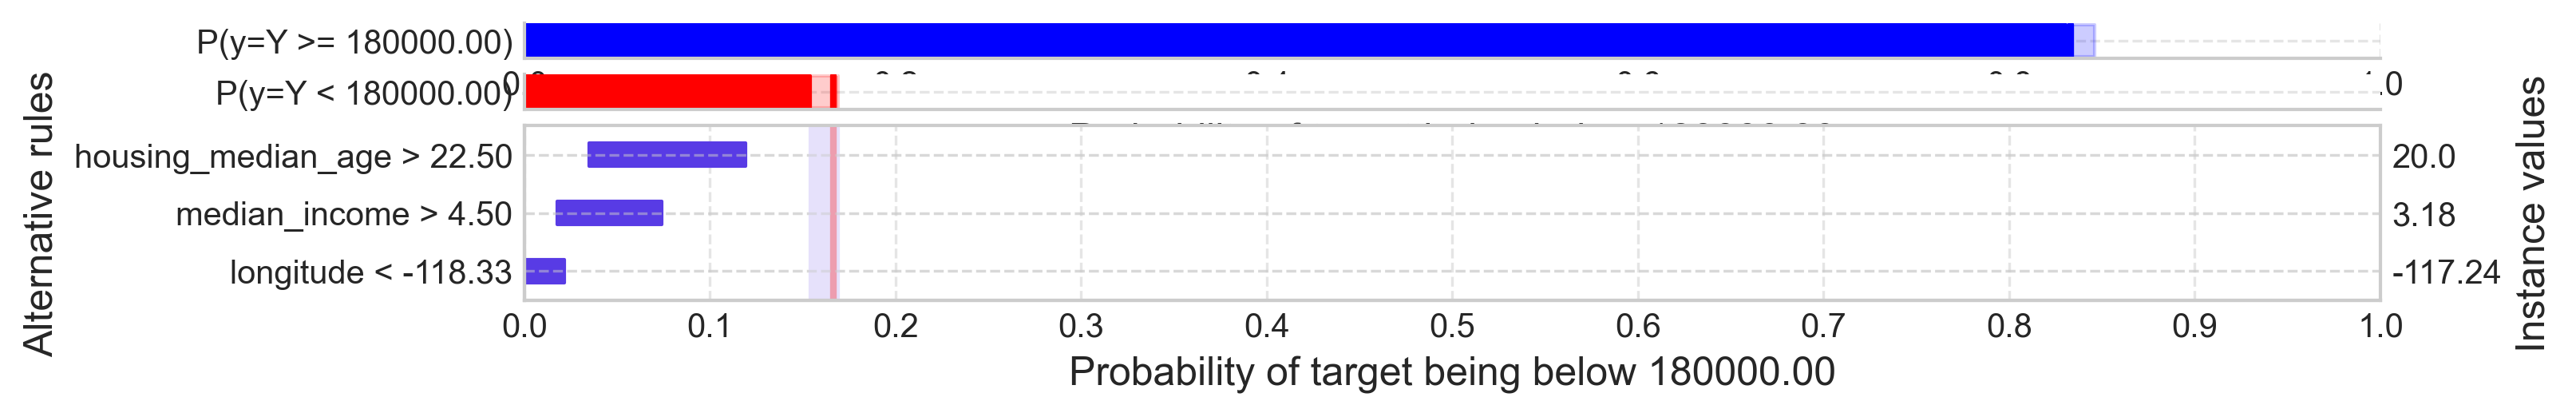

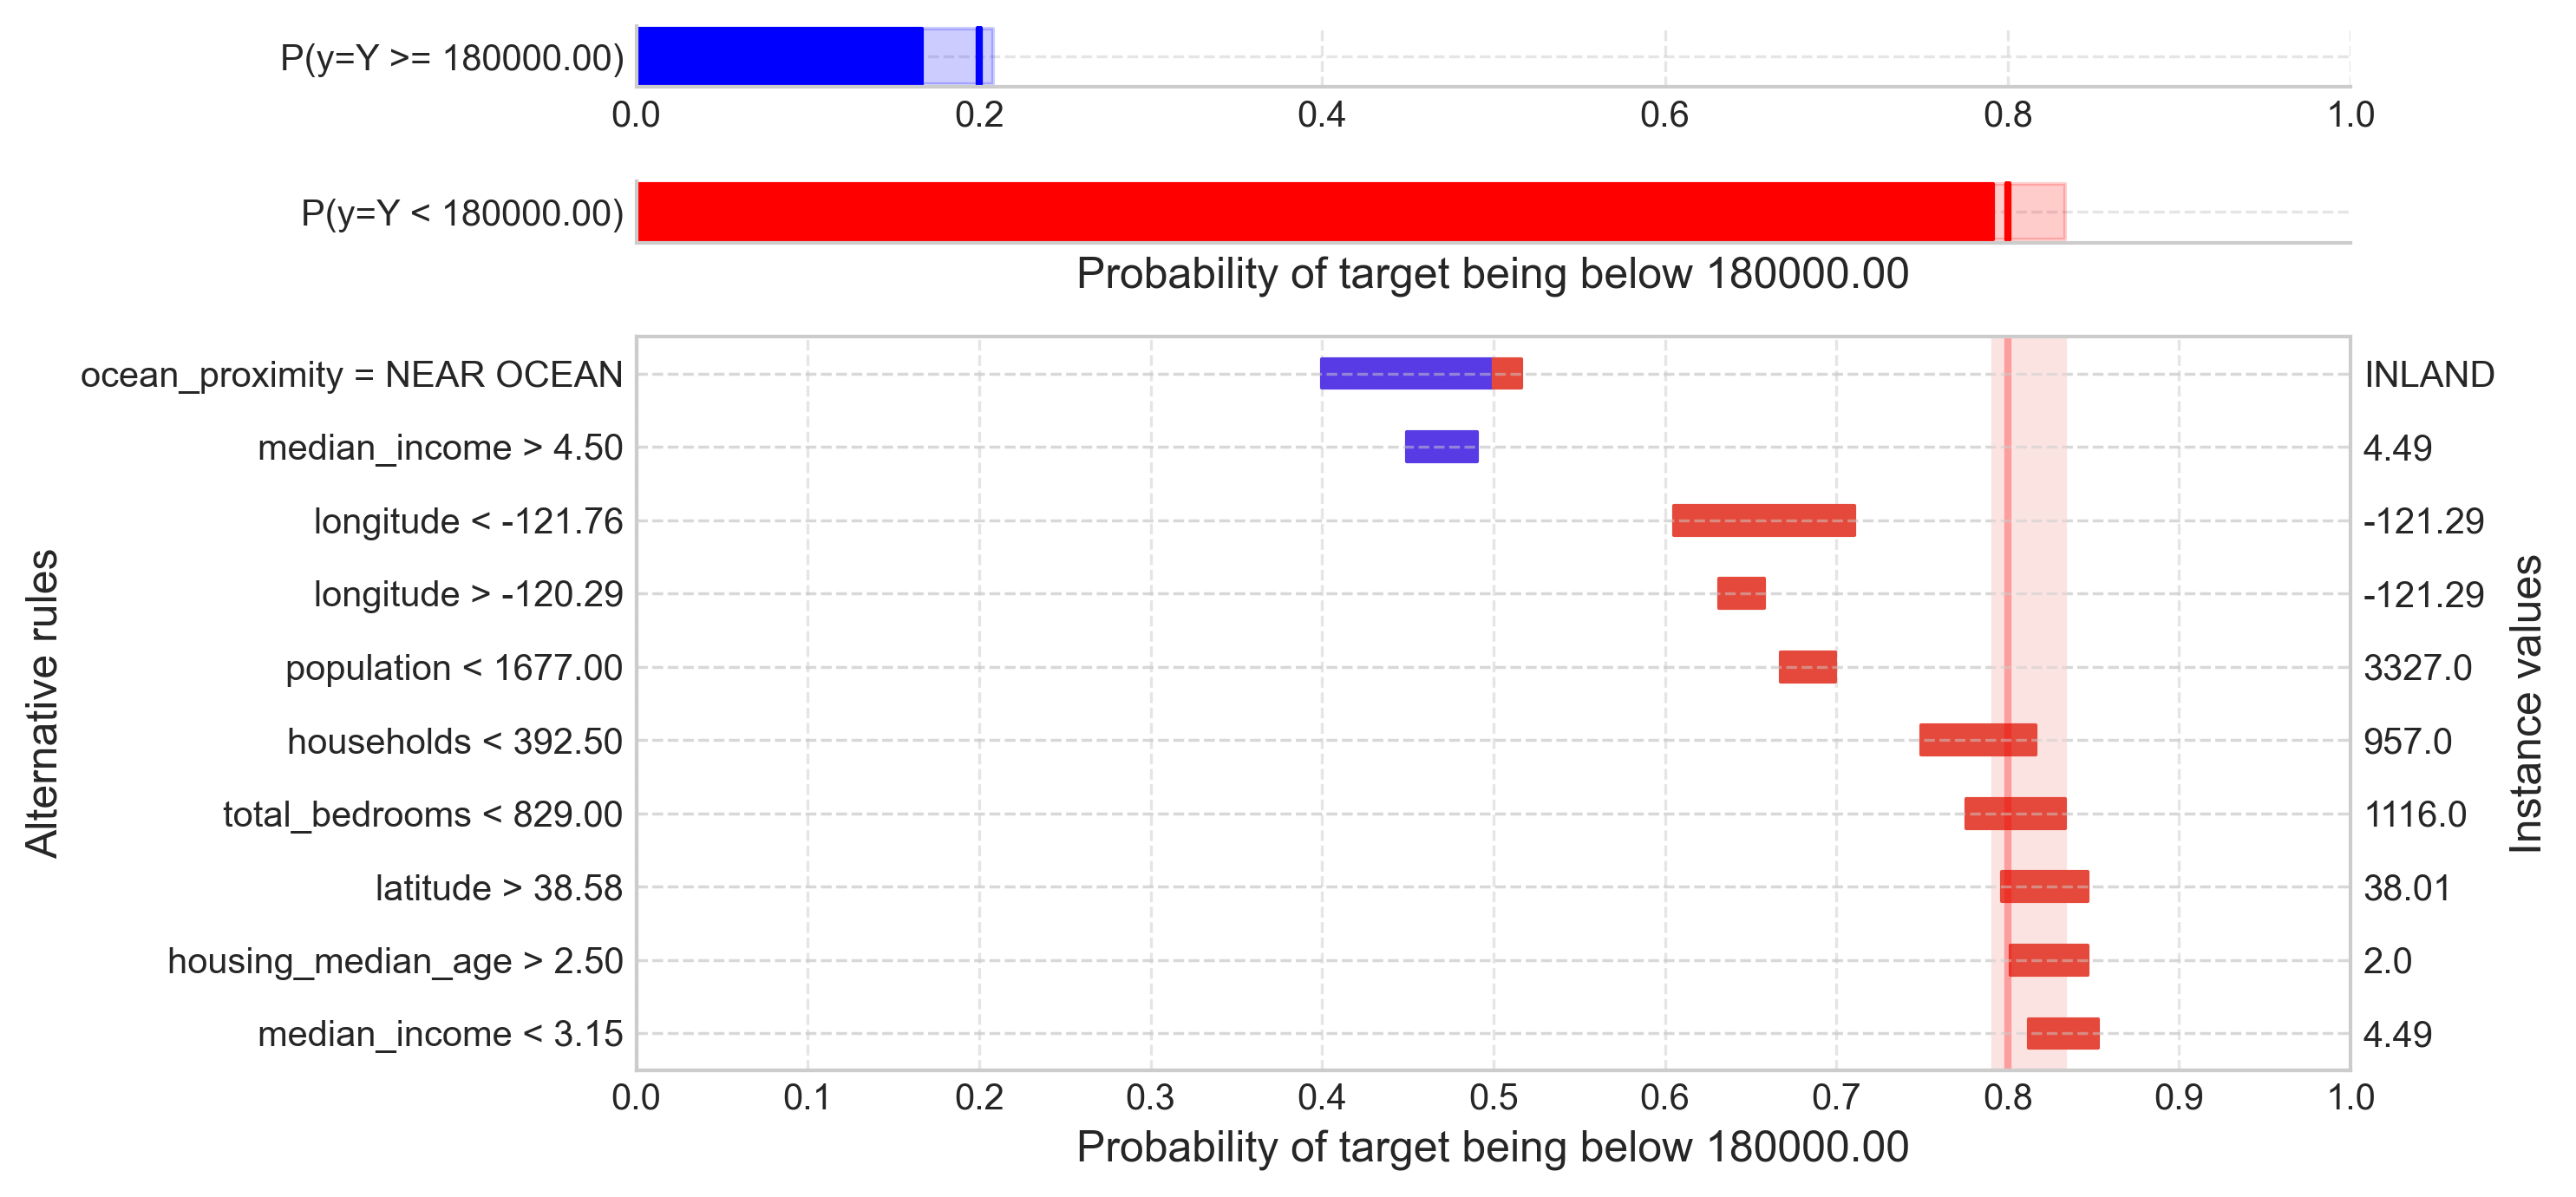

In [29]:
alternative_explanation.remove_conjunctions().plot()